In [2]:
require(tidyverse)
require(openxlsx)
require(lme4)

Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: openxlsx

Warning message:
"package 'openxlsx' was built under R version 4.2.2"
Loading required package: lme4

Warning message:
"package 'lme4' was built under R version 4.2.2"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.2"

Attaching package: 'Matrix'


The following objects are masked from

### Input data

In [3]:
df_norm <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-归一化.csv")
df_stat <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-描述性统计.csv")

df_raw <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx")
df_raw_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx", sheet = 2)

df_ykl <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx")
df_ykl_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 2)

df_stress <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 3)
df_stress_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 4)


In [4]:
# Traits needs to be removed in V4
remove <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V4-updated-20221202.xlsx", sheet = 3)
rm_traits <- remove$Remove_Trait

update_data <- function(df, rm_traits){
    df <- df %>% select(setdiff(colnames(.) ,rm_traits))
    return(df)
}
df_raw <- update_data(df_raw, rm_traits)
df_norm <- update_data(df_norm, rm_traits)
df_ykl <- update_data(df_ykl, rm_traits)
df_stress <- update_data(df_stress, rm_traits)

df_raw_anno <- df_raw_anno %>% mutate(性状分类1 = gsub(' ', '', 性状分类1))

In [5]:
# Phenotype summary
# pheno_sum <- read.xlsx("../phenotype_data/Previous_version/Pheno_summary.xlsx")
pheno_sum <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状 - 属性解释表.xlsx") %>%
    mutate(性状分类1 = gsub(' ', '', 性状分类1)) %>% 
    subset(!性状 %in% rm_traits) %>% # remove problem traits
    mutate(Replicate = toupper(Replicate))

In [6]:
# pheno_sum$Year %>% unique

# pheno_sum$Location %>% unique

# pheno_sum$Treatment %>% unique

# pheno_sum$Replicate %>% unique

# pheno_sum$Trait %>% unique %>% length

### BLUP
#### 全部性状属性信息
Trait + Treatment (726种组合) -- Replicate + location + year

In [7]:
# tidy up pheno summary
pheno_sum <- pheno_sum %>% 
    mutate(Replicate2 = ifelse(is.na(Replicate), 'R1', Replicate)) %>% 
    mutate(Treatment = ifelse(is.na(Treatment), 'BLANK', Treatment))

#### 按-地点-年份-重复-拟合不lm同模型
##### 各性状的 地点-年份-重复 数量

In [7]:
generate_LocYearRep_num <- function(df_raw, pheno_sum, trait, treatment){
    tmp <- pheno_sum %>% subset(Trait == trait & Treatment == treatment) %>% subset(Replicate2 != 'AV')
    Loc_num = tmp$Location %>% unique %>% length
    Year_num = tmp$Year %>% unique %>% length
    Rep_num = tmp$Replicate2 %>% unique %>% length
    return(c(trait, treatment, Loc_num, Year_num, Rep_num))
}
generate_LocYearRep_num(df_raw, pheno_sum, "FE", "BLANK")

[1] "FE"    "BLANK" "1"     "1"     "2"

In [8]:
LYR_num_list <- list()
for (trait in pheno_sum$Trait %>% unique){
    for (treatment in pheno_sum %>% subset(Trait == trait) %>% .$Treatment %>% unique) {
        result_vec <- generate_LocYearRep_num(df_raw, pheno_sum, trait, treatment)
        LYR_num_list[[paste0(trait, '_', treatment)]] = result_vec
    }
}

In [9]:
df_LYR <- do.call(rbind, LYR_num_list) %>% 
data.frame() %>% 
mutate(numCombo = paste0(X3, X4, X5)) %>% 
setNames(c('Trait', 'Treatment', 'Location', 'Year', 'Replicate', 'numCombo'))

In [10]:
tmp <- do.call(rbind, LYR_num_list) %>% 
    data.frame() %>% 
    mutate(numCombo = paste0(X3, X4, X5)) %>% 
    setNames(c('Trait', 'Treatment', 'Location', 'Year', 'Replicate', 'numCombo')) %>% 
    group_by(numCombo) %>% 
    summarize_at('Trait', list(length))

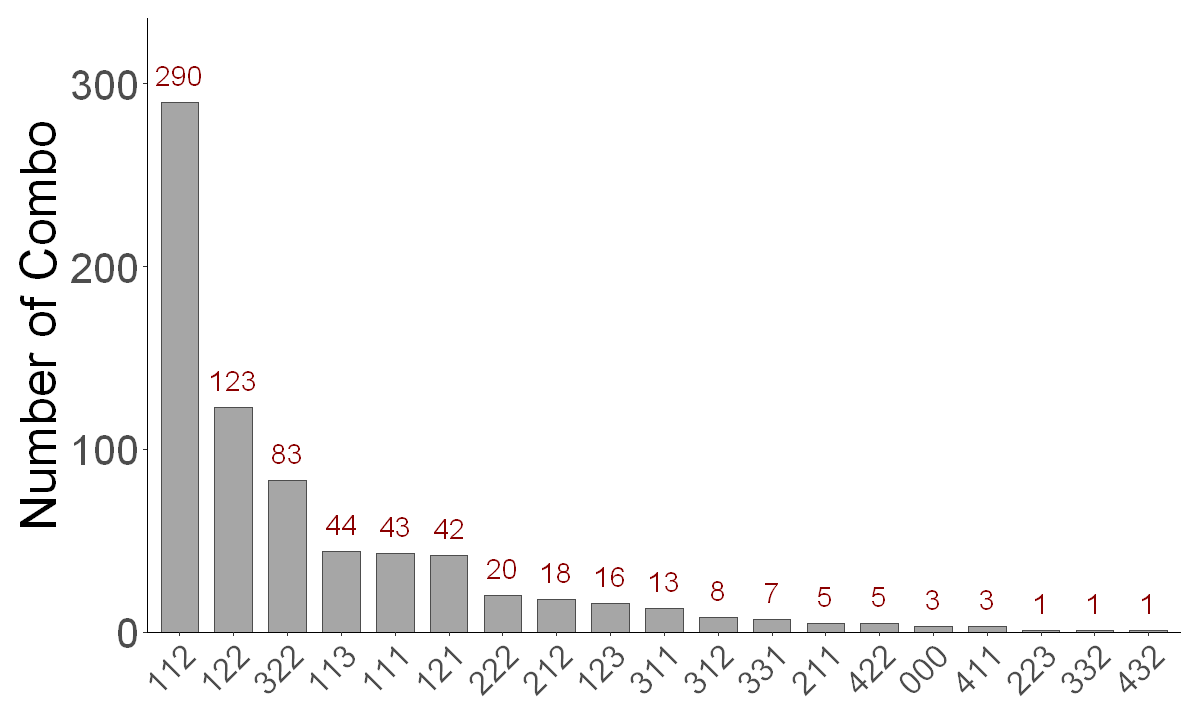

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)

tmp %>% 
    arrange(desc(Trait)) %>% 
    mutate(numCombo = factor(numCombo, levels = .$numCombo)) %>% 
    ggplot(aes(numCombo, Trait)) +
    geom_col(width = 0.7, alpha = 0.5, color = "grey30", fill = "grey30") +
    geom_text(aes(x = numCombo, y = Trait + 15, label = Trait), size=6, color = "darkred") +
    theme_classic()+
    ylab("Number of Combo") +
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))+
    theme(axis.text.y = element_text(size = 25),
          axis.text.x = element_text(size = 20, angle = 45, hjust=1, vjust=1),
          axis.title = element_text(size = 30),
          axis.title.x  = element_blank(),
          legend.text = element_text(size = 25),
          legend.title = element_text(size = 30),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

#### 地点-年份-重复 具体划分
- 单年-单点-有重复 无法计算遗传力，计算均值当做blup。
- 按照 地点 年份 的level 是否 > 1 划分四种情况拟合模型
    - 多年 多点 
        - 有重复
    > lmer(value ~ (1|ID)+(1|Location/Replicate2)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)
        - 无重复
    > lmer(value ~ (1|ID)+(1|Location)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)    
    - 一年 多点
        - 有重复
    > lmer(value ~ (1|ID)+(1|Location/Replicate2)+(1|ID:Location), data = tmp2)
        - 无重复
    > lmer(value ~ (1|ID)+(1|Location)+(1|ID:Location), data = tmp2)
    - 多年 一点
        - 有/无重复
    > lmer(value ~ (1|ID)+(1|Year)+(1|ID:Year), data = tmp2)
    
    - 一年一点 有/无重复
    
    


In [12]:
generate_blup_heridity <- function(df_raw, pheno_sum, trait, treatment){
    comboID <- paste0(trait, '_', treatment) 
    
    tmp <- pheno_sum %>% # generate trait info
        subset(Trait == trait & Treatment == treatment) %>% 
        subset(Replicate2 != 'AV')
    
    tmp2 <- df_raw[c('ID', tmp$性状)] %>% # extract trait value
        gather(性状, value, 2:ncol(.)) %>% 
        merge(tmp, '性状') %>% 
        .[c('Trait', 'Treatment', 'Location', 'Year', 'Replicate2', '性状', 'ID', 'value' )] %>% 
        mutate(ID = as.factor(ID)) %>% 
        mutate(Trait = as.factor(Trait)) %>% 
        mutate(Location = as.factor(Location)) %>% 
        mutate(Year = as.factor(Year)) %>% 
        mutate(Treatment = as.factor(Treatment)) %>% 
        mutate(Replicate2 = as.factor(Replicate2)) %>% 
        mutate(value = as.numeric(value))
    
    ID_num = levels(tmp2$ID) %>% length
    L_num = levels(tmp2$Location) %>% length
    Y_num = levels(tmp2$Year) %>% length
    R_num = levels(tmp2$Replicate2) %>% length
    
    # generate BLUP
    generate_blup <- function(mod1, comboID){
        random <- ranef(mod1)
        fixed <- fixef(mod1)
        BLUP <- fixed[1] + random$ID
        colnames(BLUP)[1] = comboID 
        return(BLUP)
    }

    # generate Heredity
    generate_heredity <- function(mod1){
        df_vec <- summary(mod1)[['varcor']] %>% as.data.frame
        var_vec <-df_vec$vcov
        names(var_vec) <- df_vec$grp
        return(var_vec)
    }
    
    
    if (L_num > 1 & Y_num >1){
        if (R_num > 1){
            
            mod1 = lmer(value ~ (1|ID)+(1|Location/Replicate2)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)
            blup = generate_blup(mod1, comboID)
            
            mod_var = generate_heredity(mod1)
            var_G = mod_var['ID']
            var_RL = mod_var['Replicate2:Location']/(L_num*R_num)
            var_L = mod_var['Location']/L_num
            var_Y = mod_var['Year']/Y_num
            var_IL = mod_var['ID:Location']/(ID_num*L_num)
            var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
            h2 = var_G / (var_G +var_RL + var_L + var_Y + var_IL + var_IY)
            h2 = unname(h2)
            
        }else if (R_num == 1){
            
            mod1 = lmer(value ~ (1|ID)+(1|Location)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)
            blup = generate_blup(mod1, comboID)
            
            mod_var = generate_heredity(mod1)
            var_G = mod_var['ID']
            var_L = mod_var['Location']/L_num
            var_Y = mod_var['Year']/Y_num
            var_IL = mod_var['ID:Location']/(ID_num*L_num)
            var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
            h2 = var_G / (var_G + var_L + var_Y + var_IL + var_IY)
            h2 = unname(h2)
            
        }
    }else if (L_num > 1 & Y_num <= 1){
        if (R_num > 1){
            
            mod1 = lmer(value ~ (1|ID)+(1|Location/Replicate2) +(1|ID:Location), data = tmp2)
            blup = generate_blup(mod1, comboID)
            
            mod_var = generate_heredity(mod1)
            var_G = mod_var['ID']            
            var_RL = mod_var['Replicate2:Location']/(L_num*R_num)
            var_L = mod_var['Location']/L_num
            var_IL = mod_var['ID:Location']/(ID_num*L_num)           
            h2 = var_G / (var_G + var_RL + var_L + var_IL)
            h2 = unname(h2)
                        
        }else if (R_num == 1){

#             mod1 = lmer(value ~ (1|ID)+(1|Location)+(1|ID:Location), data = tmp2)
            mod1 = lmer(value ~ (1|ID)+(1|Location), data = tmp2)
            blup = generate_blup(mod1, comboID)
            
            mod_var = generate_heredity(mod1)
            var_G = mod_var['ID']
            var_L = mod_var['Location']/L_num
#             var_IL = mod_var['ID:Location']/(ID_num*L_num)         
            h2 = var_G / (var_G + var_L)     
            h2 = unname(h2)
            
        }        
    }else if (L_num <= 1 & Y_num > 1){
        
        mod1 = lmer(value ~ (1|ID)+(1|Year)+(1|ID:Year), data = tmp2)
        blup = generate_blup(mod1, comboID)
        
        mod_var = generate_heredity(mod1)
        var_G = mod_var['ID']
        var_Y = mod_var['Year']/Y_num
        var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
        h2 = var_G / (var_G + var_Y + var_IY)         
        h2 = unname(h2)
               
    }else if (L_num <= 1 & Y_num <= 1){
        
        blup = tmp2 %>% group_by(ID) %>% summarize_at('value', list(mean)) %>% 
            column_to_rownames(var='ID') %>% setNames(comboID)
        h2 = NA
        
    }else {
        blup = NA
        h2 = NA
    }
    
    return(list(blup, h2))
}

In [13]:
# result_list <- list()
# for (trait in pheno_sum$Trait %>% unique){
#     for (treatment in pheno_sum %>% subset(Trait == trait) %>% .$Treatment %>% unique) {
#         print(paste(trait, '---', treatment, 'is runing...'))
#         label = paste0(trait, '_', treatment)
#         result_list[[label]] = generate_blup_heridity(df_raw, pheno_sum, trait, treatment)
#     }
# }

In [14]:
result_list <- list()
for (trait in pheno_sum$Trait %>% unique) {
    for (treatment in pheno_sum %>% subset(Trait == trait) %>% .$Treatment %>% unique) {
        tryCatch({
            print(paste(trait, "---", treatment, "is runing..."))
            label = paste0(trait, "_", treatment)
            result_list[[label]] = generate_blup_heridity(df_raw, pheno_sum, trait, treatment)
        }, error = function(e) {
            cat("ERROR :", conditionMessage(e), "")
        })
    }
}

[1] "FE --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FE --- BLANK is runing..."
[1] "FE --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FE --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FL --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FL --- BLANK is runing..."
[1] "FL --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FL --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FS --- CK is runing..."
[1] "FS --- BLANK is runing..."
[1] "FS --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FS --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "MIC --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "MIC --- BLANK is runing..."
[1] "MIC --- DCK is runing..."
[1] "MIC --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FU --- CK is runing..."
[1] "FU --- BLANK is runing..."
[1] "FU --- DCK is runing..."
[1] "FU --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "MAT --- CK is runing..."
[1] "MAT --- BLANK is runing..."
[1] "SCI --- CK is runing..."
[1] "SCI --- BLANK is runing..."
[1] "SFI --- CK is runing..."
[1] "SFI --- BLANK is runing..."
[1] "Ln5 --- BLANK is runing..."
[1] "FNN --- BLANK is runing..."
[1] "FNS --- BLANK is runing..."
[1] "Fine --- BLANK is runing..."
[1] "IM --- BLANK is runing..."
[1] "Ln --- BLANK is runing..."
[1] "MR --- BLANK is runing..."
[1] "SFCn --- BLANK is runing..."
[1] "SFCw --- BLANK is runing..."
[1] "TNN --- BLANK is runing..."
[1] "TNS --- BLANK is runing..."
[1] "UQLw --- BLANK is runing..."
[1] "EE --- BLANK is runing..."
[1] "CC --- BLANK is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00608396 (tol = 0.002, component 1)"


[1] "HH --- BLANK is runing..."
[1] "LL --- BLANK is runing..."
[1] "aa --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "bb --- BLANK is runing..."
[1] "WH --- BLANK is runing..."
[1] "L --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "a --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "b --- BLANK is runing..."
[1] "W10 --- BLANK is runing..."
[1] "T10 --- BLANK is runing..."
[1] "T10 --- Hyd12d is runing..."
[1] "T10 --- FTP is runing..."
[1] "T10 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "x10 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "y10 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "C --- BLANK is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00298828 (tol = 0.002, component 1)"


[1] "h --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L1 --- BLANK is runing..."
[1] "L1 --- Hyd12d is runing..."
[1] "L1 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L1 --- FEF is runing..."
[1] "a1 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "b1 --- BLANK is runing..."
[1] "X10 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Y10 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Z10 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Rx --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Ry --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Rz --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "R457 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "WF --- BLANK is runing..."
[1] "SFC --- BLANK is runing..."
[1] "Cellulose --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Lignin_H --- BLANK is runing..."
[1] "BN --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BN --- BLANK is runing..."
[1] "BN --- DCK is runing..."
[1] "BN --- DR is runing..."
[1] "BW --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BW --- BLANK is runing..."
[1] "BW --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BW --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "LP --- BLANK is runing..."
[1] "LP --- CK is runing..."
[1] "LP --- DCK is runing..."
[1] "LP --- DR is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0022596 (tol = 0.002, component 1)"


[1] "SI --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SI --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SI --- DCK is runing..."
[1] "SI --- DR is runing..."
[1] "SY --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SY --- DCK is runing..."
[1] "SY --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Y --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Y --- DCK is runing..."
[1] "Y --- DR is runing..."
[1] "SI_18 --- BLANK is runing..."
[1] "LI --- BLANK is runing..."
[1] "LI --- CK is runing..."


Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


[1] "LI --- DCK is runing..."
[1] "LI --- DR is runing..."
[1] "FABN --- DCK is runing..."
[1] "FABN --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FABR --- DCK is runing..."
[1] "FABR --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BON_blooming --- DCK is runing..."
[1] "BON_blooming --- DR is runing..."
[1] "YT --- DCK is runing..."
[1] "YT --- DR is runing..."
[1] "EFBA --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "EFBA --- CK is runing..."
[1] "EFBA --- DCK is runing..."
[1] "EFBA --- DR is runing..."
[1] "EFBL --- BLANK is runing..."
[1] "EFBL --- CK is runing..."
[1] "EFBL --- DCK is runing..."
[1] "EFBL --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FBA --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FBA --- CK is runing..."
[1] "FBA --- DCK is runing..."
[1] "FBA --- DR is runing..."
[1] "FBL --- BLANK is runing..."
[1] "FBL --- CK is runing..."
[1] "FBL --- DCK is runing..."
[1] "FBL --- DR is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00290041 (tol = 0.002, component 1)"


[1] "FBN --- BLANK is runing..."
[1] "FBN --- CK is runing..."
[1] "FBN --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FBN --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FFBA --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FFBA --- CK is runing..."
[1] "FFBA --- DCK is runing..."
[1] "FFBA --- DR is runing..."
[1] "FFBH --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FFBH --- CK is runing..."
[1] "FFBH --- DCK is runing..."
[1] "FFBH --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FFBL --- BLANK is runing..."
[1] "FFBL --- CK is runing..."
[1] "FFBL --- DCK is runing..."
[1] "FFBL --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "LBN --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "NNFF --- BLANK is runing..."
[1] "NNFF --- CK is runing..."
[1] "NNFF --- DCK is runing..."
[1] "NNFF --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PH --- BLANK is runing..."
[1] "PH --- CK is runing..."
[1] "PH --- DCK is runing..."
[1] "PH --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PH1 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PH2 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PW --- BLANK is runing..."
[1] "PW --- CK is runing..."
[1] "SFBA --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SFBA --- CK is runing..."
[1] "SFBA --- DCK is runing..."
[1] "SFBA --- DR is runing..."
[1] "SFBL --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SFBL --- CK is runing..."
[1] "SFBL --- DCK is runing..."
[1] "SFBL --- DR is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00322865 (tol = 0.002, component 1)"


[1] "FBN_FB --- DCK is runing..."
[1] "FBN_FB --- DR is runing..."
[1] "FFBH_BS --- DCK is runing..."
[1] "FFBH_BS --- DR is runing..."
[1] "PH_FB --- DCK is runing..."
[1] "BODI --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BODI --- CK is runing..."
[1] "BOP --- CK is runing..."
[1] "FBOD --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FBOD --- CK is runing..."
[1] "FD --- BLANK is runing..."
[1] "FDI --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FDI --- CK is runing..."
[1] "FFD --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "FFD --- CK is runing..."
[1] "SBOD --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SBOD --- CK is runing..."
[1] "SFD --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SFD --- CK is runing..."
[1] "FT --- DCK is runing..."
[1] "FT --- DR is runing..."
[1] "FN_blooming --- DCK is runing..."
[1] "FN_blooming --- DR is runing..."
[1] "DrW --- BLANK is runing..."
[1] "DrW --- CK is runing..."
[1] "FrW --- BLANK is runing..."
[1] "FrW --- Hyd12d is runing..."
[1] "FrW --- FEF is runing..."
[1] "Frw --- CK is runing..."
[1] "LeA --- BLANK is runing..."
[1] "LeA --- CK is runing..."
[1] "LeC --- BLANK is runing..."
[1] "LeG --- BLANK is runing..."
[1] "LeG --- CK is runing..."
[1] "LeG --- DCK is runing..."
[1] "LeN --- BLANK is runing..."
[1] "LeN --- DCK is runing..."
[1] "LPA --- BLANK is runing..."
[1] "LPA --- CK is runing..."
[1] "LPA --- DCK is runing..."
[1] "SPAD --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SPAD --- CK is runing..."
[1] "SPAD --- DCK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SPAD --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SPAD --- SIN1 is runing..."
[1] "SPAD --- SIN2 is runing..."
[1] "SPAD --- SIP1 is runing..."
[1] "SPAD --- SIP2 is runing..."
[1] "SPAD --- TCK is runing..."
[1] "BL_10d --- BLANK is runing..."
[1] "TUWB_10d --- BLANK is runing..."
[1] "BL_TUWB_10d --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BV_10d --- BLANK is runing..."
[1] "BST_10d --- BLANK is runing..."
[1] "SFW_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CFW_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "FW_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "SFWR_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CFWR_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "SDW_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CDW_10d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must b

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00289054 (tol = 0.002, component 1)"


[1] "BV_20d --- BLANK is runing..."
[1] "BST_20d --- BLANK is runing..."
[1] "SFW_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CFW_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "FW_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "SFWR_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CFWR_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "SDW_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must be < number of observations (problems: ID:Year) [1] "CDW_20d --- BLANK is runing..."
ERROR : number of levels of each grouping factor must b

boundary (singular) fit: see help('isSingular')



[1] "SL --- Hyd12d is runing..."
[1] "SL --- Hyd4d is runing..."
[1] "SL --- Hyd8d is runing..."
[1] "SL --- FTP is runing..."
[1] "SL --- TCK is runing..."
[1] "STW --- CK is runing..."
[1] "STW --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SMW --- CK is runing..."
[1] "SMW --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SBW --- CK is runing..."
[1] "SBW --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SL_STW --- CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SL_STW --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SL_SMW --- BLANK is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00230371 (tol = 0.002, component 1)"


[1] "SL_SMW --- CK is runing..."
[1] "SL_SBW --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SL_SBW --- CK is runing..."
[1] "SL_AY --- BLANK is runing..."
[1] "DDrW --- Hyd12d is runing..."
[1] "DFrw --- Hyd12d is runing..."
[1] "GR --- Hyd4d is runing..."
[1] "LR --- Hyd12d is runing..."
[1] "LR --- Hyd8d is runing..."
[1] "LR --- FTP is runing..."
[1] "LR --- FEF is runing..."
[1] "PRL --- Hyd12d is runing..."
[1] "PRL --- Hyd4d is runing..."
[1] "PRL --- Hyd8d is runing..."
[1] "PRL --- FTP is runing..."
[1] "PRL --- FEF is runing..."
[1] "PRL --- BLANK is runing..."
[1] "PRL --- TCK is runing..."
[1] "UDrW --- Hyd12d is runing..."
[1] "UFrw --- Hyd12d is runing..."
[1] "AnRA --- Hyd12d is runing..."
[1] "AnRA --- FTP is runing..."
[1] "AnRA --- FEF is runing..."
[1] "AnRH --- Hyd12d is runing..."
[1] "AnRH --- FTP is runing..."
[1] "AnRH --- FEF is runing..."
[1] "AnRW --- Hyd12d is runing..."
[1] "AnRW --- FTP is runing..."
[1] "AnRW --- FEF is runing..."
[1] "AvgDiam --- Hyd12d is runing..."
[1] "AvgDiam --- FTP is runing..."
[1] "AvgDiam --- FEF is runing..."
[1] 

boundary (singular) fit: see help('isSingular')



[1] "L2 --- FEF is runing..."
[1] "L3 --- Hyd12d is runing..."
[1] "L3 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L3 --- FEF is runing..."
[1] "L4 --- Hyd12d is runing..."
[1] "L4 --- FTP is runing..."
[1] "L4 --- FEF is runing..."
[1] "L5 --- Hyd12d is runing..."
[1] "L5 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L5 --- FEF is runing..."
[1] "L6 --- Hyd12d is runing..."
[1] "L6 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L6 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L7 --- Hyd12d is runing..."
[1] "L7 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L7 --- FEF is runing..."
[1] "L8 --- Hyd12d is runing..."
[1] "L8 --- FTP is runing..."
[1] "L8 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L9 --- Hyd12d is runing..."
[1] "L9 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "L9 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Length --- Hyd12d is runing..."
[1] "Length --- FTP is runing..."
[1] "Length --- FEF is runing..."
[1] "Length --- BLANK is runing..."
[1] "LenPerVol --- Hyd12d is runing..."
[1] "LenPerVol --- FTP is runing..."
[1] "LenPerVol --- FEF is runing..."
[1] "PA1 --- Hyd12d is runing..."
[1] "PA1 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA1 --- FEF is runing..."
[1] "PA10 --- Hyd12d is runing..."
[1] "PA10 --- FTP is runing..."
[1] "PA10 --- FEF is runing..."
[1] "PA2 --- Hyd12d is runing..."
[1] "PA2 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA2 --- FEF is runing..."
[1] "PA3 --- Hyd12d is runing..."
[1] "PA3 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA3 --- FEF is runing..."
[1] "PA4 --- Hyd12d is runing..."
[1] "PA4 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA4 --- FEF is runing..."
[1] "PA5 --- Hyd12d is runing..."
[1] "PA5 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA5 --- FEF is runing..."
[1] "PA6 --- Hyd12d is runing..."
[1] "PA6 --- FTP is runing..."
[1] "PA6 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA7 --- Hyd12d is runing..."
[1] "PA7 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA7 --- FEF is runing..."
[1] "PA8 --- Hyd12d is runing..."
[1] "PA8 --- FTP is runing..."
[1] "PA8 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA9 --- Hyd12d is runing..."
[1] "PA9 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PA9 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "ProjArea --- Hyd12d is runing..."
[1] "ProjArea --- FTP is runing..."
[1] "ProjArea --- FEF is runing..."
[1] "RootVol --- Hyd12d is runing..."
[1] "SA1 --- Hyd12d is runing..."
[1] "SA1 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA1 --- FEF is runing..."
[1] "SA10 --- Hyd12d is runing..."
[1] "SA10 --- FTP is runing..."
[1] "SA10 --- FEF is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00371981 (tol = 0.002, component 1)"


[1] "SA2 --- Hyd12d is runing..."
[1] "SA2 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA2 --- FEF is runing..."
[1] "SA3 --- Hyd12d is runing..."
[1] "SA3 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA3 --- FEF is runing..."
[1] "SA4 --- Hyd12d is runing..."
[1] "SA4 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA4 --- FEF is runing..."
[1] "SA5 --- Hyd12d is runing..."
[1] "SA5 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA5 --- FEF is runing..."
[1] "SA6 --- Hyd12d is runing..."
[1] "SA6 --- FTP is runing..."
[1] "SA6 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA7 --- Hyd12d is runing..."
[1] "SA7 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA7 --- FEF is runing..."
[1] "SA8 --- Hyd12d is runing..."
[1] "SA8 --- FTP is runing..."
[1] "SA8 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA9 --- Hyd12d is runing..."
[1] "SA9 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SA9 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SurfArea --- Hyd12d is runing..."
[1] "SurfArea --- FTP is runing..."
[1] "SurfArea --- FEF is runing..."
[1] "SurfArea --- BLANK is runing..."
[1] "T1 --- Hyd12d is runing..."
[1] "T1 --- FTP is runing..."
[1] "T1 --- FEF is runing..."
[1] "T2 --- Hyd12d is runing..."
[1] "T2 --- FTP is runing..."
[1] "T2 --- FEF is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0649558 (tol = 0.002, component 1)"


[1] "T3 --- Hyd12d is runing..."
[1] "T3 --- FTP is runing..."
[1] "T3 --- FEF is runing..."
[1] "T4 --- Hyd12d is runing..."
[1] "T4 --- FTP is runing..."
[1] "T4 --- FEF is runing..."
[1] "T5 --- Hyd12d is runing..."
[1] "T5 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "T5 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "T6 --- Hyd12d is runing..."
[1] "T6 --- FTP is runing..."
[1] "T6 --- FEF is runing..."
[1] "T7 --- Hyd12d is runing..."
[1] "T7 --- FTP is runing..."
[1] "T7 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "T8 --- Hyd12d is runing..."
[1] "T8 --- FTP is runing..."
[1] "T8 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "T9 --- Hyd12d is runing..."
[1] "T9 --- FTP is runing..."
[1] "T9 --- FEF is runing..."
[1] "Tips --- Hyd12d is runing..."
[1] "Tips --- FTP is runing..."
[1] "Tips --- FEF is runing..."
[1] "V1 --- Hyd12d is runing..."
[1] "V1 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V1 --- FEF is runing..."
[1] "V10 --- Hyd12d is runing..."
[1] "V10 --- FTP is runing..."
[1] "V10 --- FEF is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00405788 (tol = 0.002, component 1)"


[1] "V2 --- Hyd12d is runing..."
[1] "V2 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V2 --- FEF is runing..."
[1] "V3 --- Hyd12d is runing..."
[1] "V3 --- FTP is runing..."


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00212085 (tol = 0.002, component 1)"


[1] "V3 --- FEF is runing..."
[1] "V4 --- Hyd12d is runing..."
[1] "V4 --- FTP is runing..."
[1] "V4 --- FEF is runing..."
[1] "V5 --- Hyd12d is runing..."
[1] "V5 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V5 --- FEF is runing..."
[1] "V6 --- Hyd12d is runing..."
[1] "V6 --- FTP is runing..."
[1] "V6 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V7 --- Hyd12d is runing..."
[1] "V7 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V7 --- FEF is runing..."
[1] "V8 --- Hyd12d is runing..."
[1] "V8 --- FTP is runing..."
[1] "V8 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V9 --- Hyd12d is runing..."
[1] "V9 --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "V9 --- FEF is runing..."


boundary (singular) fit: see help('isSingular')



[1] "RDrW --- FTP is runing..."
[1] "Vol --- FTP is runing..."


boundary (singular) fit: see help('isSingular')



[1] "Vol --- FEF is runing..."
[1] "FrWC --- FEF is runing..."
[1] "FrWP --- FEF is runing..."
[1] "FW --- FTP is runing..."
ERROR : Can't subset columns past the end.
ℹ Location 2 doesn't exist.
ℹ There is only 1 column. [1] "CLMA --- BLANK is runing..."
[1] "CLAM --- BLANK is runing..."
ERROR : Can't subset columns past the end.
ℹ Location 2 doesn't exist.
ℹ There is only 1 column. [1] "MA --- BLANK is runing..."
[1] "EL --- BLANK is runing..."
[1] "RCC --- BLANK is runing..."
[1] "GPC --- BLANK is runing..."
[1] "RootVolume --- BLANK is runing..."
[1] "MRL --- BLANK is runing..."
[1] "Zyg --- BLANK is runing..."
[1] "Mic --- BLANK is runing..."
[1] "sum --- BLANK is runing..."
[1] "Med --- BLANK is runing..."
[1] "Sum --- BLANK is runing..."
[1] "NOP --- BLANK is runing..."
[1] "HyCIR2 --- BLANK is runing..."
[1] "CoCIR2 --- BLANK is runing..."
[1] "ShCIR2 --- BLANK is runing..."
[1] "HyCIR4 --- BLANK is runing..."
[1] "CoCIR4 --- BLANK is runing..."
[1] "ShCIR4 --- BLANK is runing.

boundary (singular) fit: see help('isSingular')



[1] "BSS --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BSS --- D is runing..."
[1] "ASS --- U is runing..."


boundary (singular) fit: see help('isSingular')



[1] "ASS --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "ASS --- D is runing..."
[1] "CSS --- U is runing..."


boundary (singular) fit: see help('isSingular')



[1] "CSS --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "CSS --- D is runing..."
[1] "SDI --- U is runing..."
[1] "SDI --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "SDI --- D is runing..."
[1] "SFrW --- U is runing..."
[1] "SFrW --- L is runing..."
[1] "SFrW --- D is runing..."
[1] "LN --- DR is runing..."


boundary (singular) fit: see help('isSingular')



[1] "LH --- DR is runing..."
[1] "LN.UF --- DR is runing..."
[1] "LN.T --- DR is runing..."
[1] "G --- DR is runing..."
[1] "FFLN_FABS --- DR is runing..."
[1] "MSLN --- DR is runing..."
[1] "SIPH --- BLANK is runing..."
[1] "SILEN --- BLANK is runing..."
[1] "SISPAD --- BLANK is runing..."
[1] "SISDrW --- BLANK is runing..."
[1] "SIRDrW --- BLANK is runing..."
[1] "SITDrW --- BLANK is runing..."
[1] "SIRSR --- BLANK is runing..."
[1] "ADB --- SIN1 is runing..."
[1] "ADB --- SIN2 is runing..."
[1] "ADB --- SIP1 is runing..."
[1] "ADB --- SIP2 is runing..."
[1] "UDB --- SIN1 is runing..."
[1] "UDB --- SIN2 is runing..."
[1] "UDB --- SIP1 is runing..."
[1] "UDB --- SIP2 is runing..."
[1] "TDB --- SIN1 is runing..."
[1] "TDB --- SIN2 is runing..."
[1] "TDB --- SIP1 is runing..."
[1] "TDB --- SIP2 is runing..."
[1] "TRL --- SIN1 is runing..."
[1] "TRL --- SIN2 is runing..."
[1] "TRL --- SIP1 is runing..."
[1] "TRL --- SIP2 is runing..."
[1] "TRL --- BLANK is runing..."
[1] "RSA --- SIN1 is

boundary (singular) fit: see help('isSingular')



[1] "VWDM --- U is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDM --- M is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDM --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDM --- Leaf is runing..."
[1] "VWDI --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDI --- U is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDI --- M is runing..."


boundary (singular) fit: see help('isSingular')



[1] "VWDI --- L is runing..."


boundary (singular) fit: see help('isSingular')



[1] "DR2 --- CK is runing..."
[1] "DR2 --- T is runing..."


boundary (singular) fit: see help('isSingular')



[1] "RDR2 --- CK_T is runing..."


boundary (singular) fit: see help('isSingular')



[1] "RDR2 --- T_CK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "PBS2 --- CK is runing..."
[1] "PBS2 --- T is runing..."


boundary (singular) fit: see help('isSingular')



[1] "RPBS2 --- BLANK is runing..."


boundary (singular) fit: see help('isSingular')



[1] "BaBN_WL --- BLANK is runing..."
[1] "BaBR_WL --- BLANK is runing..."
[1] "BiBN_WL --- BLANK is runing..."
[1] "BiBN_WL --- TCK is runing..."
[1] "BoN_WL --- BLANK is runing..."
[1] "BoN_WL --- TCK is runing..."
[1] "SBN_WL --- BLANK is runing..."
[1] "ShR_WL --- BLANK is runing..."
[1] "ShR_WL --- TCK is runing..."
[1] "ToB_WL --- BLANK is runing..."
[1] "ToB_WL --- TCK is runing..."
[1] "FaBN_WL --- BLANK is runing..."
[1] "FaBN_WL --- TCK is runing..."
[1] "FBN_WL --- BLANK is runing..."
[1] "FBN_WL --- TCK is runing..."
[1] "FlR_WL --- BLANK is runing..."
[1] "FlR_WL --- TCK is runing..."
[1] "FrN_WL --- BLANK is runing..."
[1] "FrN_WL --- TCK is runing..."
[1] "ER --- BLANK is runing..."


In [15]:
result_list %>% length

[1] 681

In [153]:
# generate_blup_heridity_debug <- function(df_raw, pheno_sum, trait, treatment){
#     COMBO_ID <- paste0(trait, '_', treatment) 
    
#     tmp <- pheno_sum %>% # generate trait info
#         subset(Trait == trait & Treatment == treatment) %>% 
#         subset(Replicate2 != 'AV')
    
#     tmp2 <- df_raw[c('ID', tmp$性状)] %>%  # extract trait value
#         gather(性状, value, 2:ncol(.)) %>% 
#         merge(tmp, '性状') %>% 
#         .[c('Trait', 'Treatment', 'Location', 'Year', 'Replicate2', '性状', 'ID', 'value' )] %>% 
#         mutate(ID = as.factor(ID)) %>% 
#         mutate(Trait = as.factor(Trait)) %>% 
#         mutate(Location = as.factor(Location)) %>% 
#         mutate(Year = as.factor(Year)) %>% 
#         mutate(Treatment = as.factor(Treatment)) %>% 
#         mutate(Replicate2 = as.factor(Replicate2)) %>% 
#         mutate(value = as.numeric(value))
#     tmp2$value[is.na(tmp2$value)] <- mean(tmp2$value, na.rm=T) # impute NA in value with mean
    
#     ID_num = levels(tmp2$ID) %>% length
#     L_num = levels(tmp2$Location) %>% length
#     Y_num = levels(tmp2$Year) %>% length
#     R_num = levels(tmp2$Replicate2) %>% length
    
#     # generate BLUP
#     generate_blup <- function(mod1, comboID){
#         random <- ranef(mod1)
#         fixed <- fixef(mod1)
#         BLUP <- fixed[1] + random$ID
# #         colnames(BLUP)[1] = comboID 
#         return(BLUP)
#     }

#     # generate Heredity
#     generate_heredity <- function(mod1){
#         df_vec <- summary(mod1)[['varcor']] %>% as.data.frame
#         var_vec <-df_vec$vcov
#         names(var_vec) <- df_vec$grp
#         return(var_vec)
#     }
    
    
#     if (L_num > 1 & Y_num >1){
#         if (R_num > 1){
            
# #             mod1 = lmer(value ~ (1|ID)+(1|Location/Replicate2)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)
#             mod1 = lmer(value ~ (1|ID)+(1|Location/Replicate2)+(1|Year), data = tmp2)
            
#             blup = generate_blup(mod1, COMBO_ID)
            
#             mod_var = generate_heredity(mod1)
#             var_G = mod_var['ID']
#             var_RL = mod_var['Replicate2:Location']/(L_num*R_num)
#             var_L = mod_var['Location']/L_num
#             var_Y = mod_var['Year']/Y_num
# #             var_IL = mod_var['ID:Location']/(ID_num*L_num)
# #             var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
#             h2 = var_G / (var_G +var_RL + var_L + var_Y )
            
#         }else if (R_num == 1){
            
#             mod1 = lmer(value ~ (1|ID)+(1|Location)+(1|Year)+(1|ID:Location)+(1|ID:Year), data = tmp2)
#             blup = generate_blup(mod1, COMBO_ID)
            
#             mod_var = generate_heredity(mod1)
#             var_G = mod_var['ID']
#             var_L = mod_var['Location']/L_num
#             var_Y = mod_var['Year']/Y_num
#             var_IL = mod_var['ID:Location']/(ID_num*L_num)
#             var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
#             h2 = var_G / (var_G + var_L + var_Y + var_IL + var_IY)
            
#         }
#     }else if (L_num > 1 & Y_num == 1){
#         if (R_num > 1){
            
#             mod1 = lmer(value ~ (1|ID)+(1|Location/Replicate2) +(1|ID:Location), data = tmp2)
#             blup = generate_blup(mod1, comboID)
            
#             mod_var = generate_heredity(mod1)
#             var_G = mod_var['ID']            
#             var_RL = mod_var['Replicate2:Location']/(L_num*R_num)
#             var_L = mod_var['Location']/L_num
#             var_IL = mod_var['ID:Location']/(ID_num*L_num)           
#             h2 = var_G / (var_G + var_RL + var_L + var_IL)
                        
#         }else if (R_num == 1){

#             mod1 = lmer(value ~ (1|ID)+(1|Location), data = tmp2)
#             blup = generate_blup(mod1, comboID)
            
#             mod_var = generate_heredity(mod1)
#             var_G = mod_var['ID']
#             var_L = mod_var['Location']/L_num        
#             h2 = var_G / (var_G + var_L)     
            
#         }        
#     }else if (L_num <= 1 & Y_num > 1){
        
#         mod1 = lmer(value ~ (1|ID)+(1|Year)+(1|ID:Year), data = tmp2)
#         blup = generate_blup(mod1, comboID)
        
#         mod_var = generate_heredity(mod1)
#         var_G = mod_var['ID']
#         var_Y = mod_var['Year']/Y_num
#         var_IY = mod_var['ID:Year']/(ID_num*Y_num)           
#         h2 = var_G / (var_G + var_Y + var_IY)         
               
#     }else if (L_num == 1 & Y_num == 1){
        
#         blup = tmp2 %>% group_by(ID) %>% summarize_at('value', list(mean)) %>% 
#             column_to_rownames(var='ID') %>% setNames(comboID)
#         h2 = 'NotAvailable'
        
#     }else {NULL}
    
#     return(list(blup, h2))
# #     return(list(tmp, tmp2, L_num, Y_num))
# }

# test <- generate_blup_heridity_debug(df_raw, pheno_sum, "FS", "DR")
# test

In [140]:
df_LYR %>% subset(Trait == 'BW')

Trait Treatment Location Year Replicate numCombo
BW_CK    BW    CK        3        2    2         322     
BW_BLANK BW    BLANK     1        1    2         112     
BW_DCK   BW    DCK       3        2    2         322     
BW_DR    BW    DR        3        2    2         322

In [154]:
# generate_blup_heridity(df_raw, pheno_sum, "FS", "DR")

#### Tidyup Results
##### All BLUP value
- 有一些多年多点的性状，由genotype造成的random effect 非常小，每个line拟合的blup都几乎相同，遗传力也非常小。
    - 说明这些性状受环境影响大，而几乎不受遗传影响。
    - 说明不同地点，不同年份各line的表性值很不稳定。

In [95]:
# all blup value
blup_list <- result_list %>% map(., 1) # check the blup dim

blup_dim <- lapply(blup_list, dim)
comboID = names(blup_dim)
rowNum = blup_dim %>% map(., 1) %>% unname() %>% unlist()
blup_dim_df = data.frame(Trait_Treatment = comboID, rowNum = rowNum)

list_382 <- blup_dim_df %>% subset(rowNum != 383) %>% .$Trait_Treatment
list_383 <- setdiff(blup_dim_df$Trait_Treatment, list_382)

df_382 <- do.call(cbind, blup_list[list_382])
df_383 <- do.call(cbind, blup_list[list_383])

In [128]:
df_blup <- merge(df_383, df_382, by = 'row.names', all.x=T)

In [129]:
colnames(df_blup)[1] <- 'ID'

In [131]:
# write.csv(df_blup, './all_blup.14Dec2022.csv')

##### All heredity

In [49]:
# all h2
comboID <- result_list %>% map(., 2) %>% unlist() %>% names()
heredity <- result_list %>% map(., 2) %>% unlist() %>% unname()
df_h2 <- data.frame(Trait_Treatment = comboID, h2 = heredity)

In [156]:
write.csv(df_h2, './all_h2.14Dec2022.csv')

In [70]:
eff_num <- df_h2 %>% na.omit() %>% dim %>% .[1]
print(paste('A total of', eff_num, 'Trait_Treatments have h2.'))

[1] "A total of 304 Trait_Treatments have h2."


Warning message:
"Removed 377 rows containing non-finite values (stat_bin)."


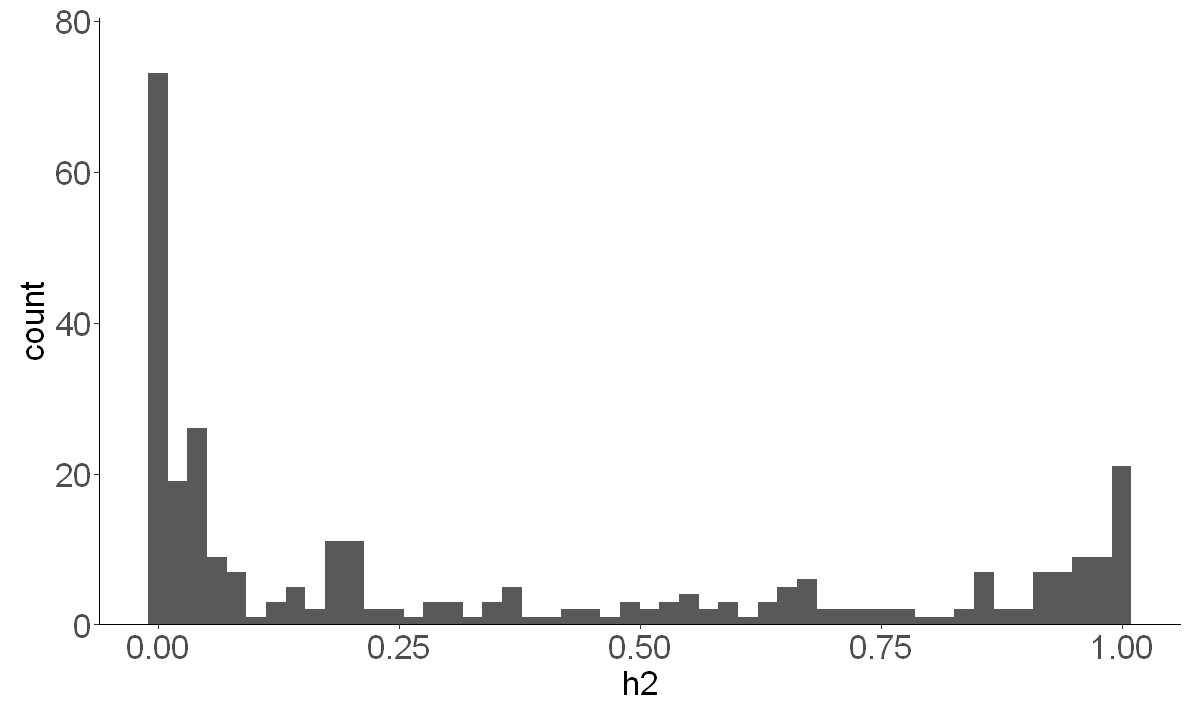

In [65]:
df_h2 %>% ggplot(aes(h2)) + geom_histogram(bins=50) + 
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))+
    theme_classic() +
    theme(axis.text.y = element_text(size = 20),
          axis.text.x = element_text(size = 20),
          axis.title = element_text(size = 20),
          axis.title.x  = element_text(size = 20),
          legend.text = element_text(size = 20),
          legend.title = element_text(size = 20),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

### rG

In [190]:
# GCTA input order
gcta_order <- read.csv('./Allchr.snp.final.recode.numChr.plink_out.gctaGRM.grm.id', sep='\t', header = F)
gcta_order <- gcta_order %>% .[c('V2')] %>% setNames(c('GenoID')) 
gcta_order %>% tail

GenoID  
378 ZGH0758N
379 ZGH0759N
380 ZGH0761N
381 ZGH0762N
382 ZGH0763N
383 ZGH0764N

In [169]:
# geno pheno id
geno_pheno <- read.xlsx('../383群体ID.xlsx') %>% setNames(c('ID', 'GenoID'))

In [192]:
# generate a test file
gcta_order %>% 
merge(geno_pheno, by='GenoID') %>% 
mutate(familyid = 0) %>% 
.[c('familyid', 'GenoID', 'ID')] %>% 
merge(df_blup, by = 'ID', all.x =T) %>% 
.[match(gcta_order$GenoID, .$GenoID), ] %>% 
select(-ID) %>% # whole GCTA input
.[, 1:4] %>% 
write.table('./rG.test.txt', col.names=F, row.names =F, quote=F)

In [193]:
# generate entire file
gcta_order %>% 
merge(geno_pheno, by='GenoID') %>% 
mutate(familyid = 0) %>% 
.[c('familyid', 'GenoID', 'ID')] %>% 
merge(df_blup, by = 'ID', all.x =T) %>% 
.[match(gcta_order$GenoID, .$GenoID), ] %>% 
select(-ID) %>% # whole GCTA input
write.table('./rG.entire.txt', col.names=F, row.names =F, quote=F)

#### generate bash scripts to run in parallel

In [237]:
slice <- seq(1, 681, 20)
for (i in 1:(length(slice) - 1)){
    if (slice[i] == 661) {
        start = slice[i]
        end = start + 20
#         print(paste(start, end))        
    }else{
        start = slice[i]
        end = start + 19
#         print(paste(start, end))
    }
    tmp = readLines('./scripts/raw.sh')
    tmp = gsub('START', start, tmp)
    tmp = gsub('END', end, tmp)
    writeLines(tmp, paste0('./scripts/slice_', start, '_', end, '.sh'))
}

In [221]:
# generate scripts
tmp = readLines('./scripts//raw.sh')
tmp = gsub('START', '12', tmp)
tmp = gsub('END', '123', tmp)
writeLines(tmp, './scripts//test.sh')


Warning message in readLines("./scripts//raw.sh"):
"incomplete final line found on './scripts//raw.sh'"


### Tidyup rG results

In [8]:
df_blup <- read.csv('all_blup.14Dec2022.csv')

In [9]:
df_rg <- read.table('./extract_rG.result.tab', sep = '\t', header = F, skip = 1) %>% 
    setNames(c('Fname', 'Type', 'rG', 'SE'))

In [10]:
df_rg[c('Trait_idx_1', 'Trait_idx_2')] <- df_rg$Fname %>% gsub('.hsq', '', .) %>% str_split_fixed('_',  n=6) %>% .[,c(4, 6)]
triat_vec <- colnames(df_blup) %>% .[3:length(.)]

In [11]:
df_trait_class <- pheno_sum %>% 
    mutate(TraitID = paste0(Trait, '_', Treatment)) %>% 
    .[c('性状分类1', 'TraitID')] %>% 
    distinct()

#### Heatmap

Loading required package: pheatmap

Warning message:
"package 'pheatmap' was built under R version 4.2.2"


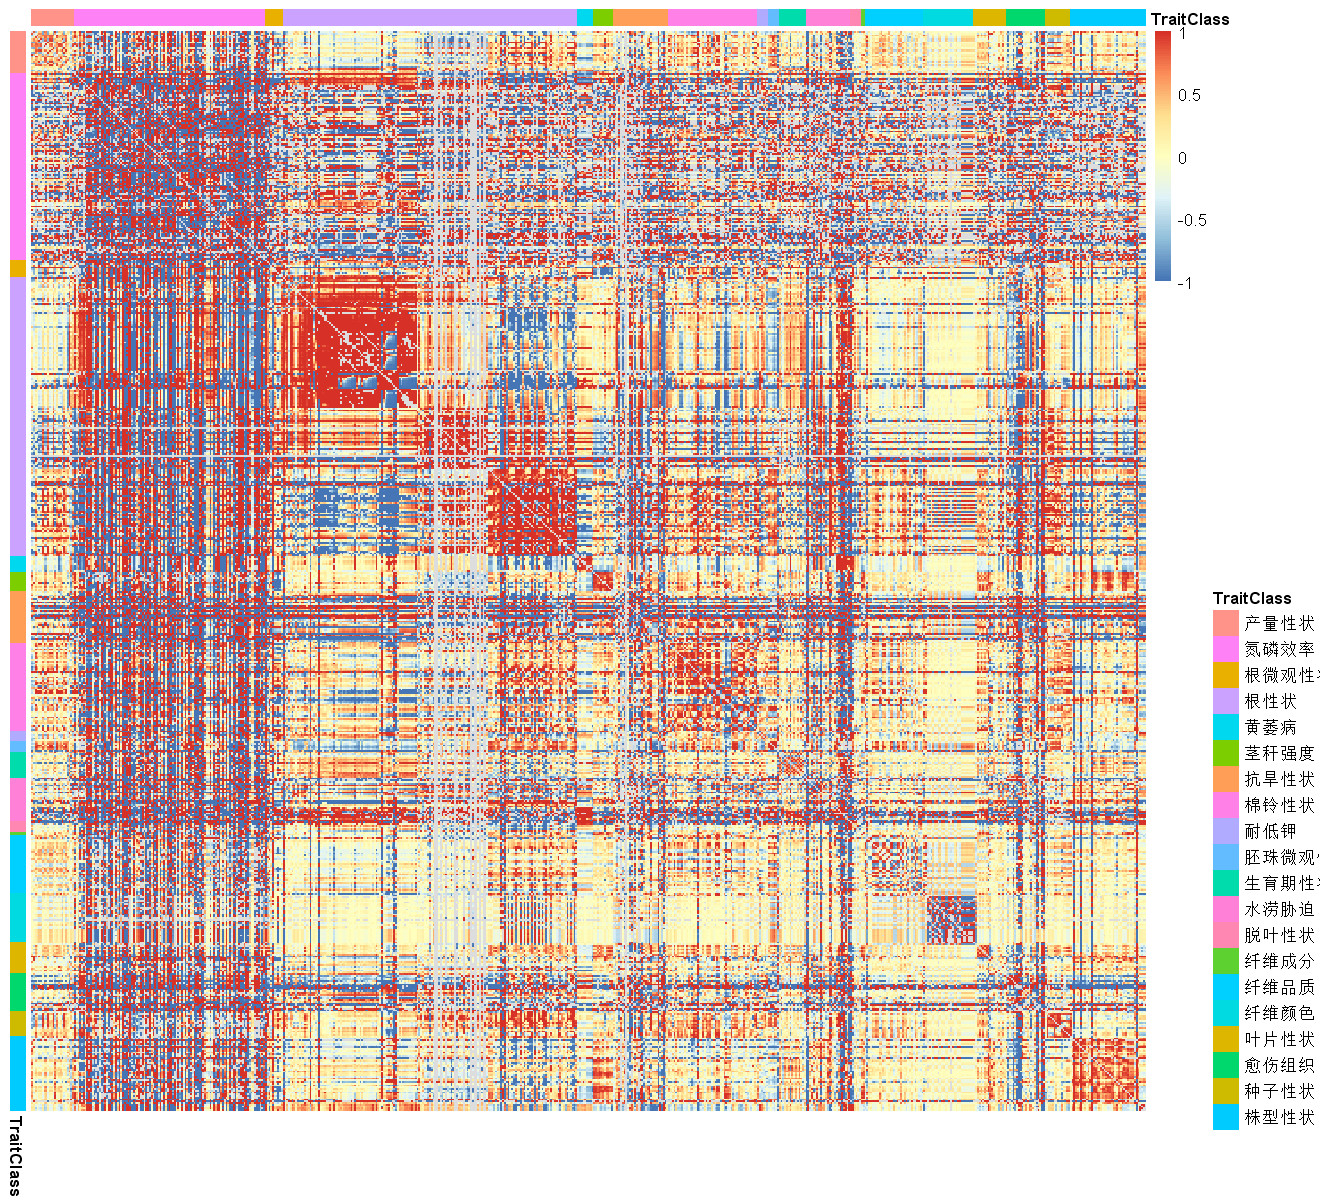

In [12]:
# generate heatmap input
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
# subset(Trait_idx_1 < Trait_idx_2) %>% # 去除重复数据
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 11, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 fontsize = 10,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rG_matrix, df_trait_class)

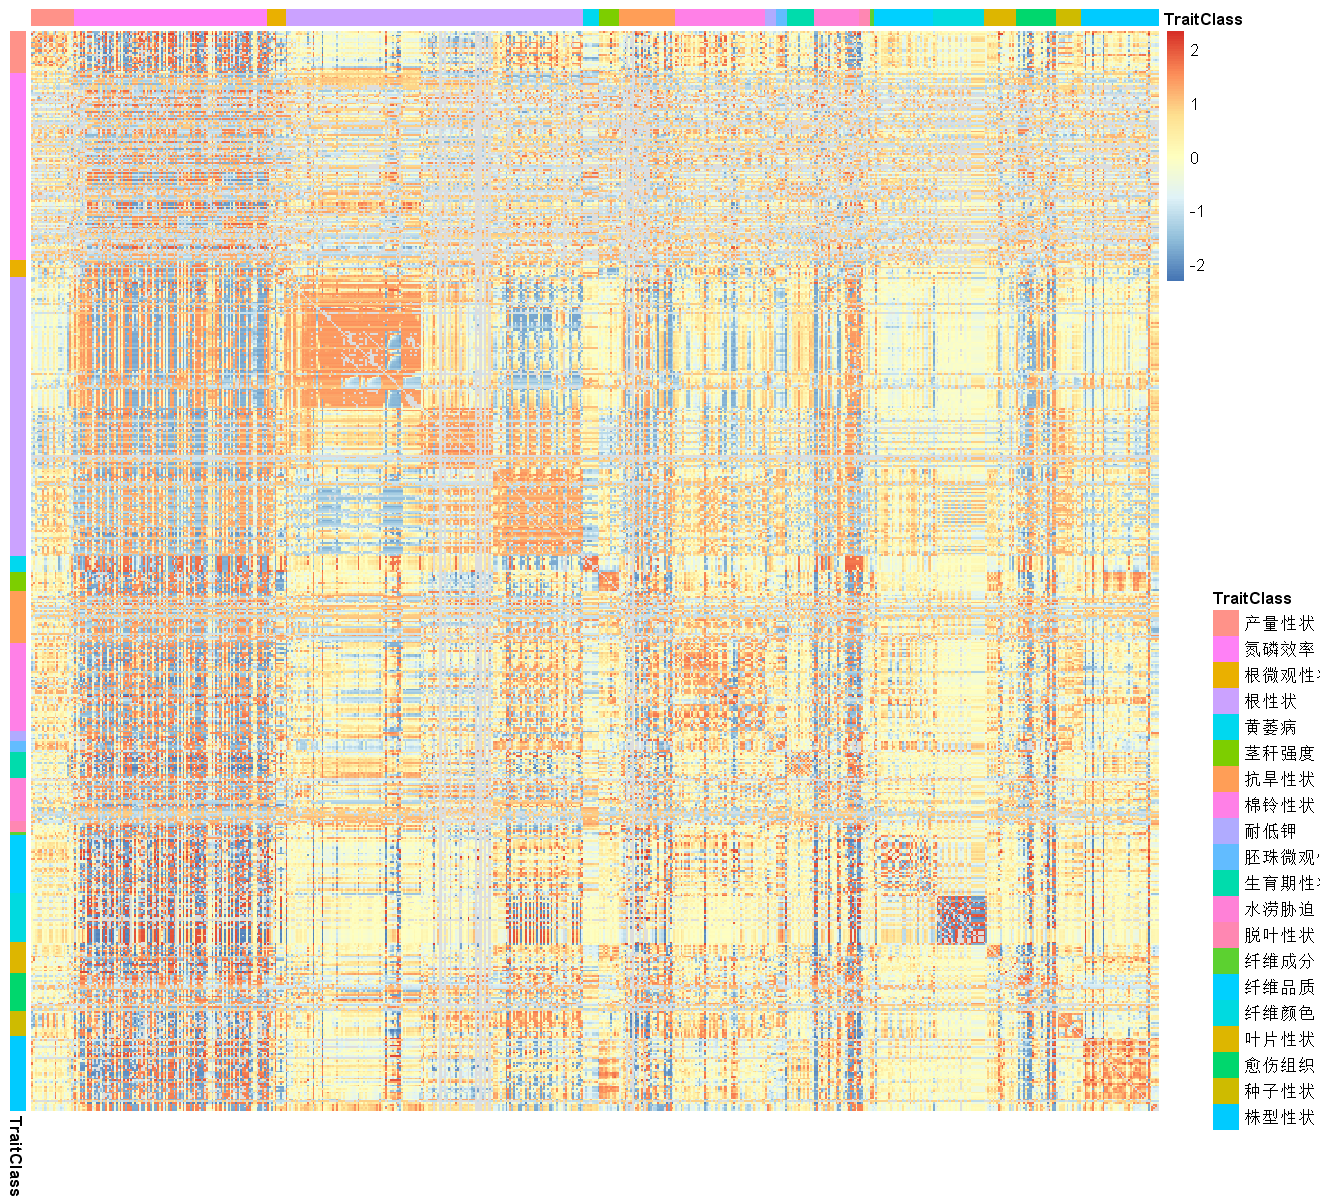

In [13]:
# generate heatmap input
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
# subset(Trait_idx_1 < Trait_idx_2) %>% # 去除重复数据
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 11, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(scale = 'row',
                cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 fontsize = 10,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rG_matrix, df_trait_class)

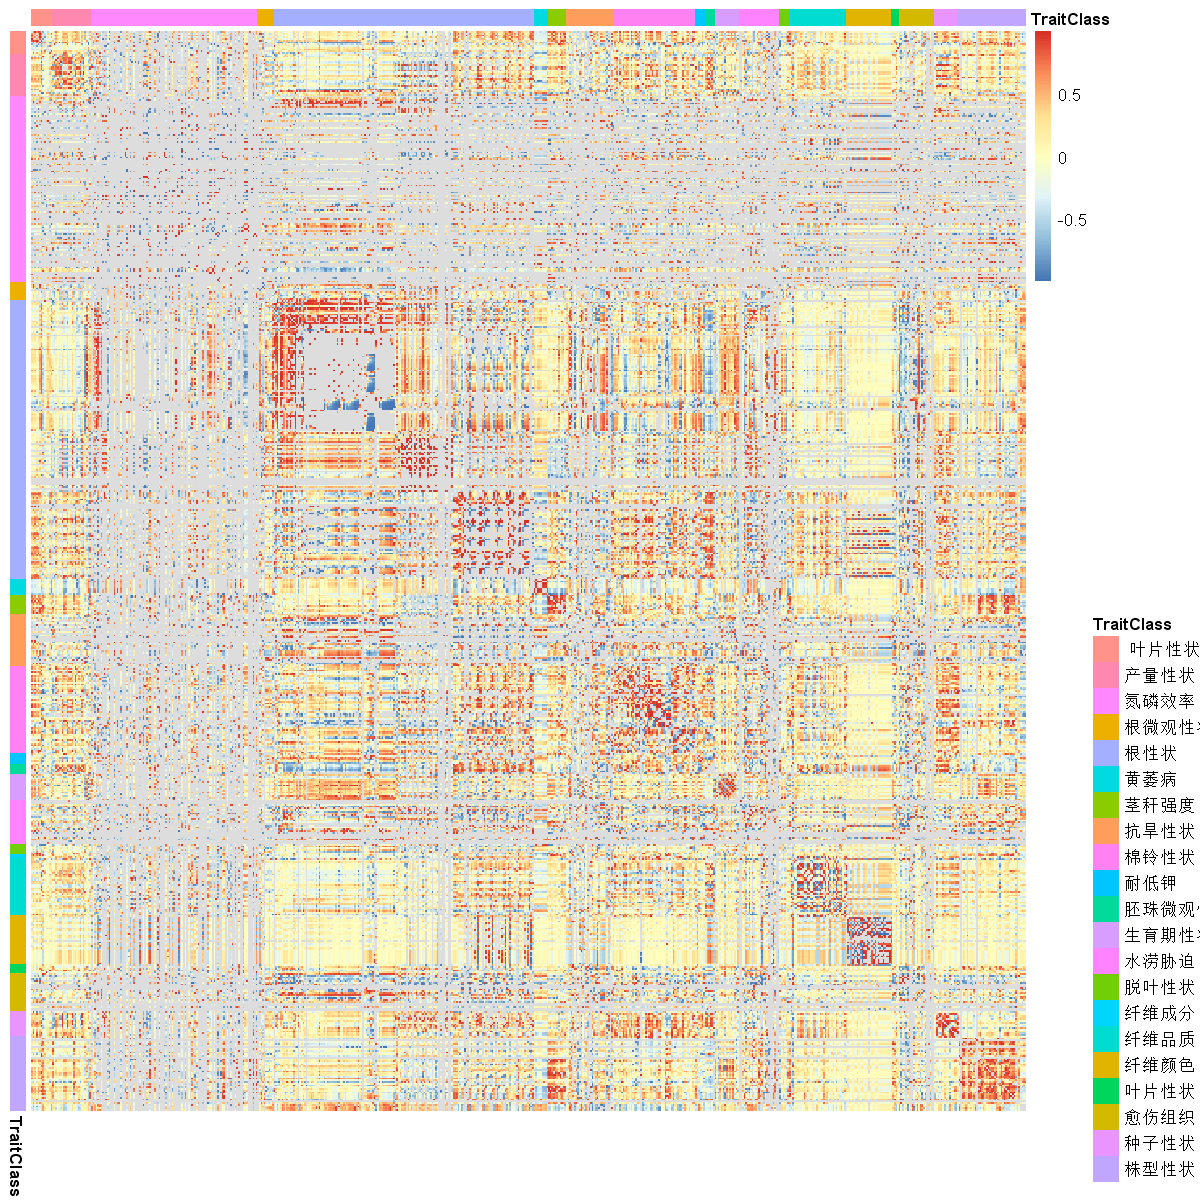

In [177]:
# generate heatmap input remove the +-1 results
df_rg %>% 
subset(rG != 1 & rG != -1) %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
# subset(Trait_idx_1 < Trait_idx_2) %>% # 去除重复数据
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 10, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 fontsize = 10,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rG_matrix, df_trait_class)

#### rG for disease traits

In [24]:
df_trait_class$性状分类1 %>% unique

[1] "纤维品质"     "纤维颜色"     "纤维成分"     "产量性状"     "株型性状"    
 [6] "生育期性状"   "叶片性状"     "棉铃性状"     "种子性状"     "根性状"      
[11] "根微观性状"   "胚珠微观性状" "愈伤组织"     "茎秆强度"     "抗旱性状"    
[16] "氮磷效率"     "耐低钾"       "黄萎病"       "脱叶性状"     "水涝胁迫"

In [22]:
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
merge(df_trait_class, by.x = 'Trait1', by.y = 'TraitID') %>% 
setNames(c(colnames(.)[1:(ncol(.)-1)], 'Trait_class_1')) %>% 
merge(df_trait_class, by.x = 'Trait2', by.y = 'TraitID') %>% 
setNames(c(colnames(.)[1:(ncol(.)-1)], 'Trait_class_2')) -> data

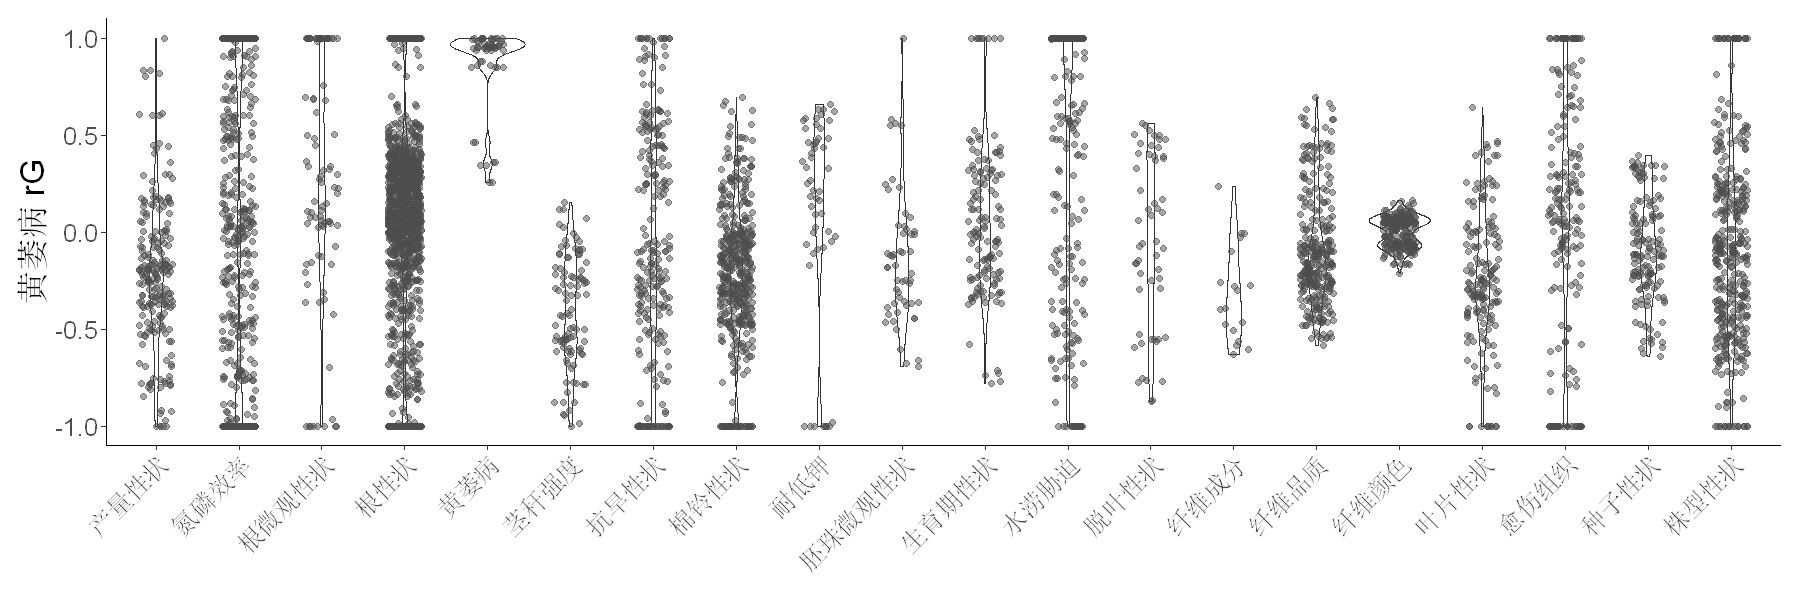

In [41]:
options(repr.plot.width = 15, repr.plot.height = 5)
data %>% 
subset(Trait_class_1 == '黄萎病') %>% 
ggplot(aes(x=Trait_class_2, y=rG)) + 
    geom_violin() + 
    geom_jitter(width = 0.2, alpha = 0.5, color = 'grey30')+
    ylab('黄萎病 rG') +
    theme_classic() +
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 45, hjust=1, vjust=1),
          axis.title = element_text(size = 20),
          axis.title.x  = element_blank(),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 15),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

In [45]:
# remove +-1 results
plot_rG <- function(data, TRAIT){
    options(repr.plot.width = 15, repr.plot.height = 5)
    data %>% 
    subset(Trait_class_1 == TRAIT) %>% 
    subset(rG != 1 & rG != -1) %>% 
    ggplot(aes(x=Trait_class_2, y=rG)) + 
        geom_violin() + 
        geom_jitter(width = 0.2, alpha = 0.5, color = 'grey30')+
        xlab(paste(TRAIT, 'vs 以上性状类别')) +
        theme_classic() +
        theme(axis.text.y = element_text(size = 15),
              axis.text.x = element_text(size = 15, angle = 45, hjust=1, vjust=1),
              axis.title = element_text(size = 20),
              axis.title.x  = element_text(size = 20),
              legend.text = element_text(size = 15),
              legend.title = element_text(size = 15),
              plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm')) -> p
    return(p)
}

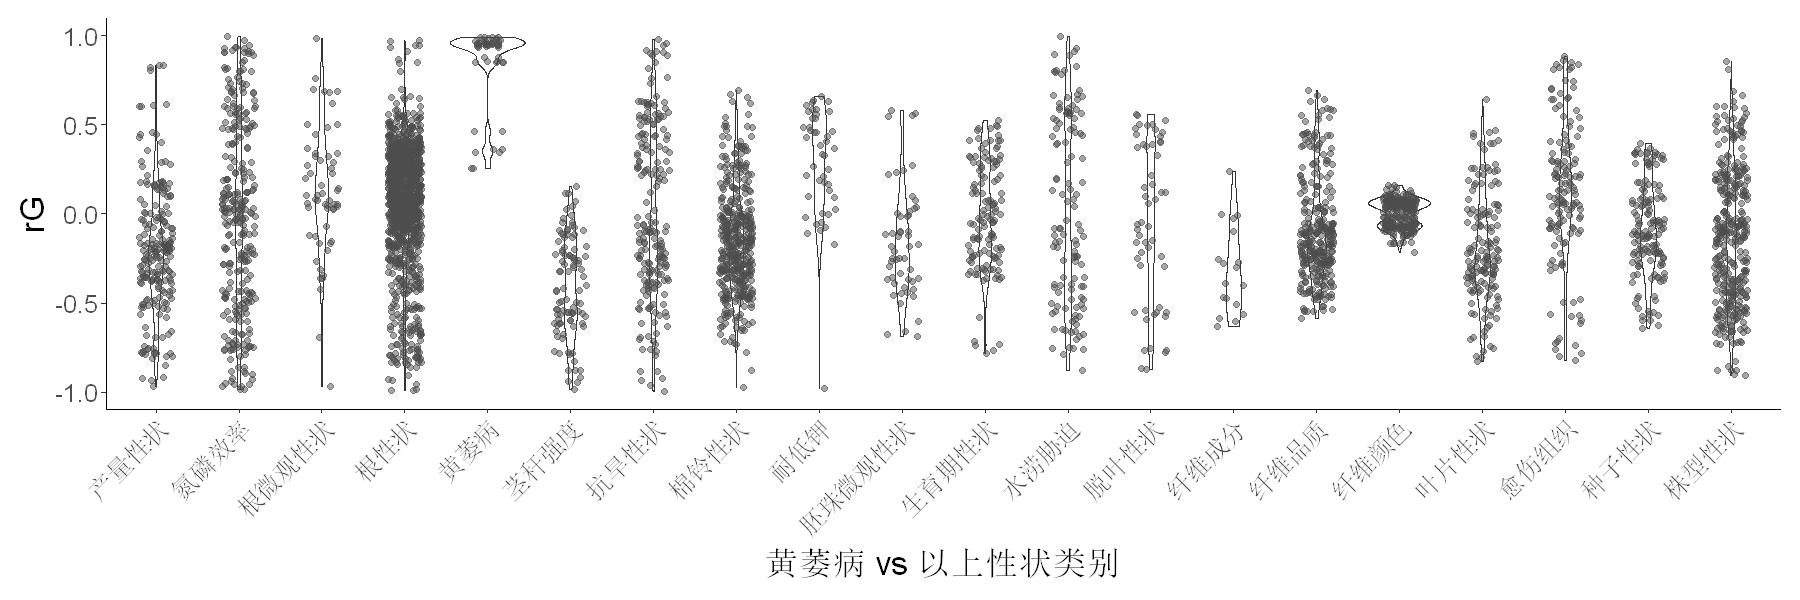

In [46]:
plot_rG(data, '黄萎病')

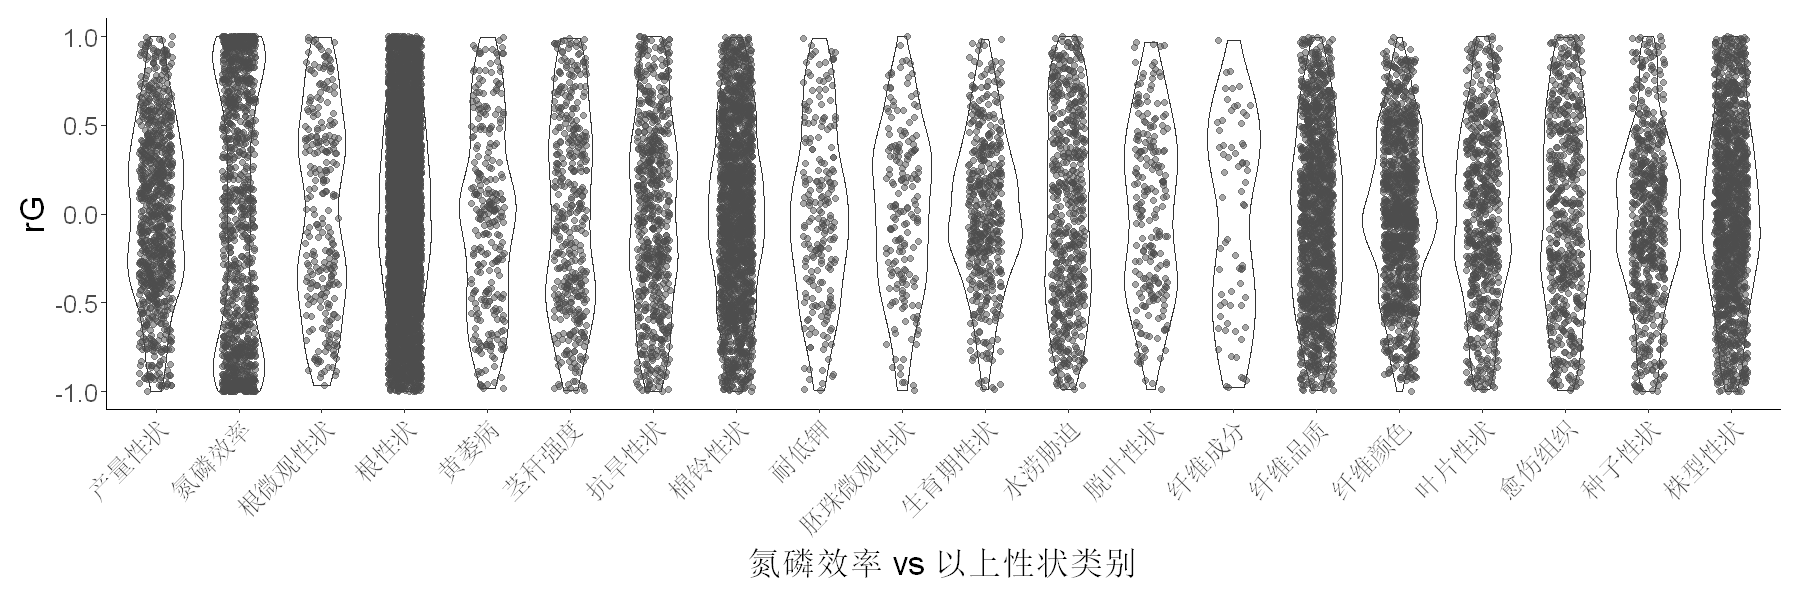

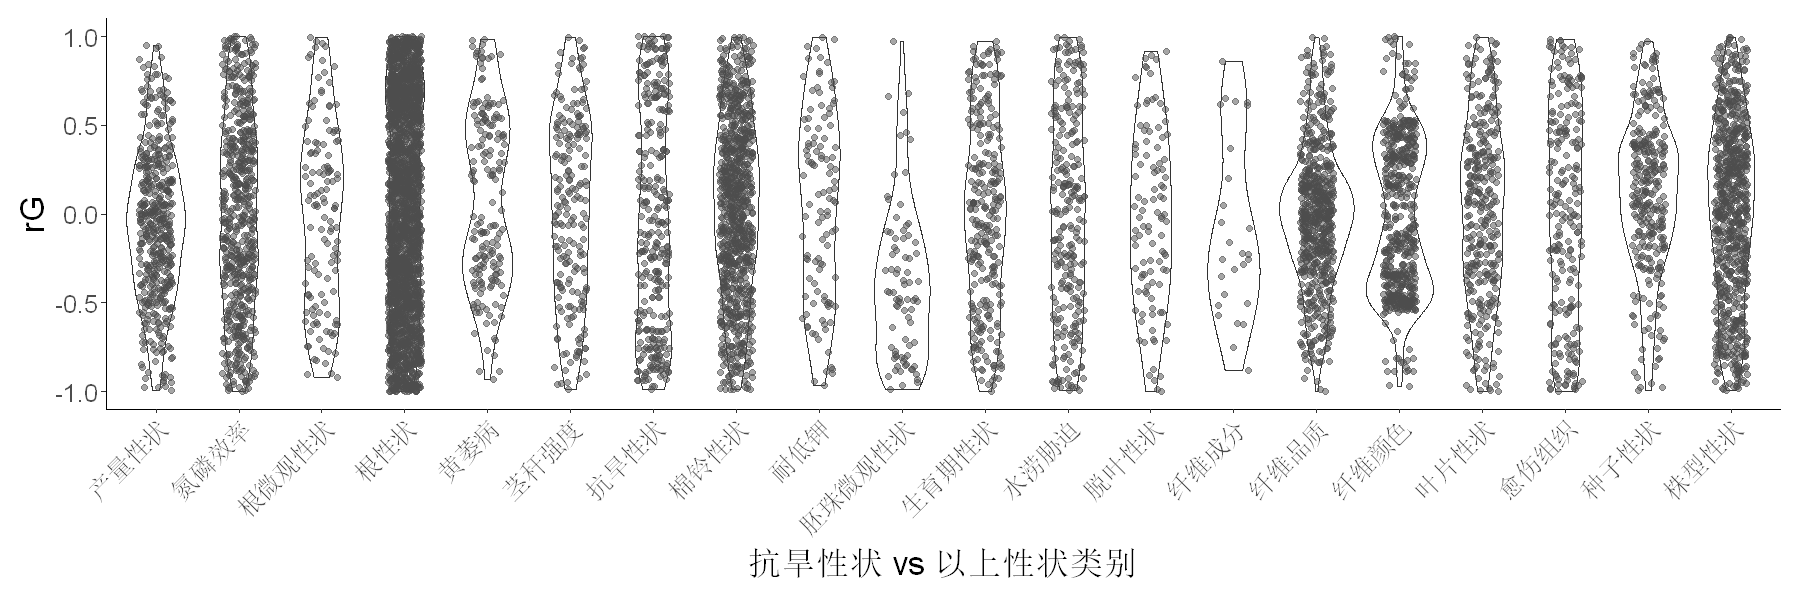

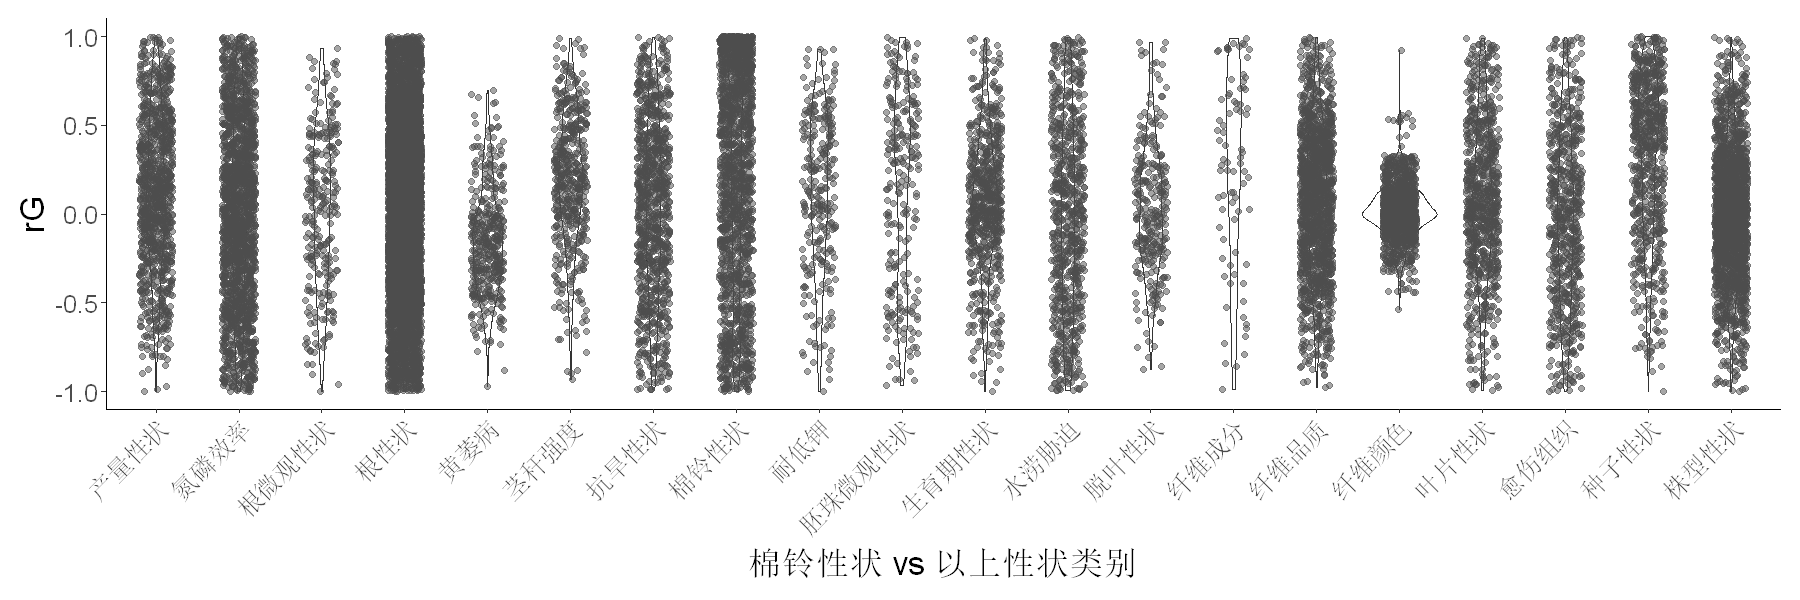

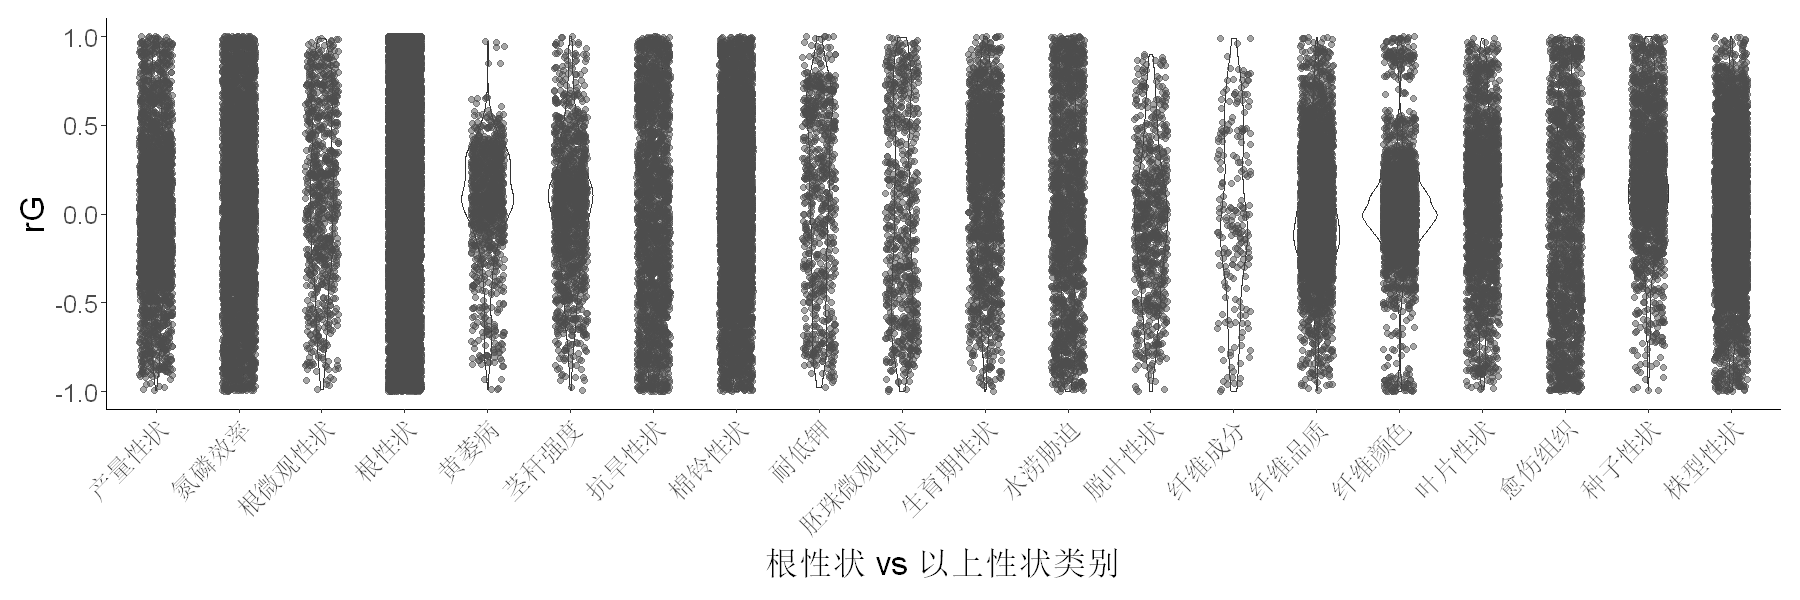

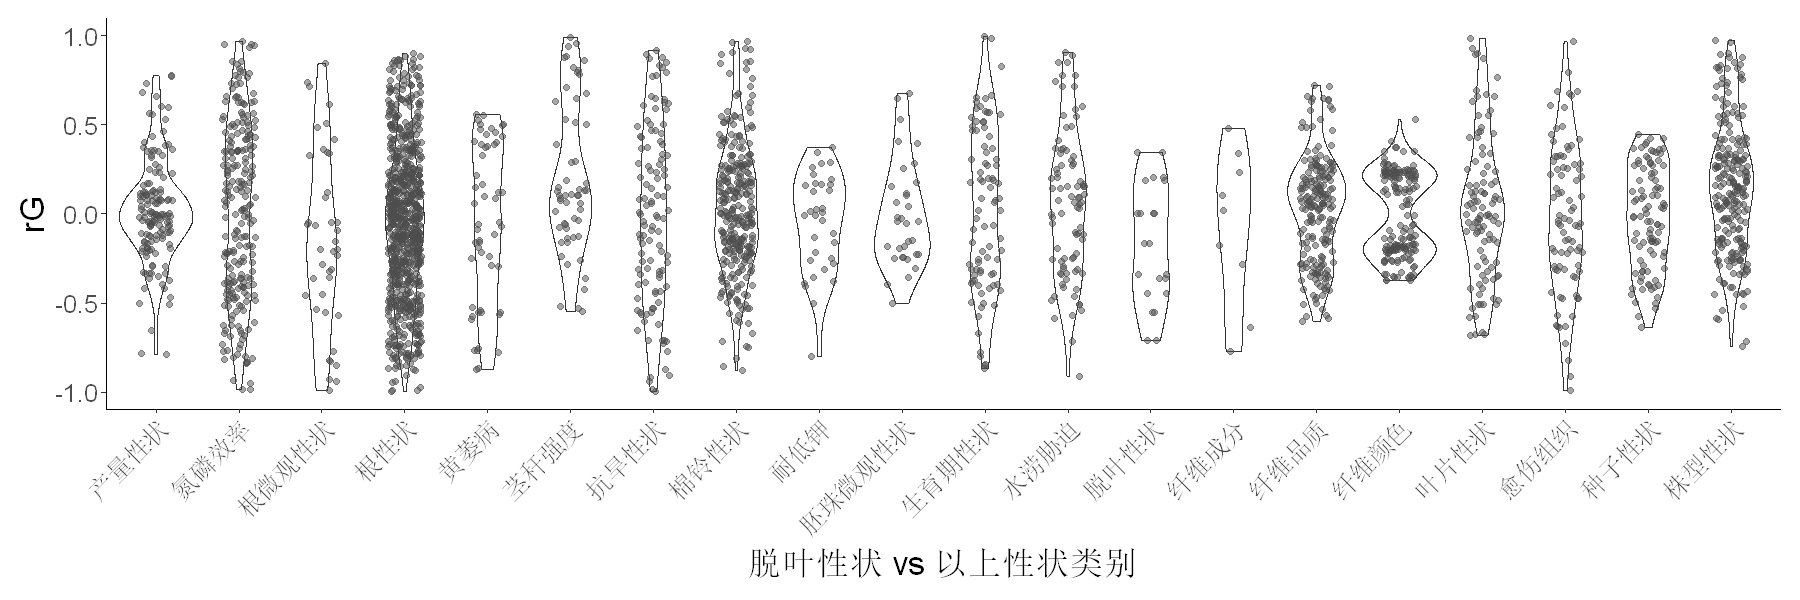

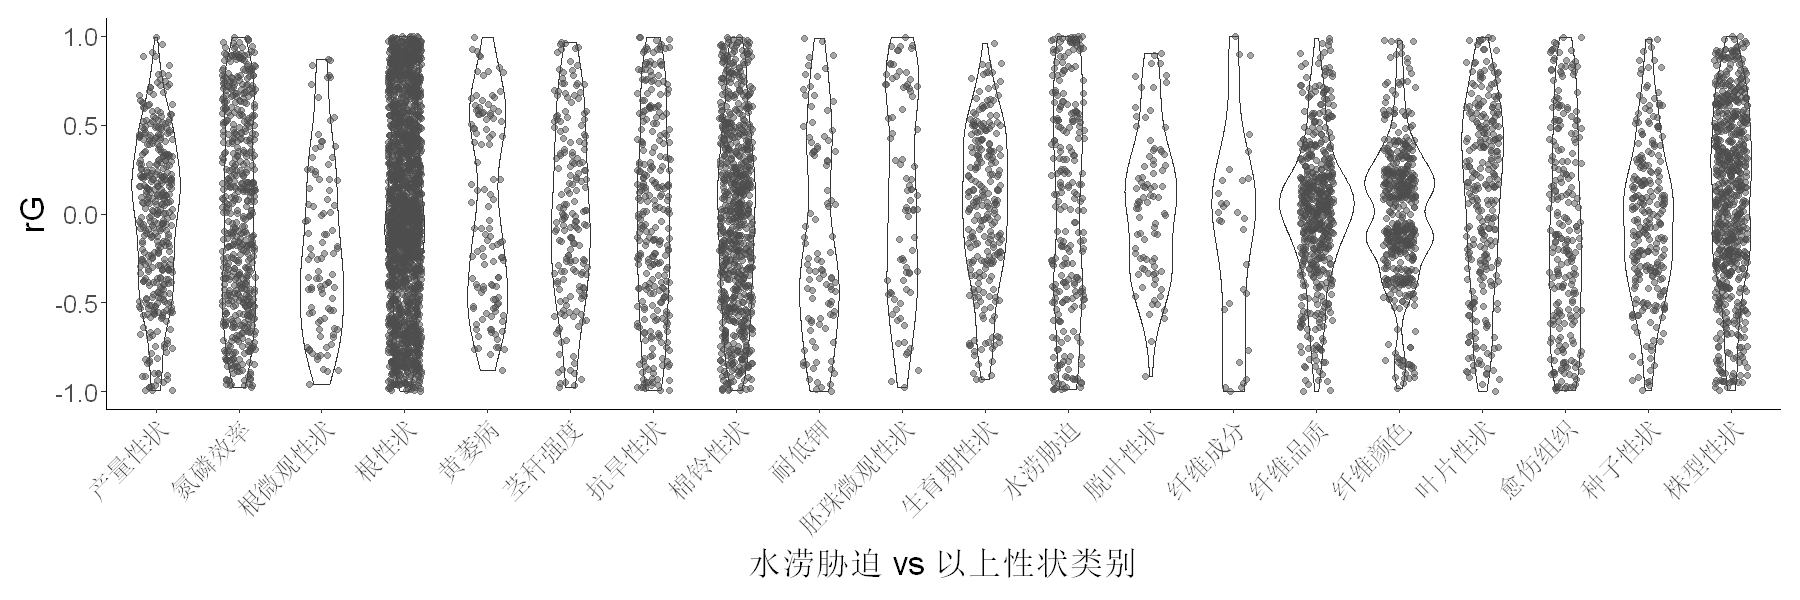

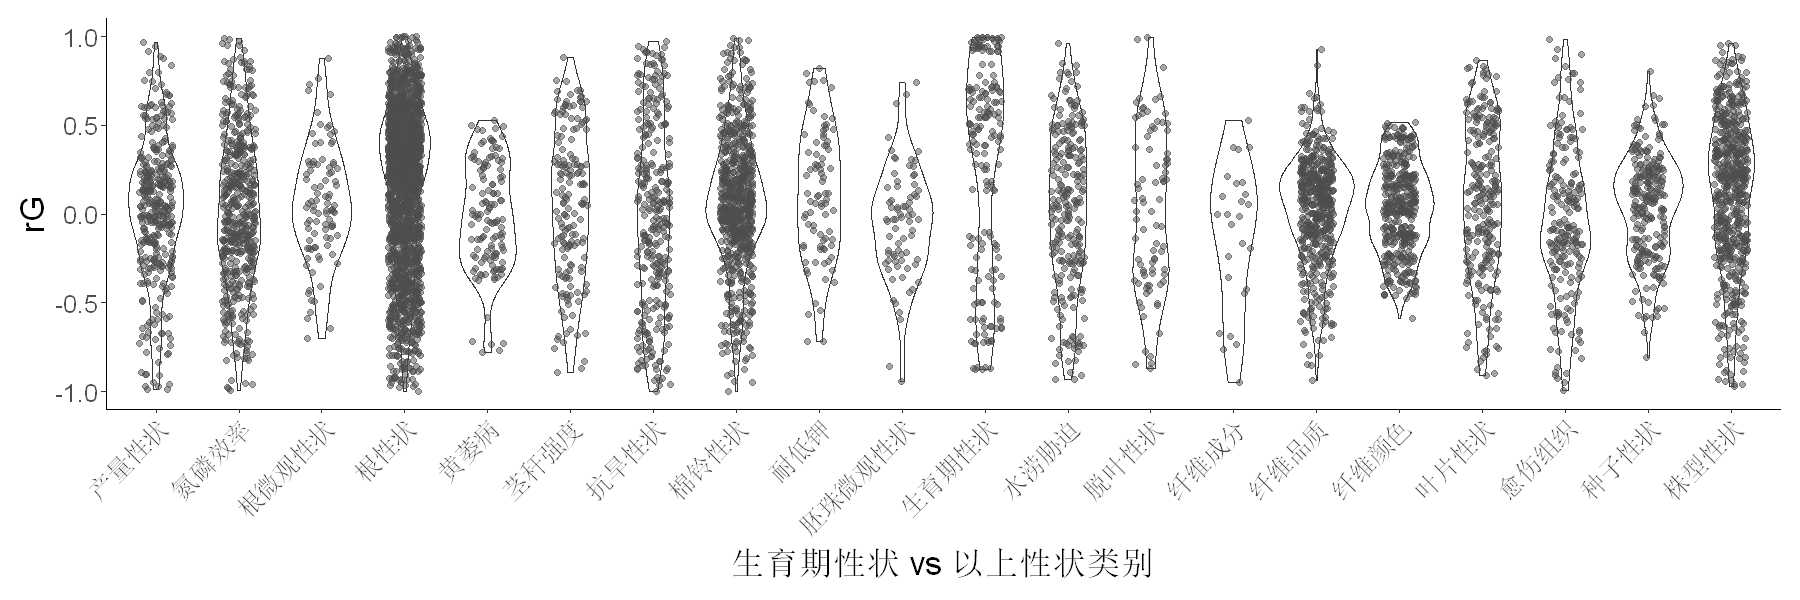

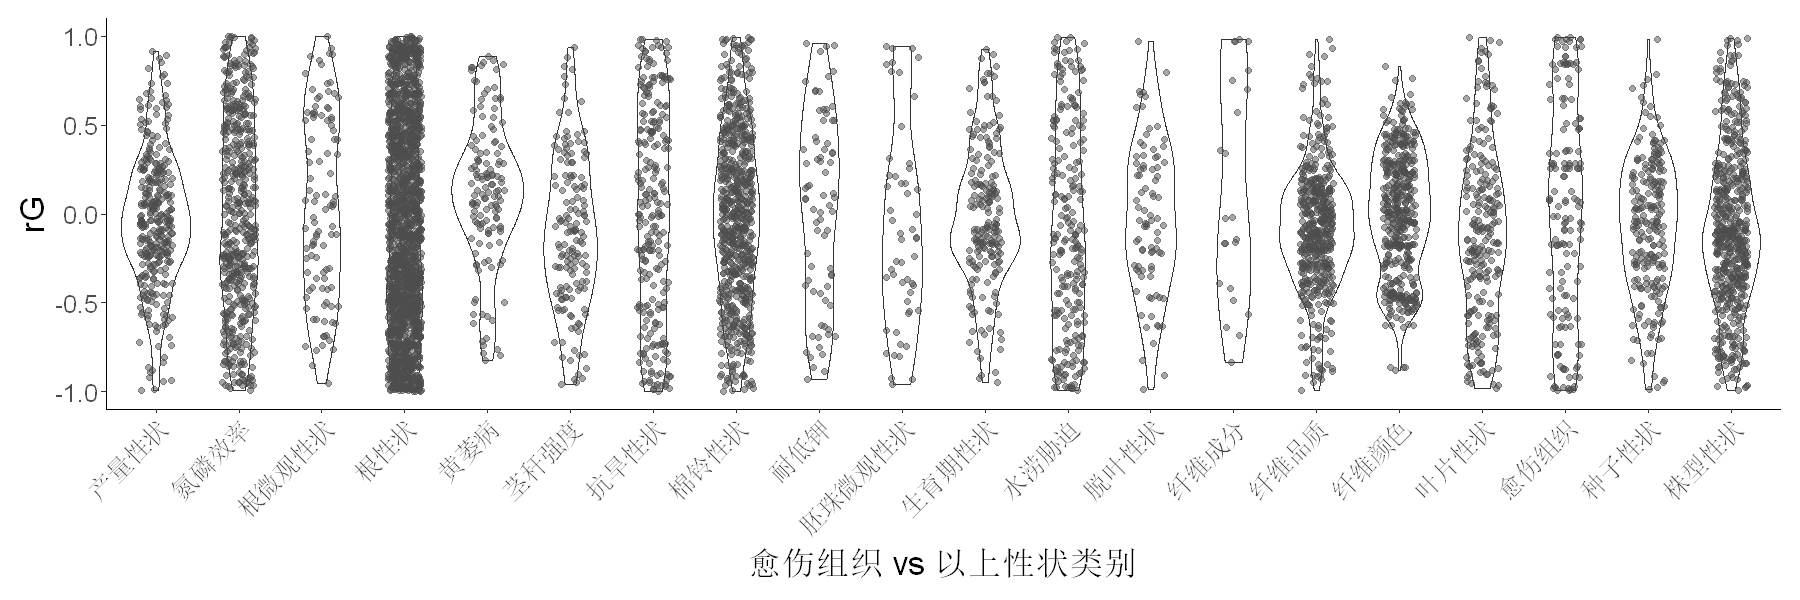

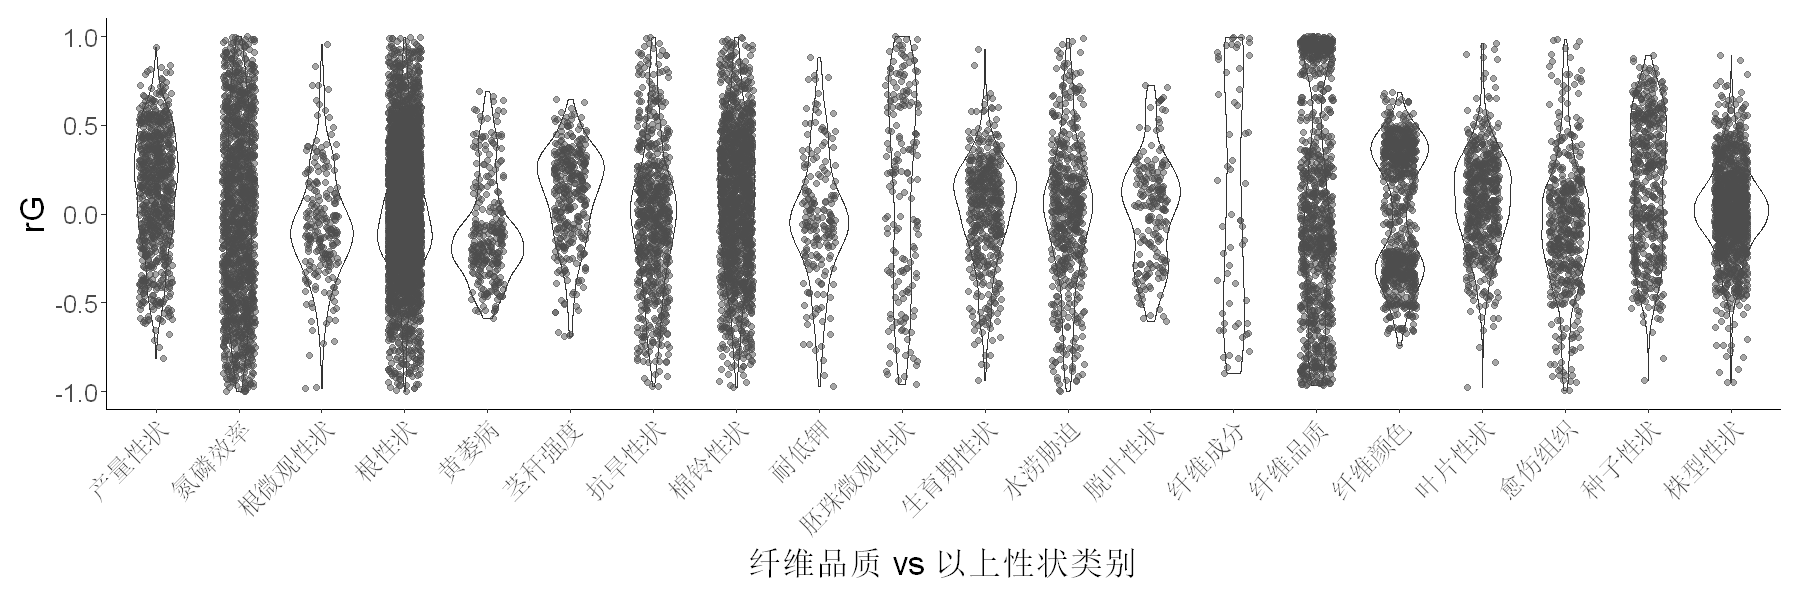

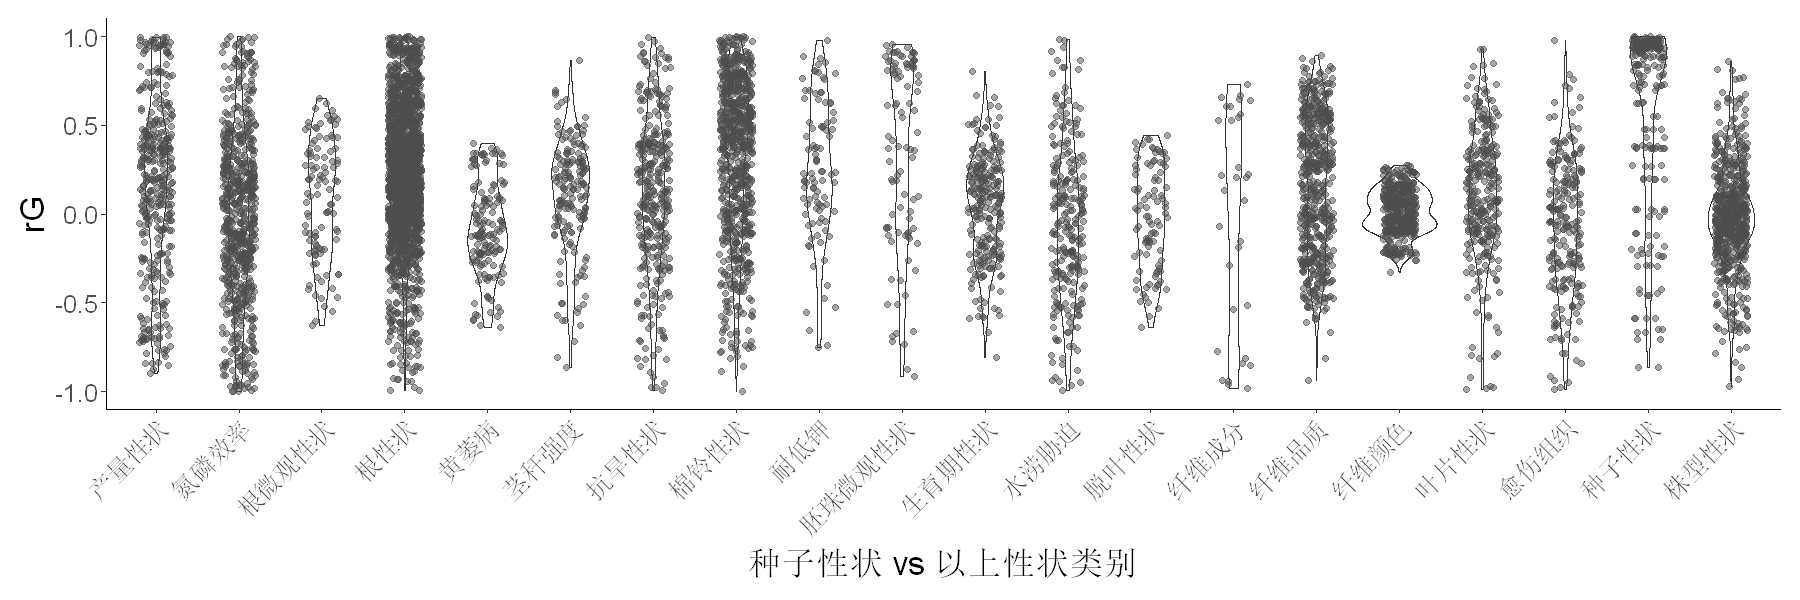

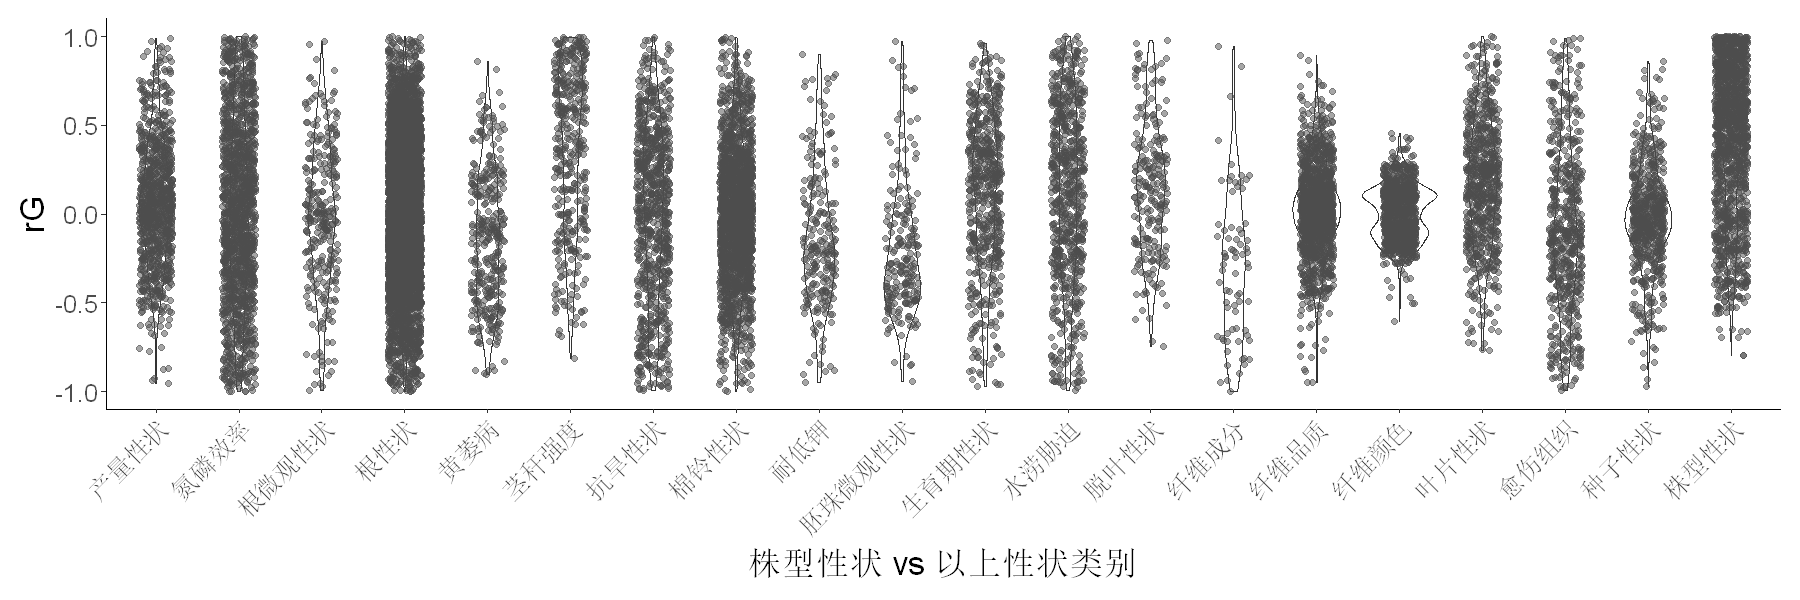

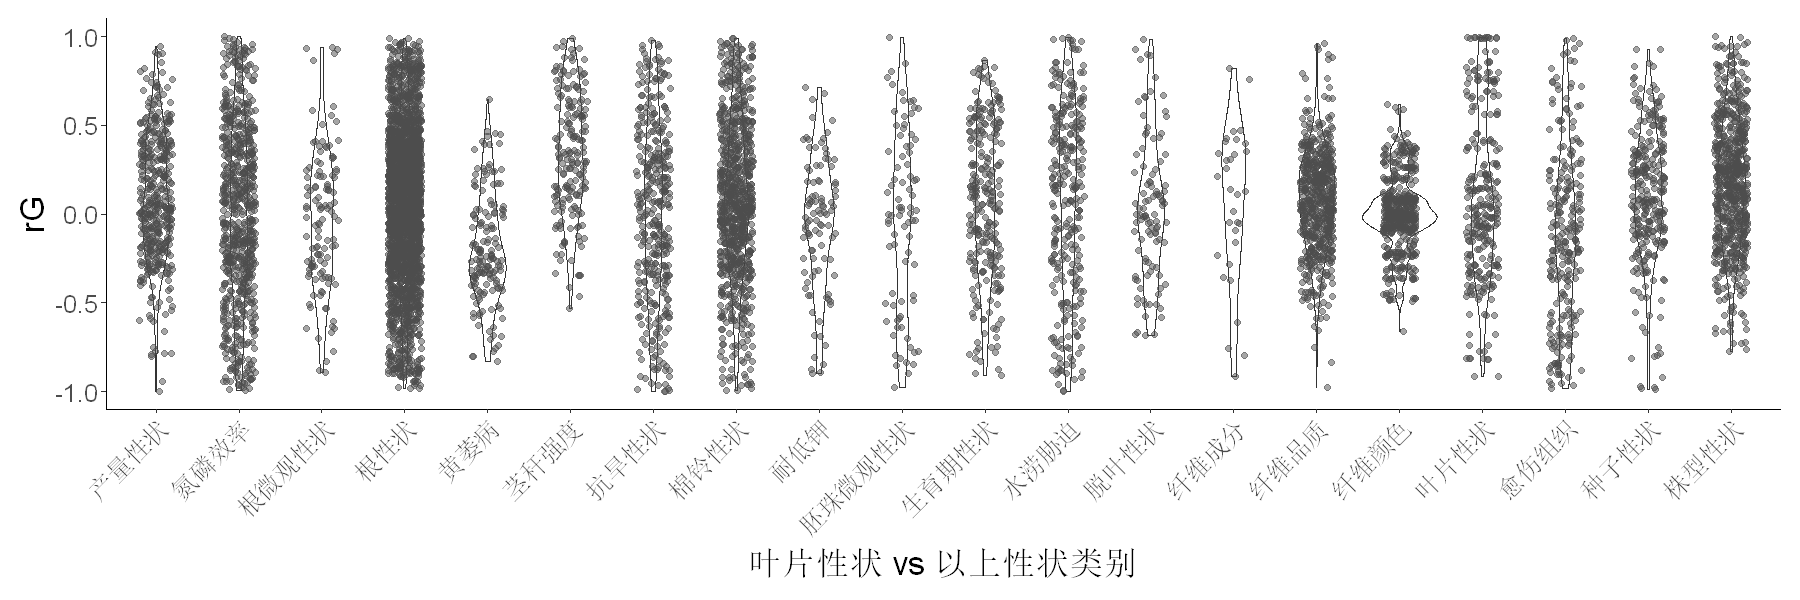

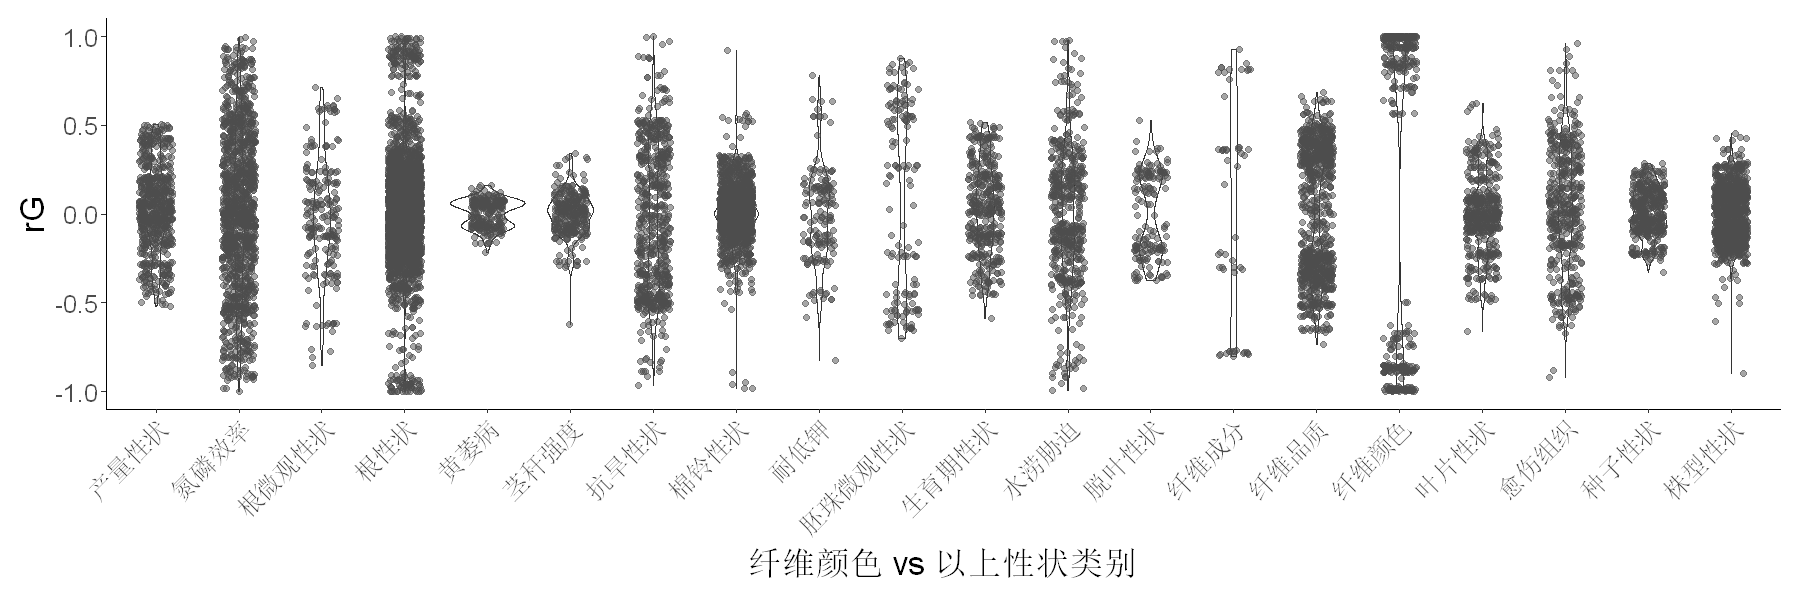

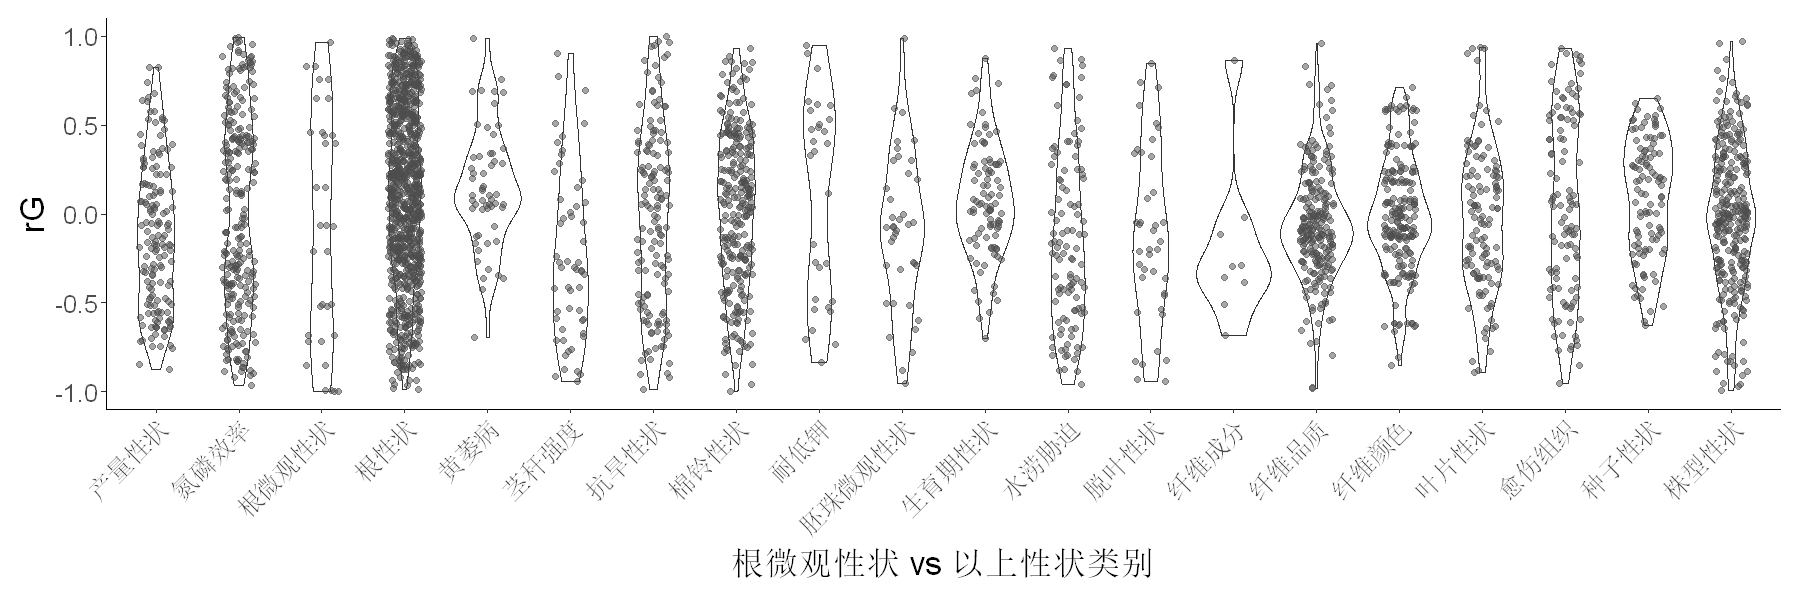

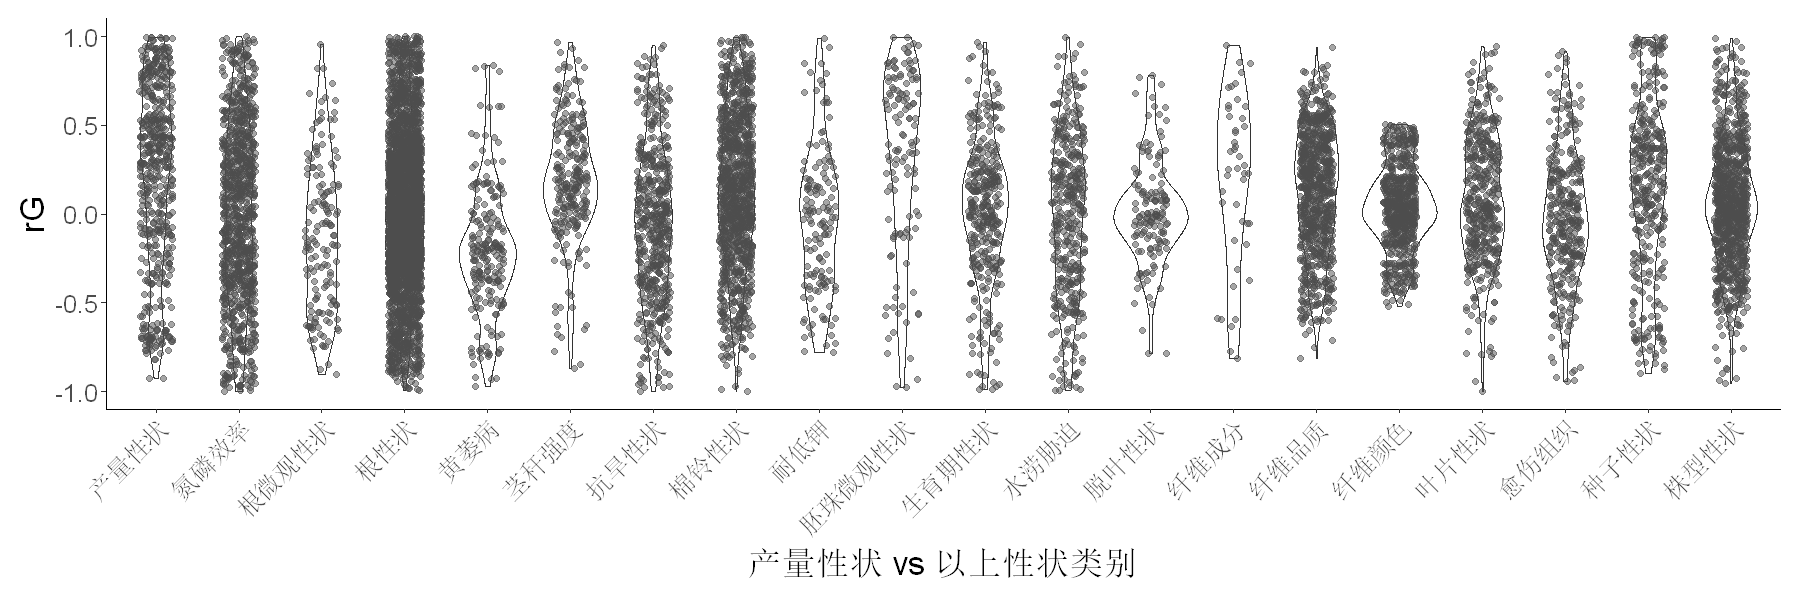

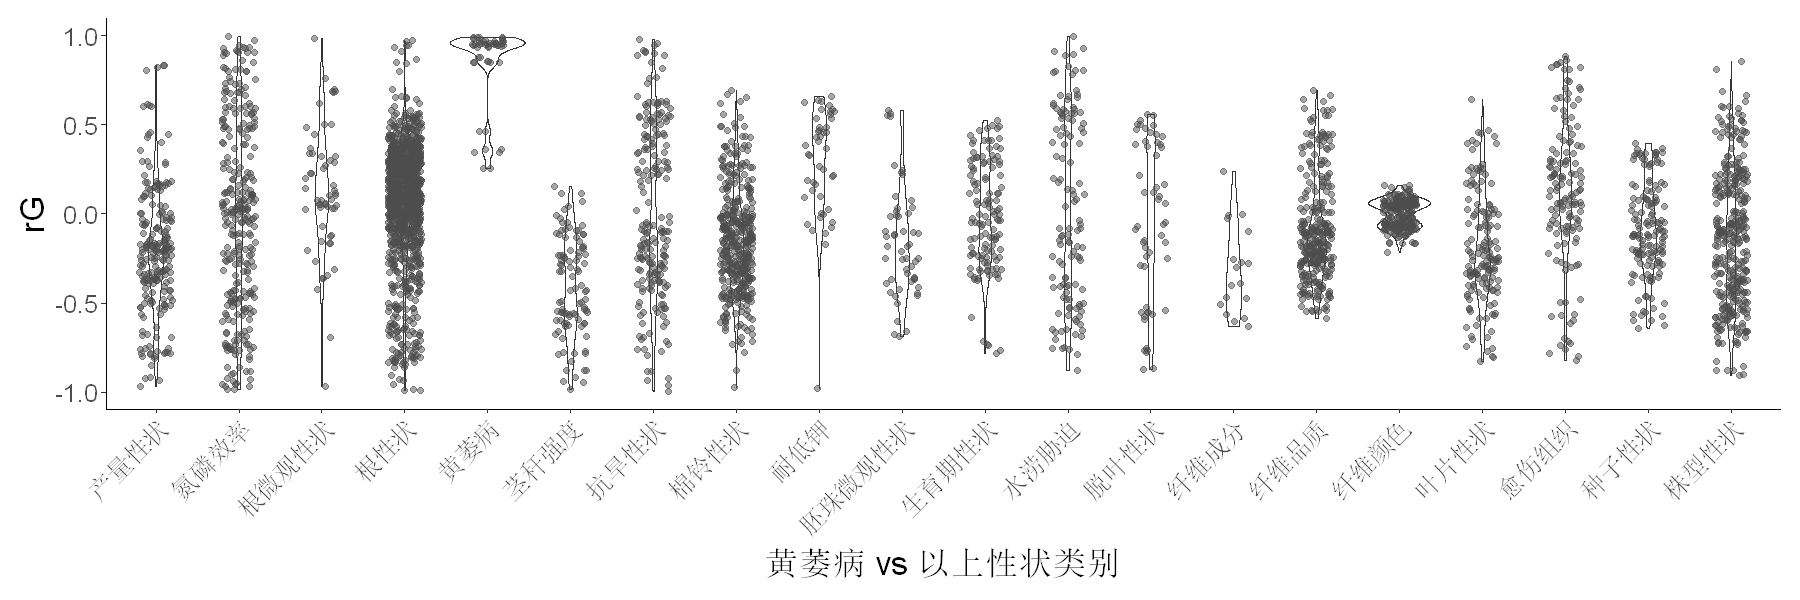

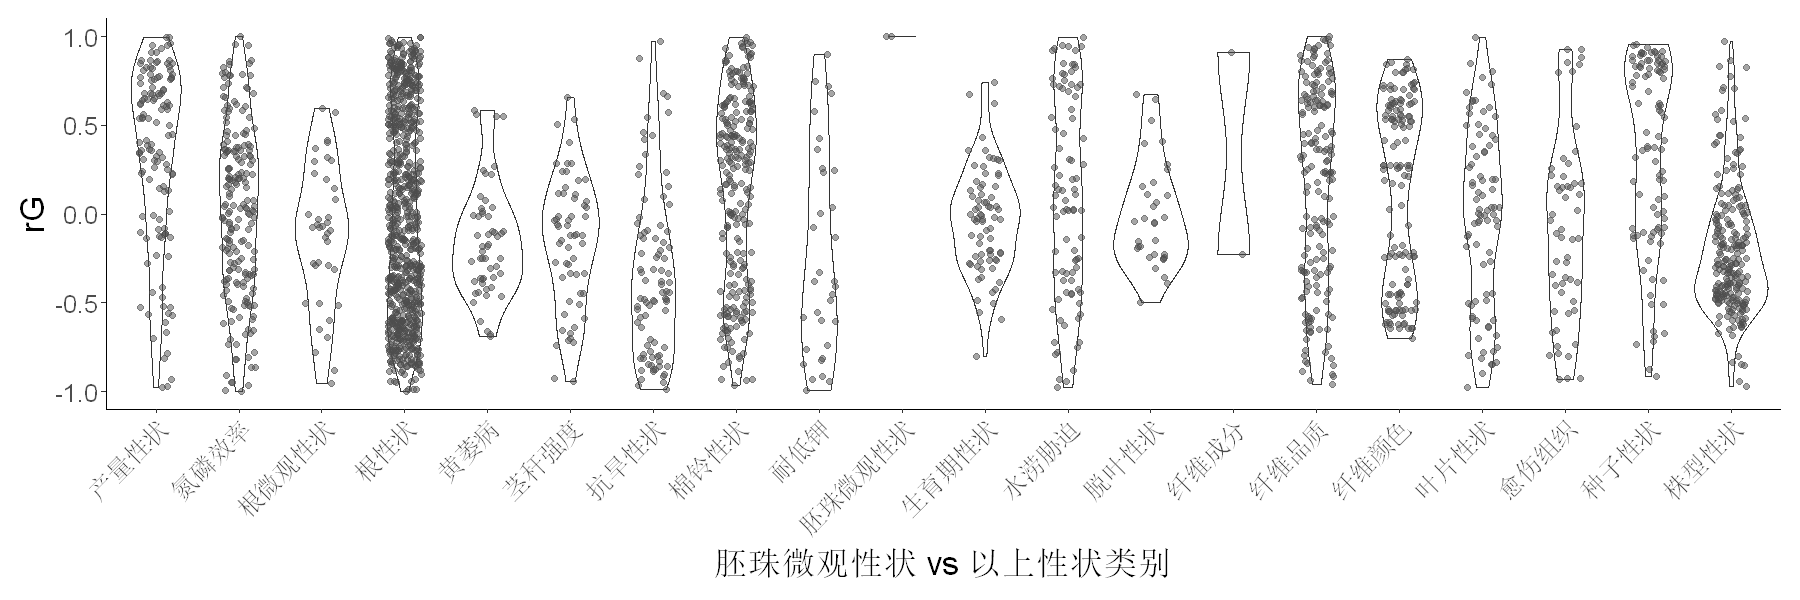

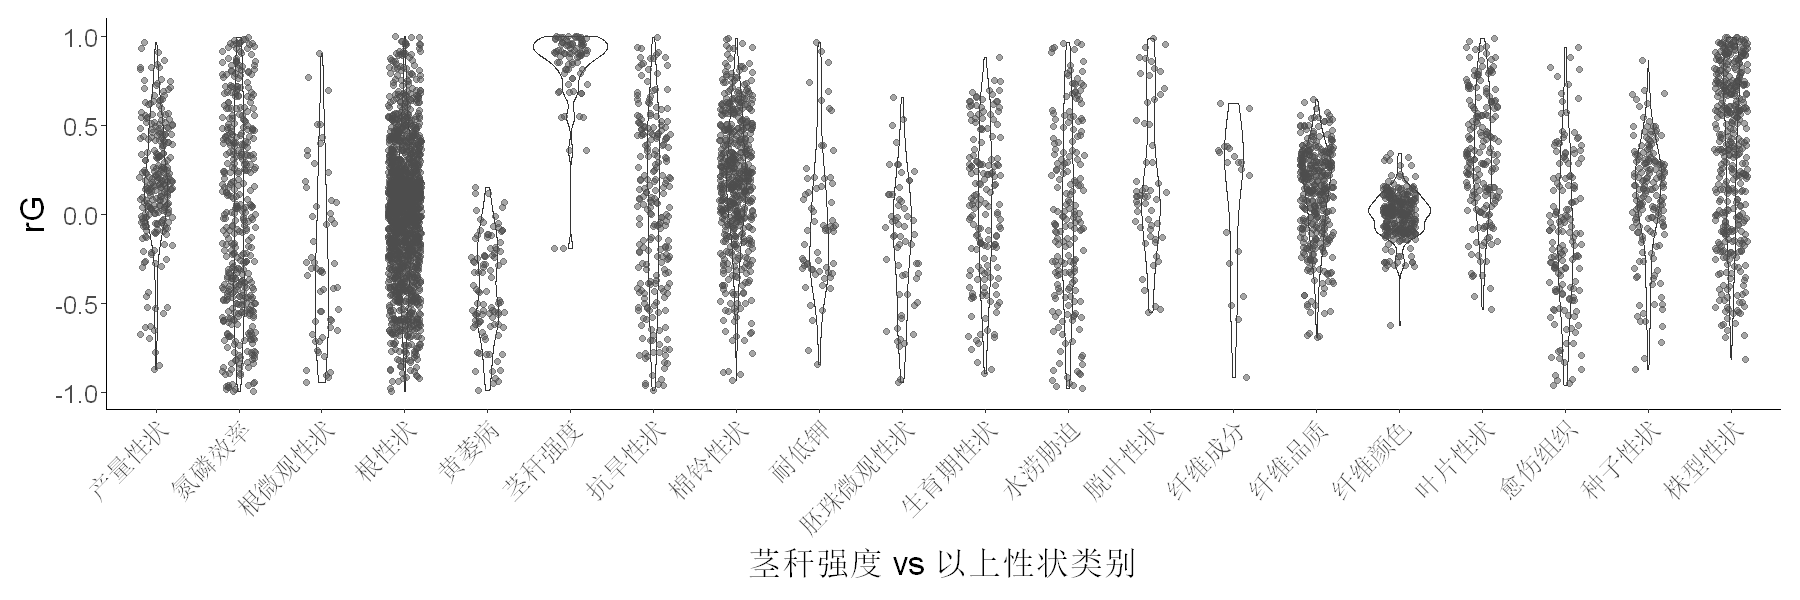

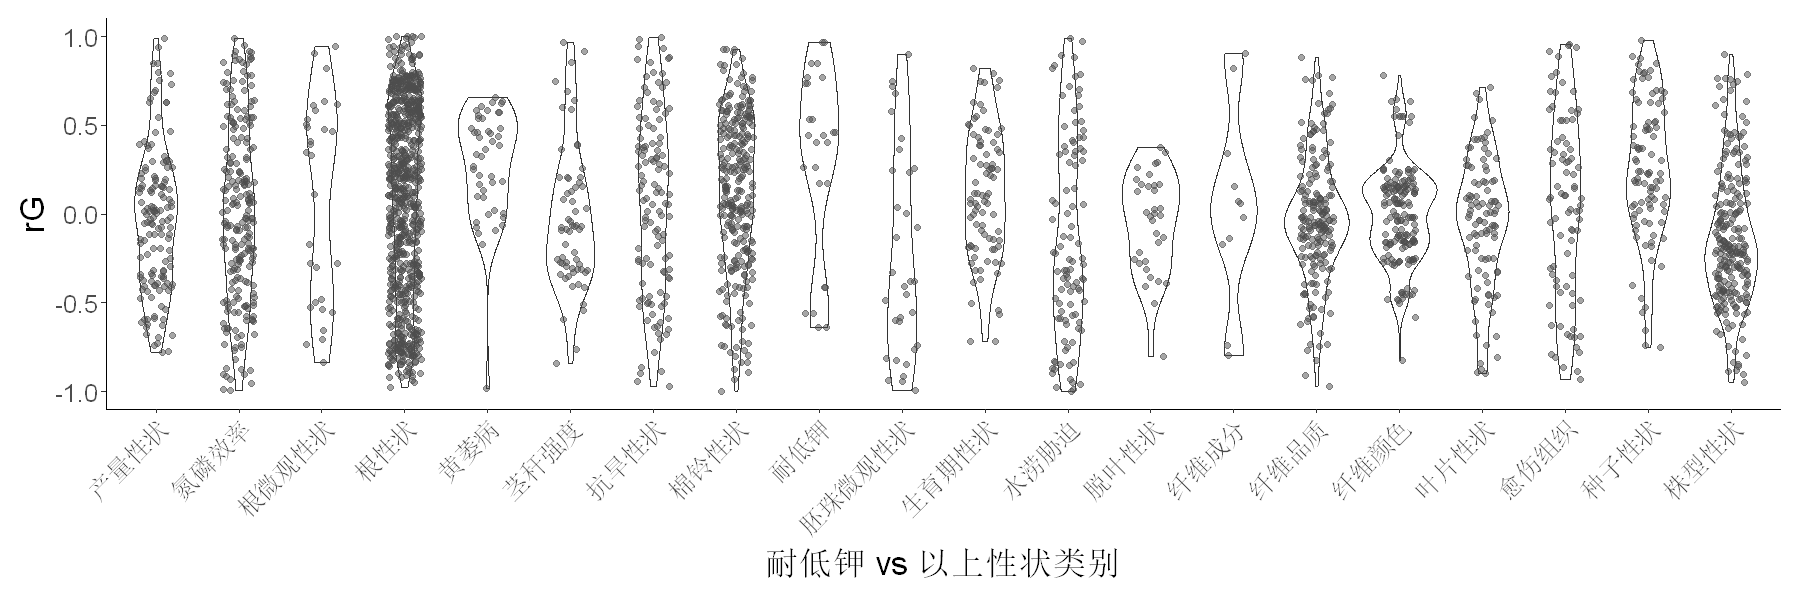

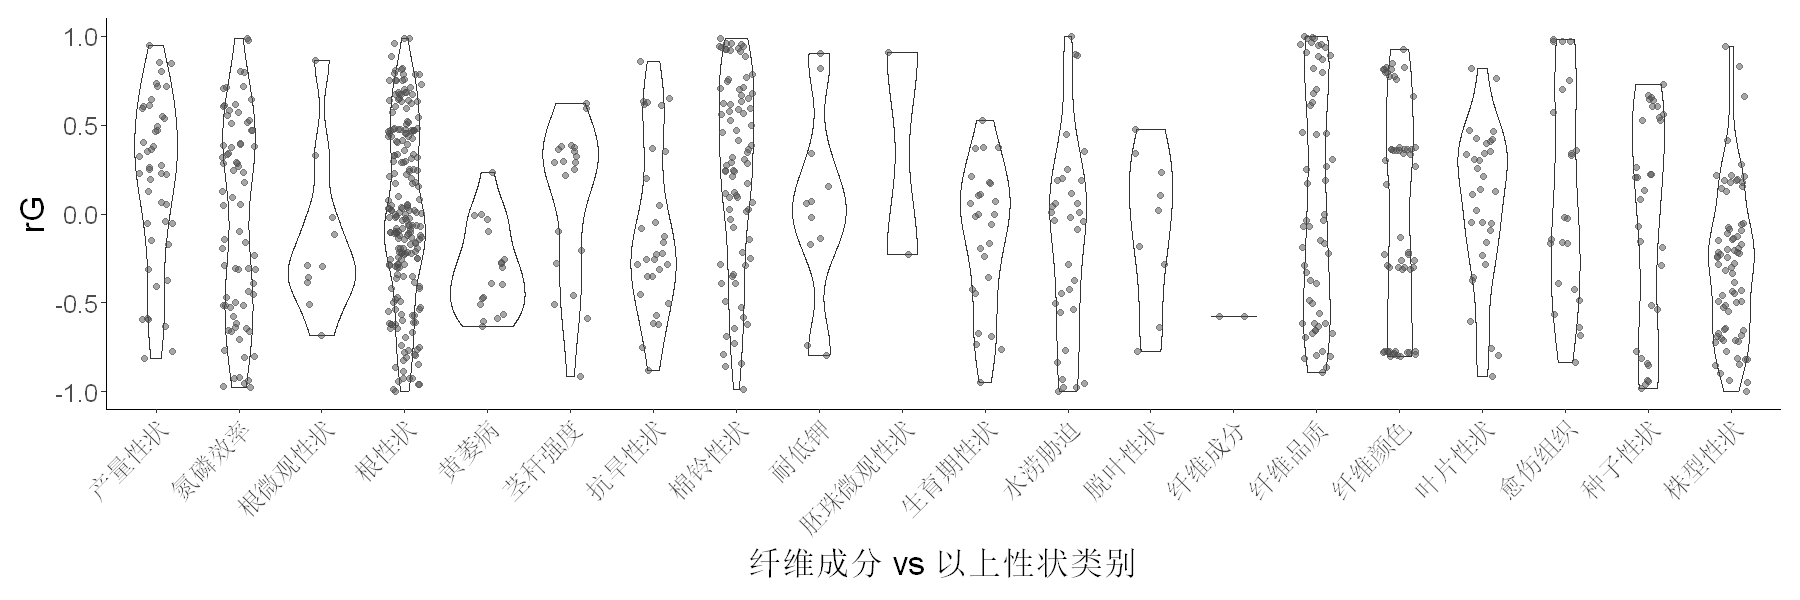

In [49]:
for (i in data$Trait_class_1 %>% unique){
    p <- plot_rG(data, i)
    print(p)
}

In [50]:
# keep +-1 results
plot_rG <- function(data, TRAIT){
    options(repr.plot.width = 15, repr.plot.height = 5)
    data %>% 
    subset(Trait_class_1 == TRAIT) %>% 
#     subset(rG != 1 & rG != -1) %>% 
    ggplot(aes(x=Trait_class_2, y=rG)) + 
        geom_violin() + 
        geom_jitter(width = 0.2, alpha = 0.5, color = 'grey30')+
        xlab(paste(TRAIT, 'vs 以上性状类别')) +
        theme_classic() +
        theme(axis.text.y = element_text(size = 15),
              axis.text.x = element_text(size = 15, angle = 45, hjust=1, vjust=1),
              axis.title = element_text(size = 20),
              axis.title.x  = element_text(size = 20),
              legend.text = element_text(size = 15),
              legend.title = element_text(size = 15),
              plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm')) -> p
    return(p)
}

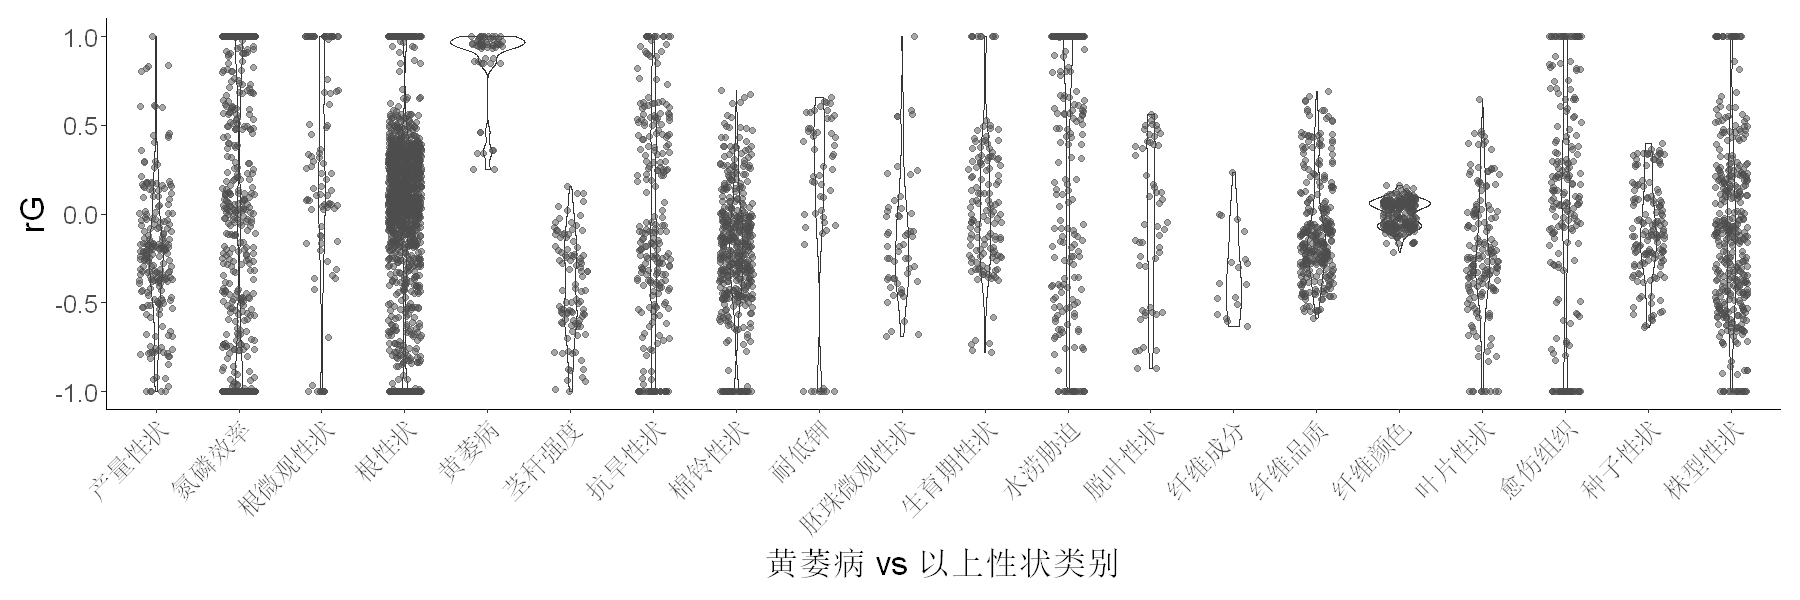

In [51]:
plot_rG(data, '黄萎病')

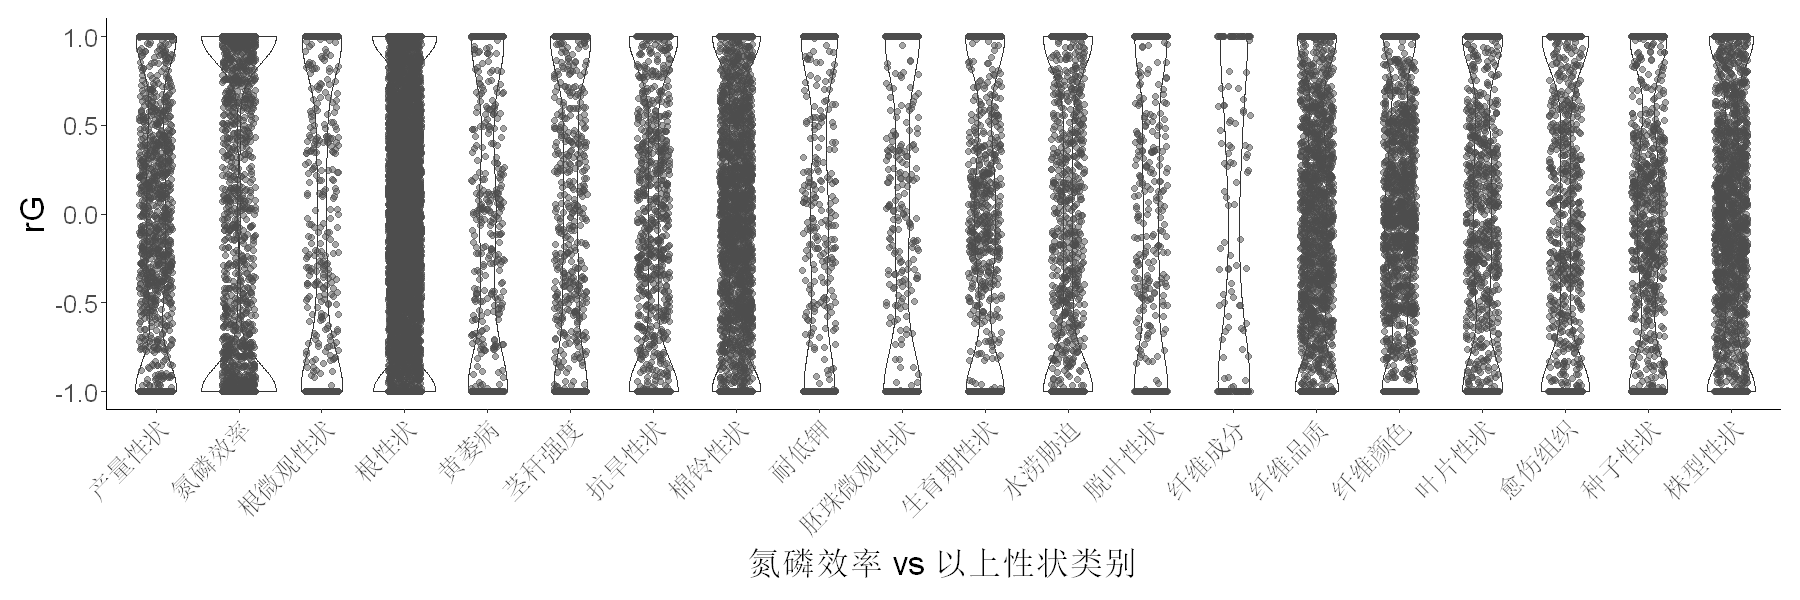

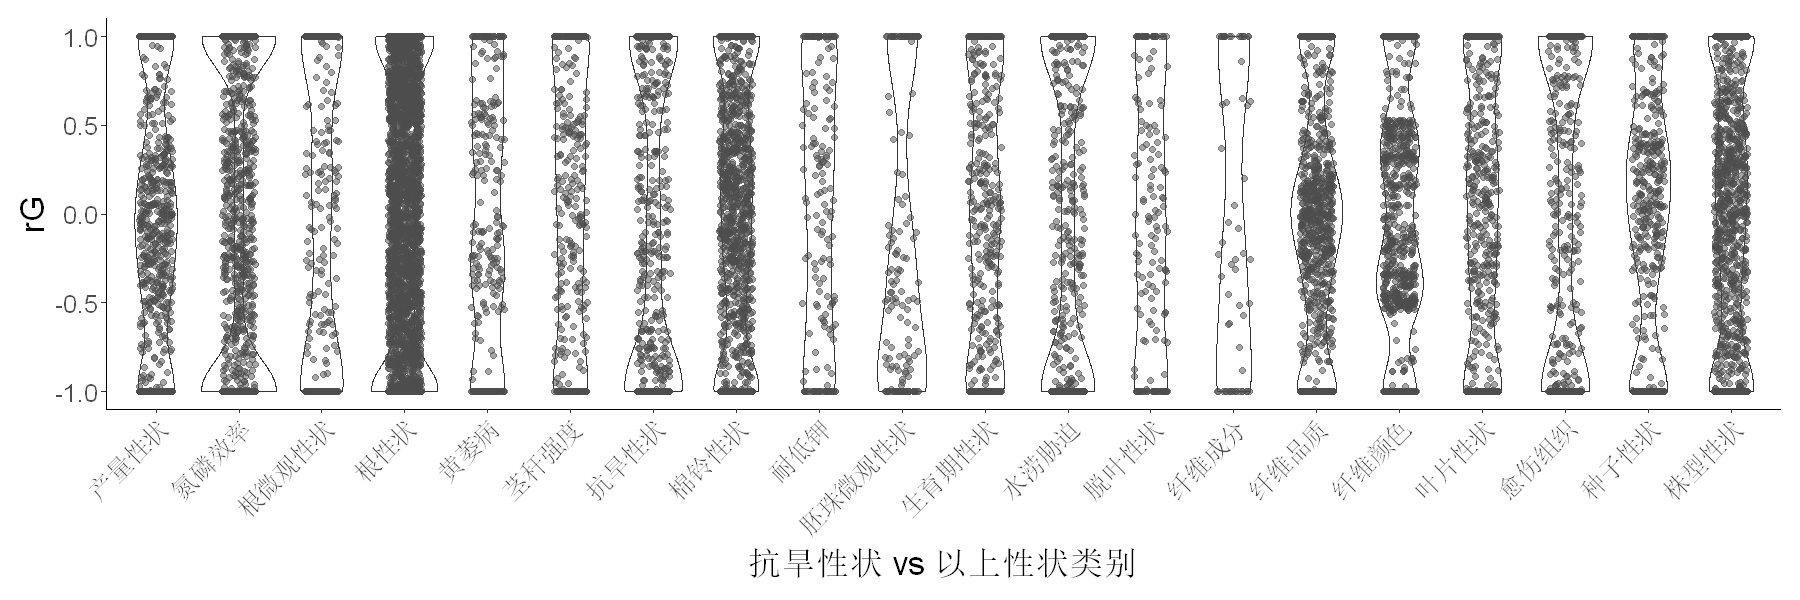

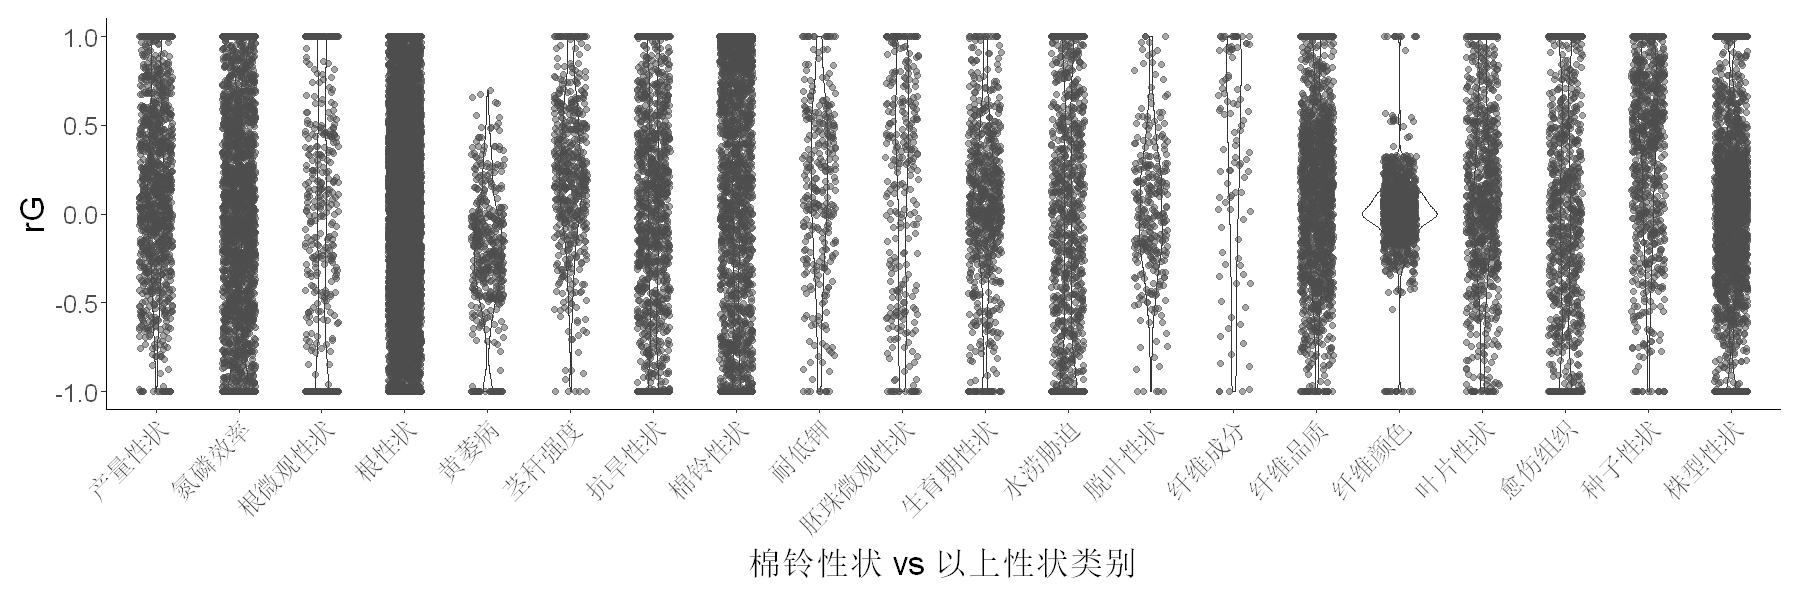

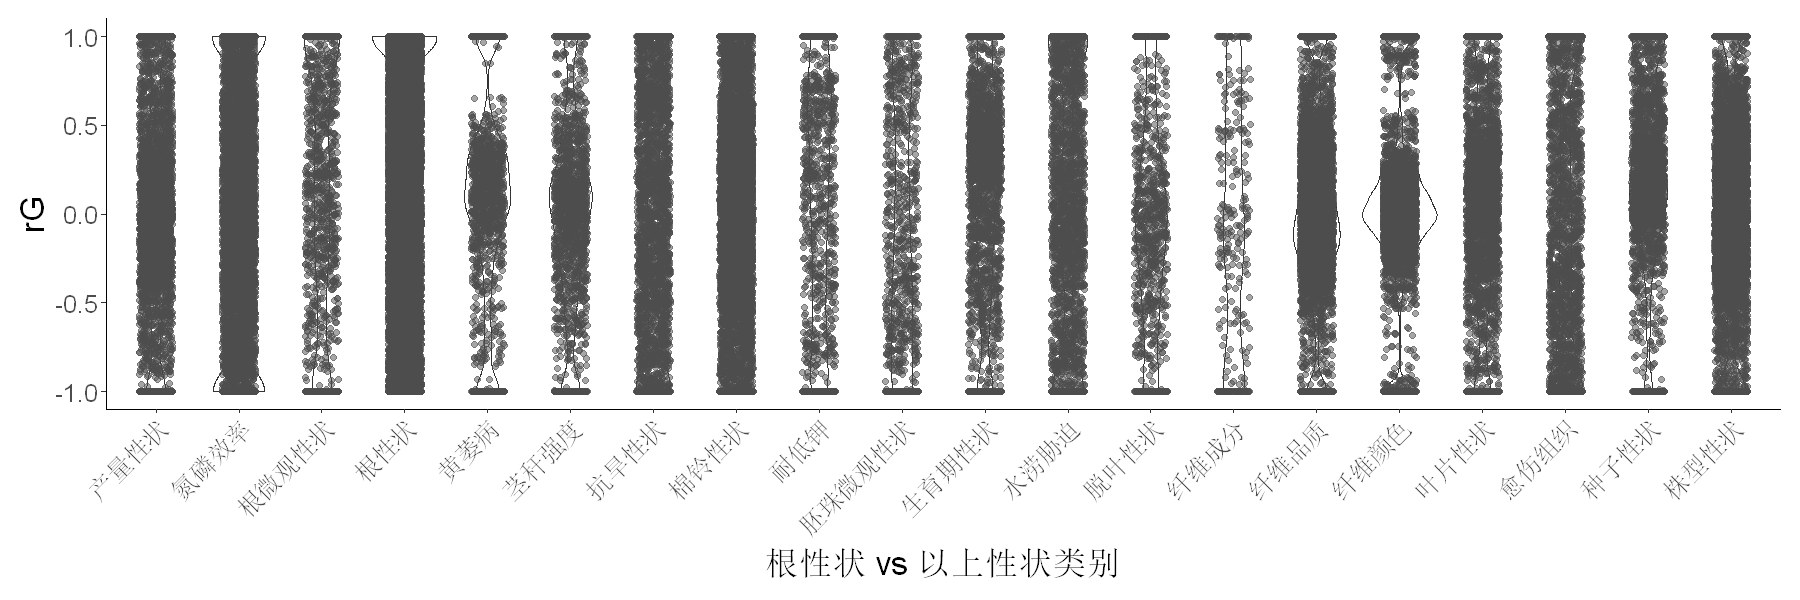

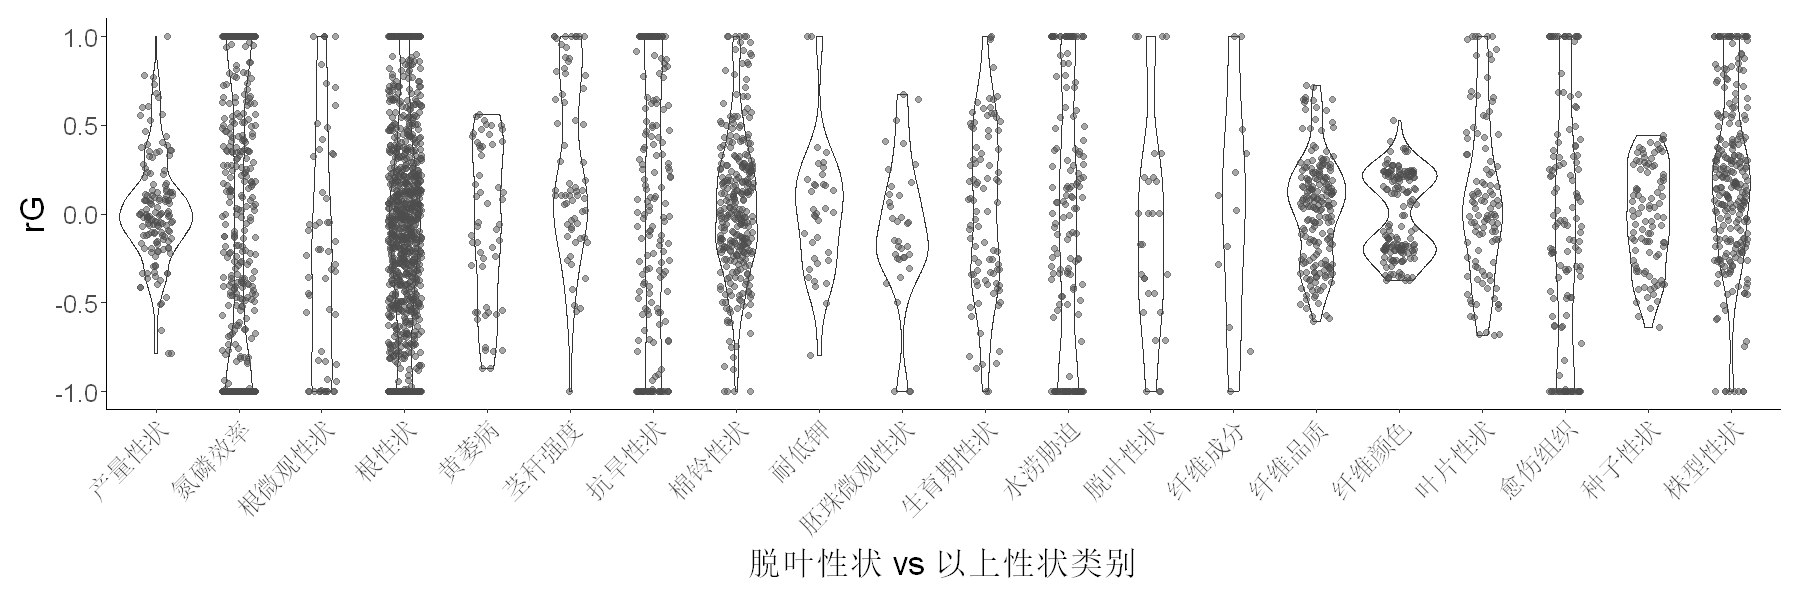

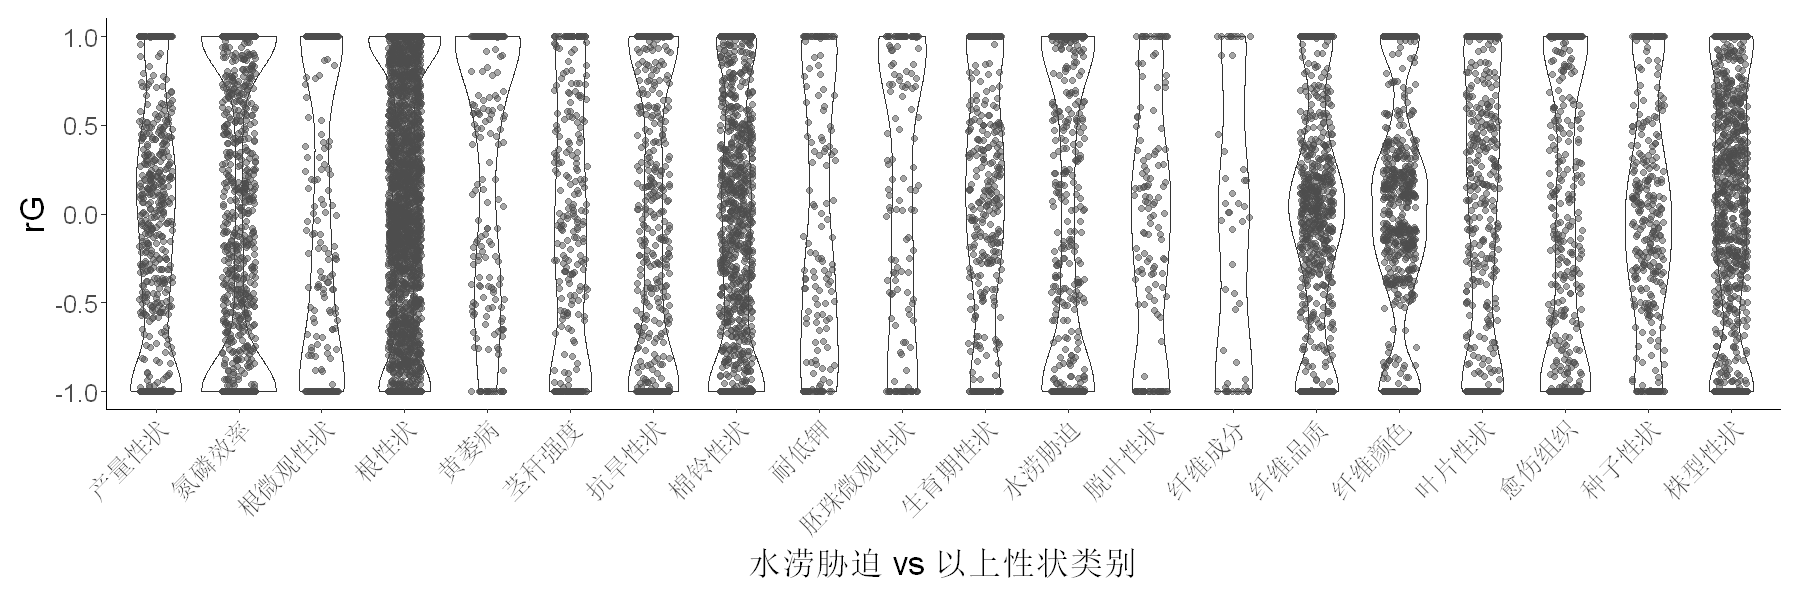

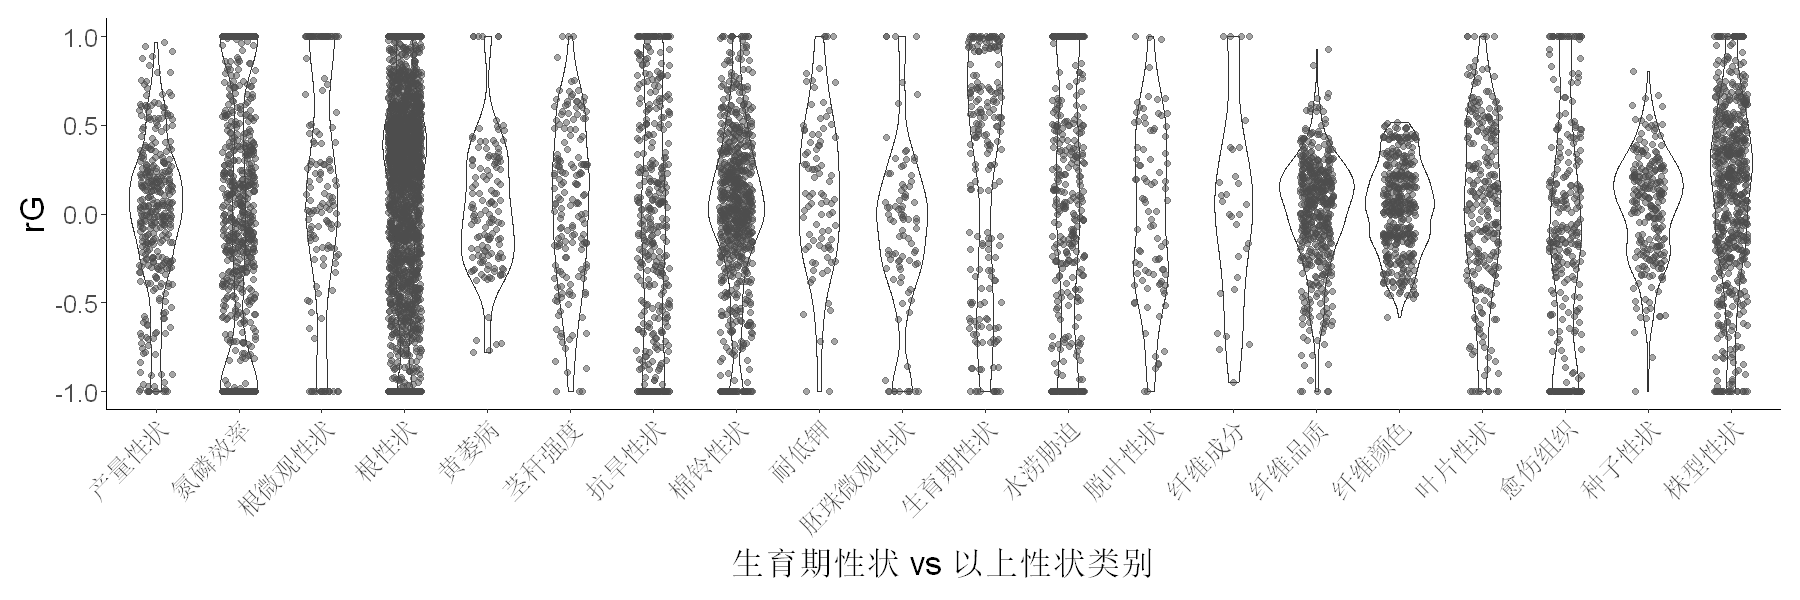

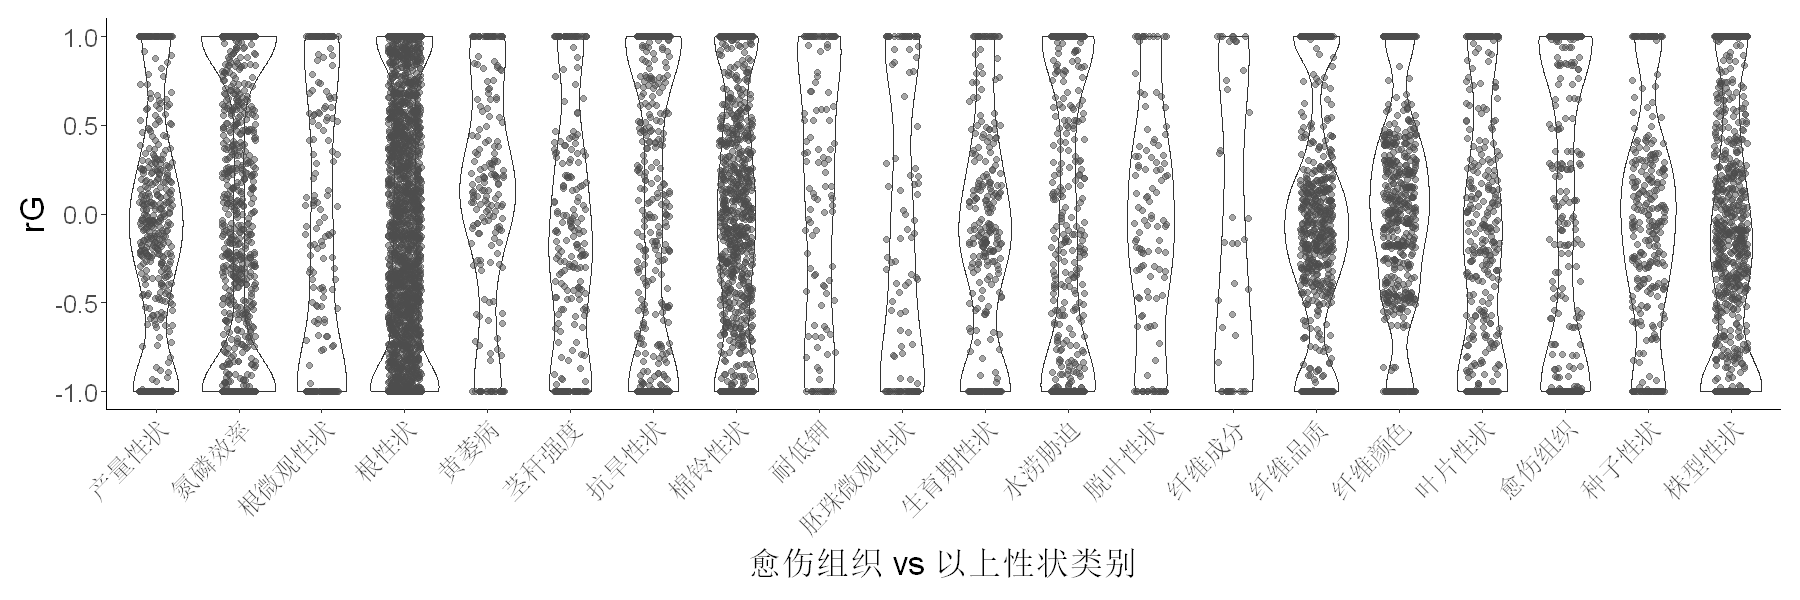

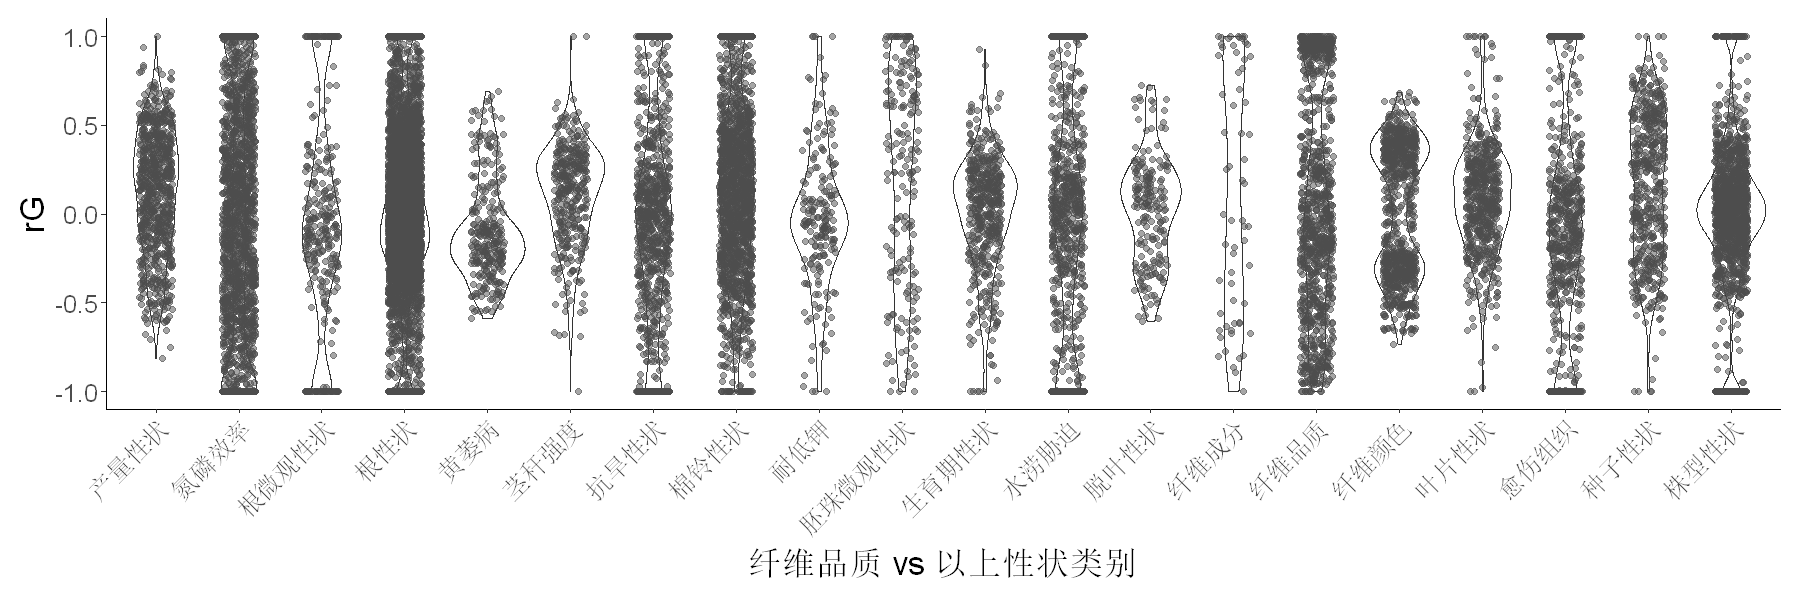

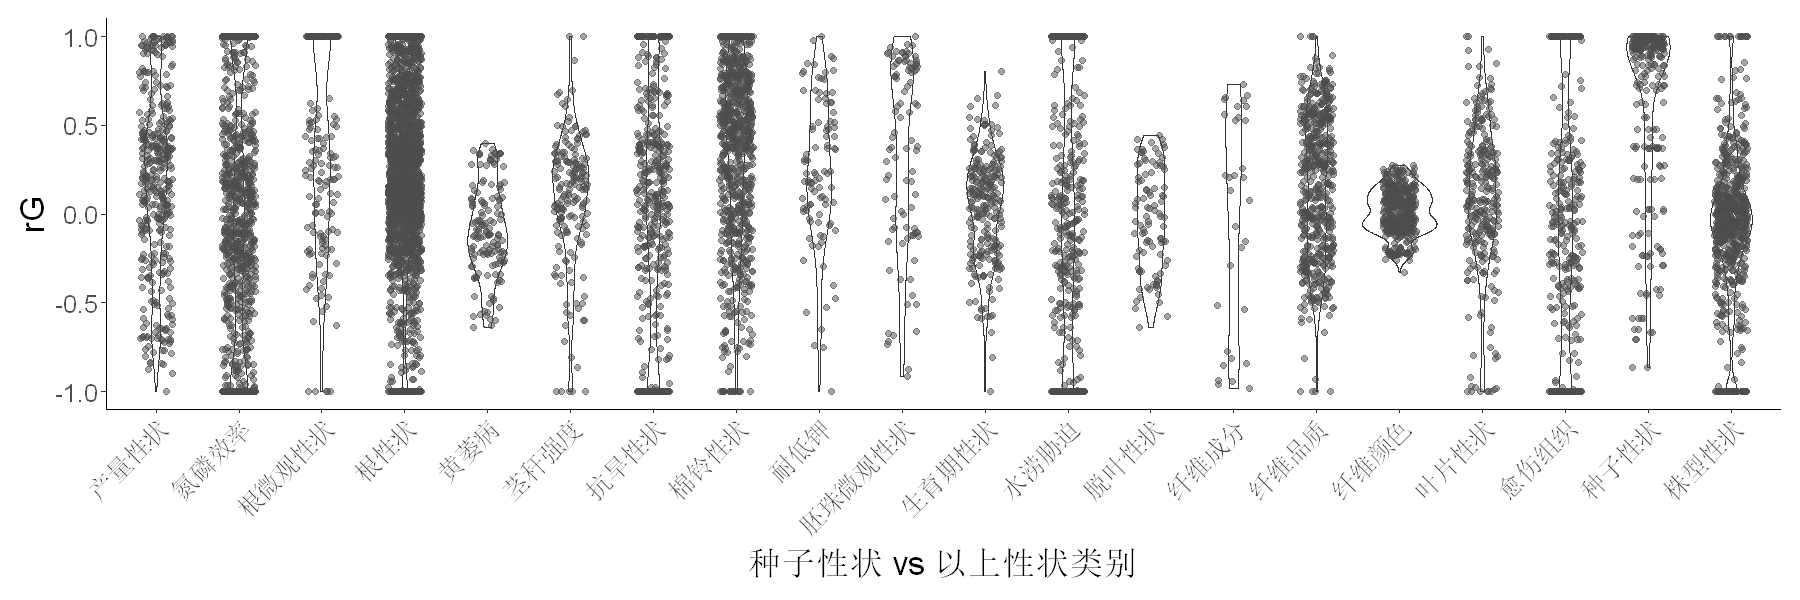

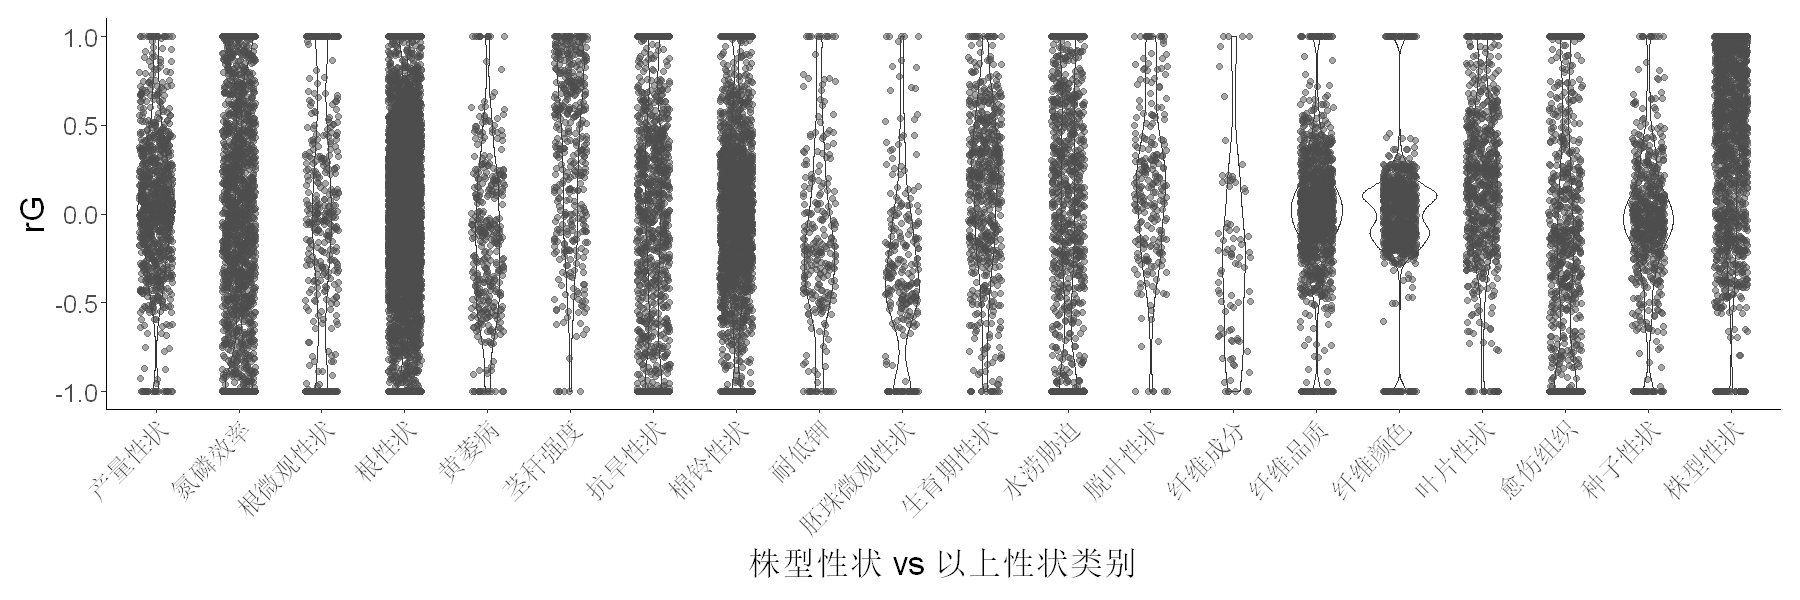

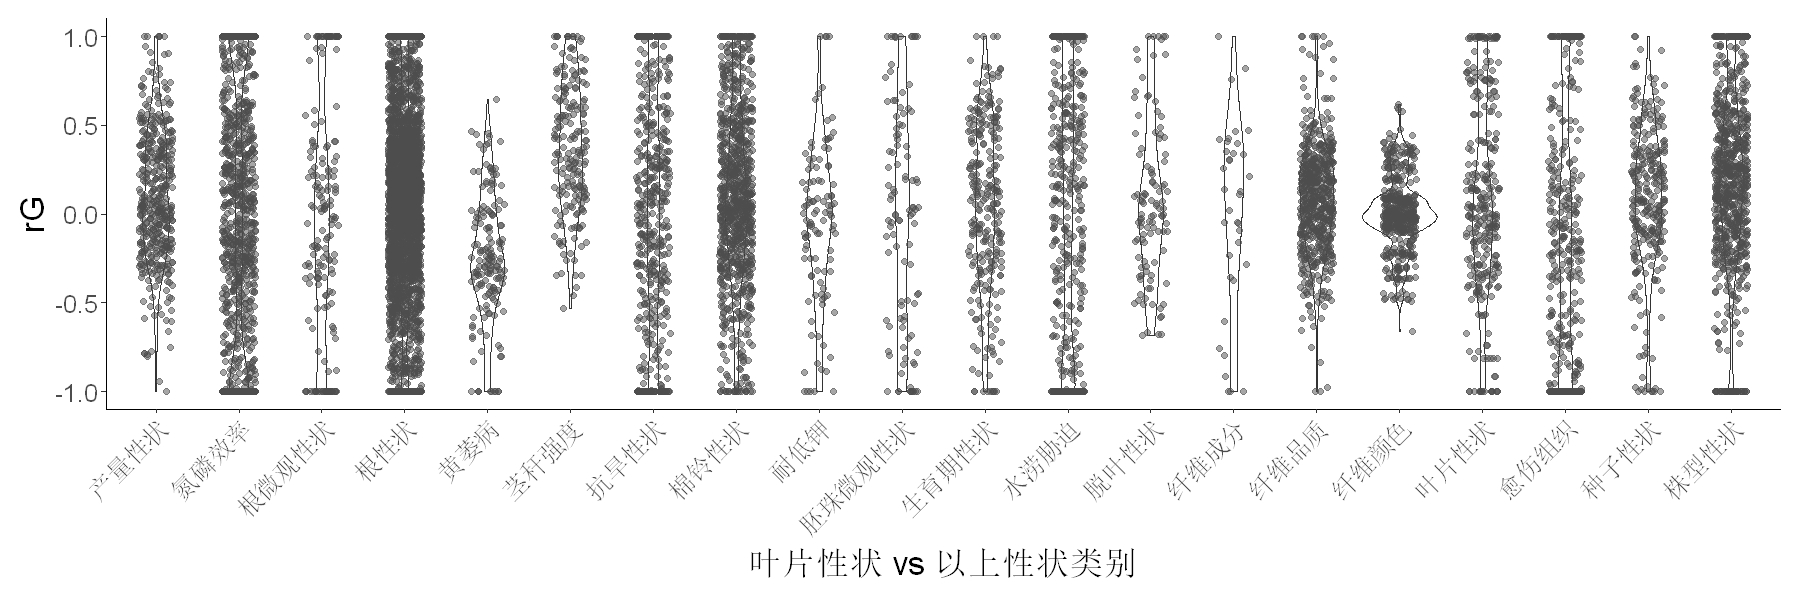

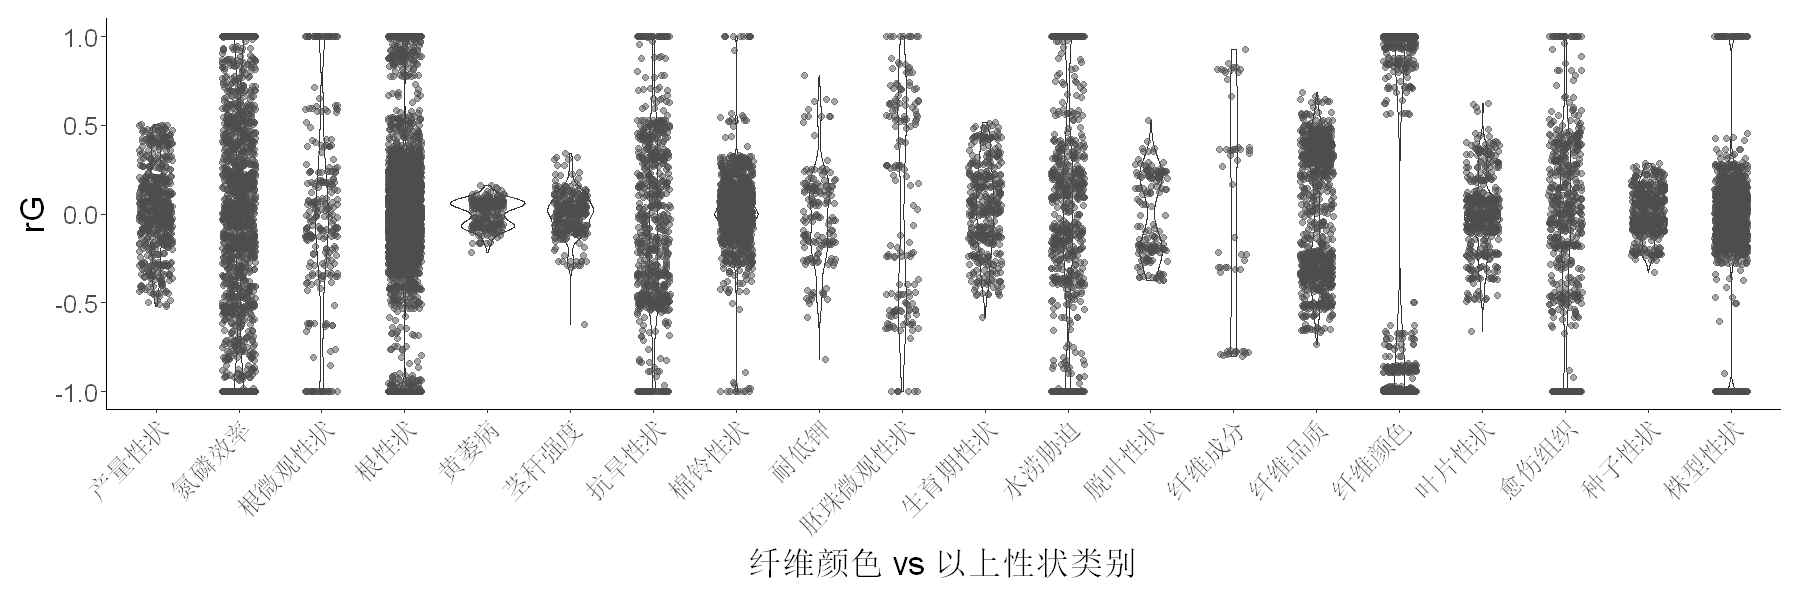

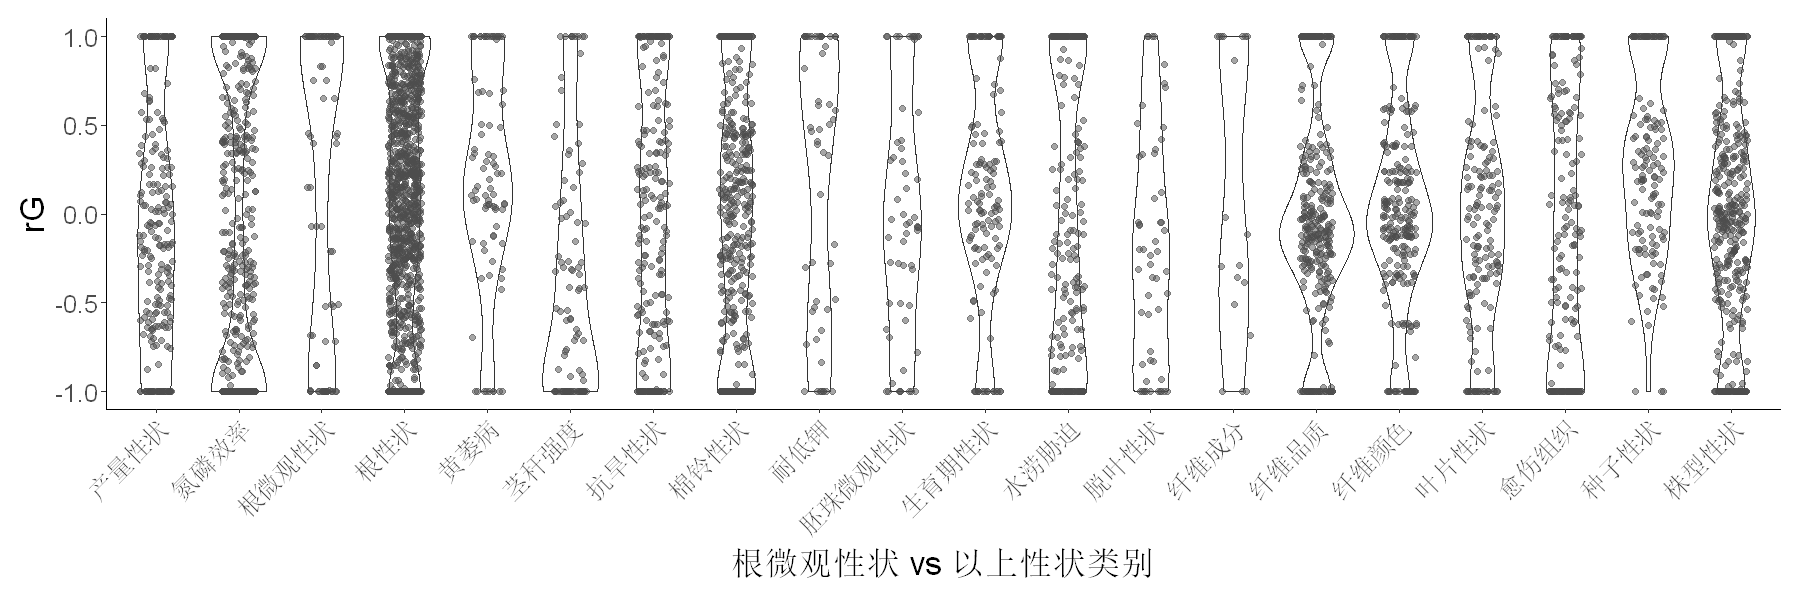

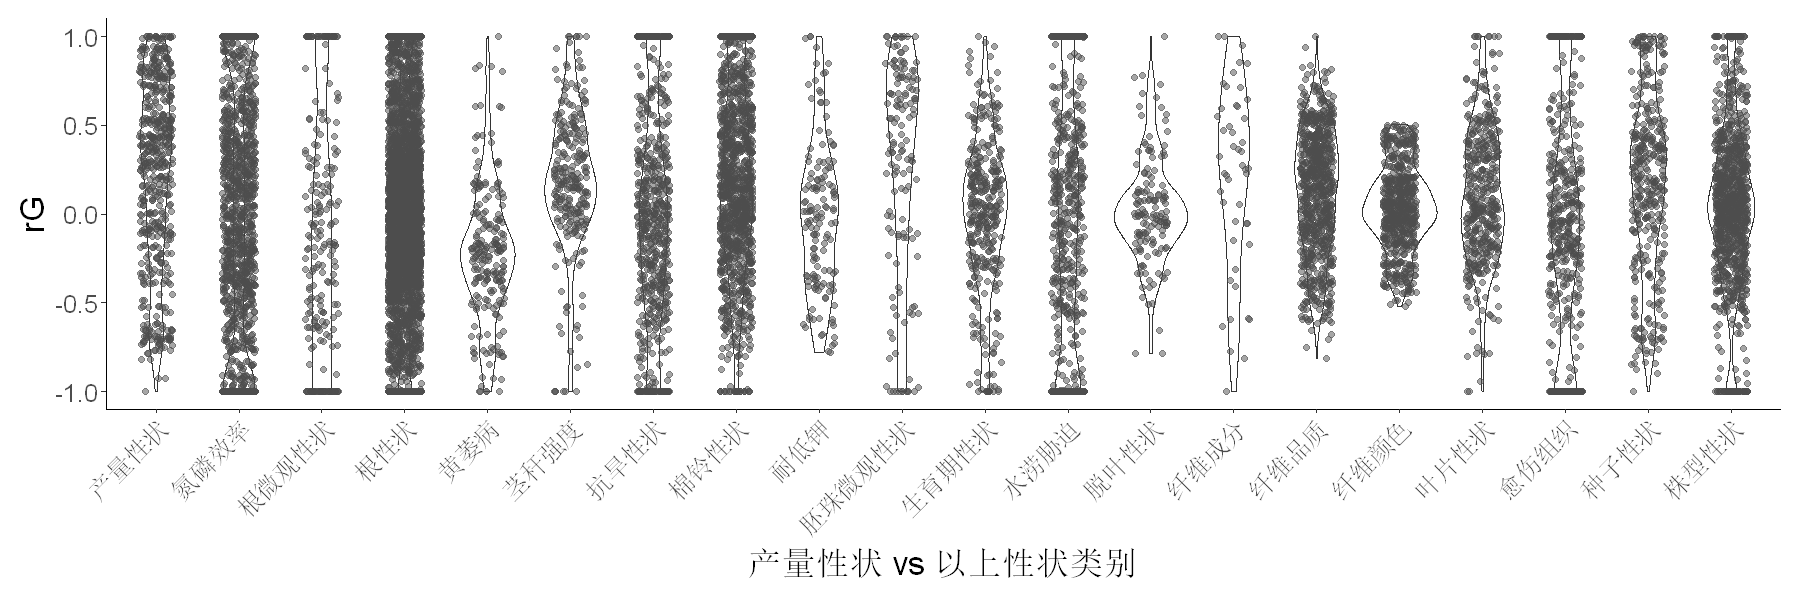

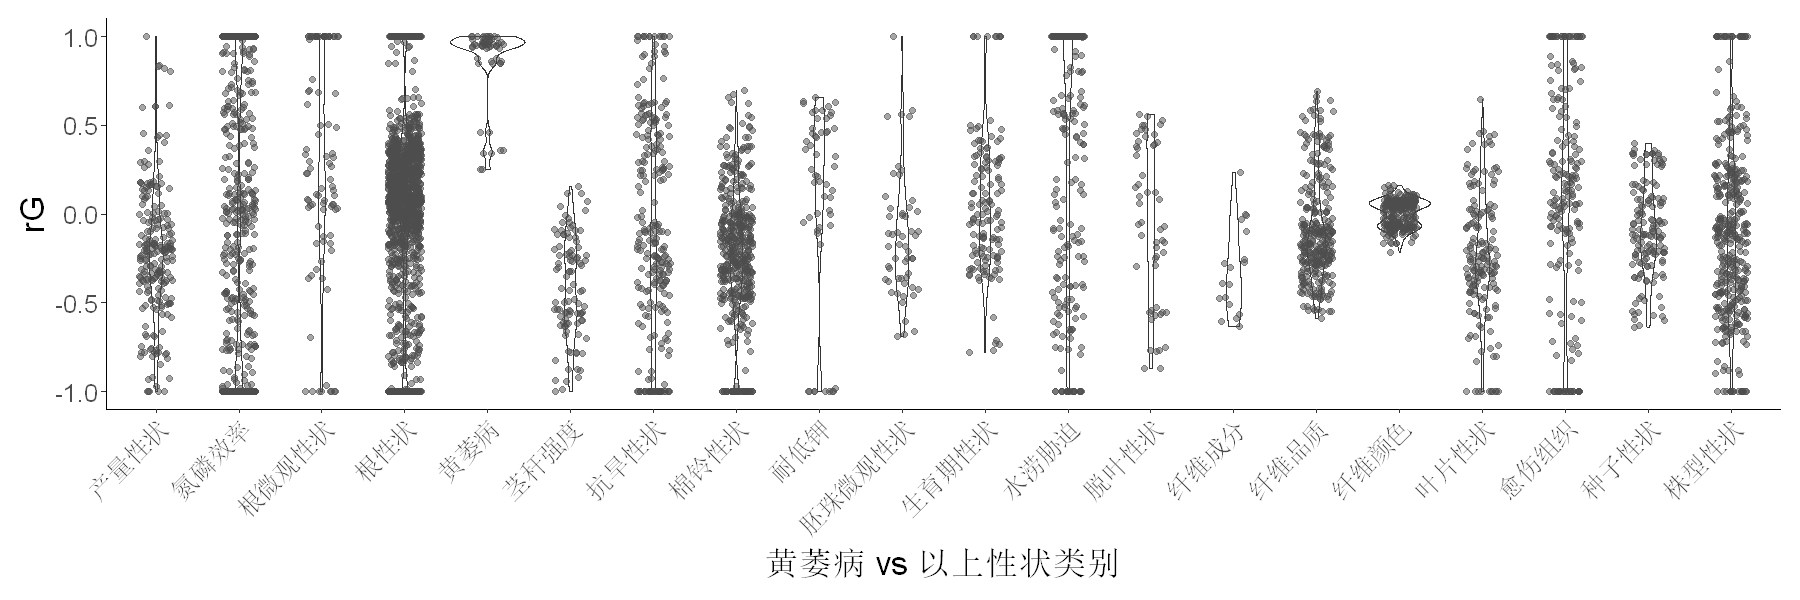

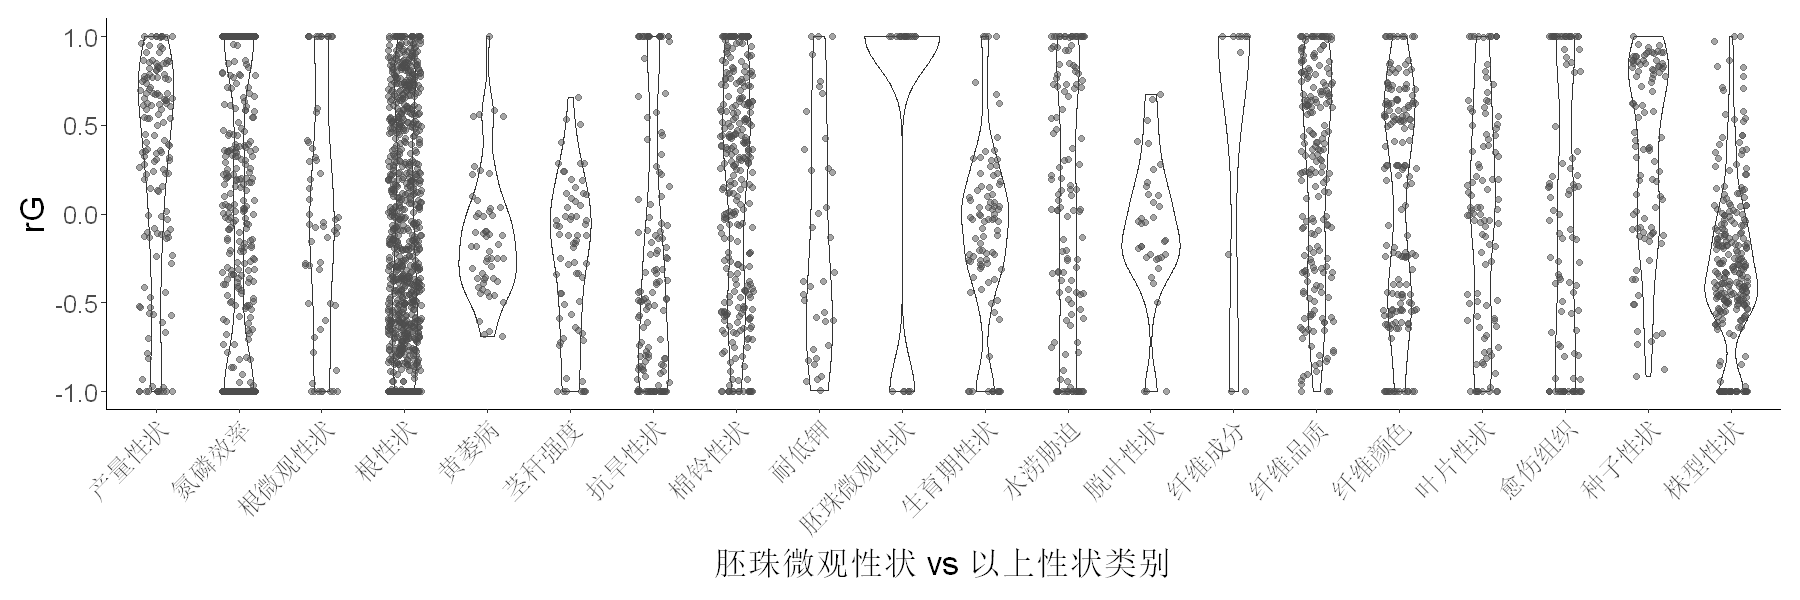

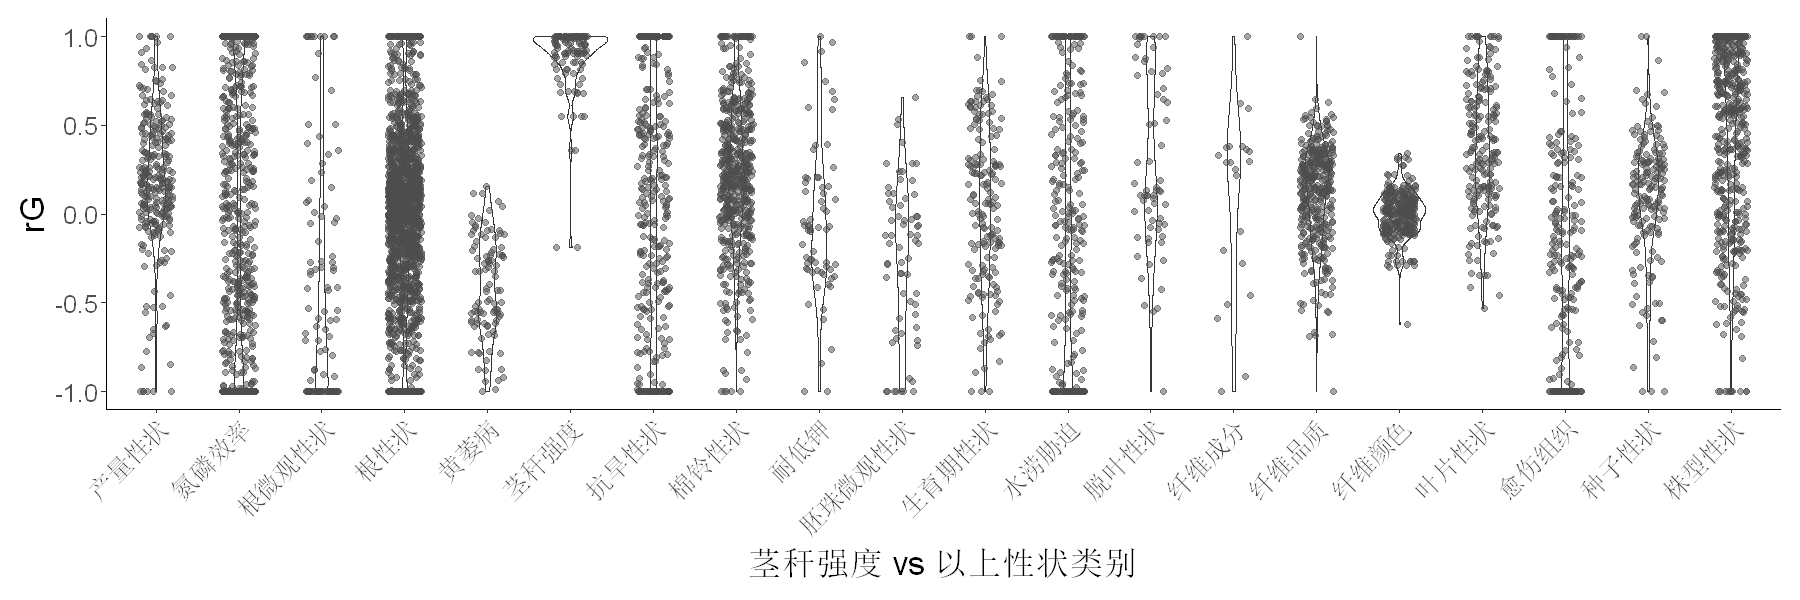

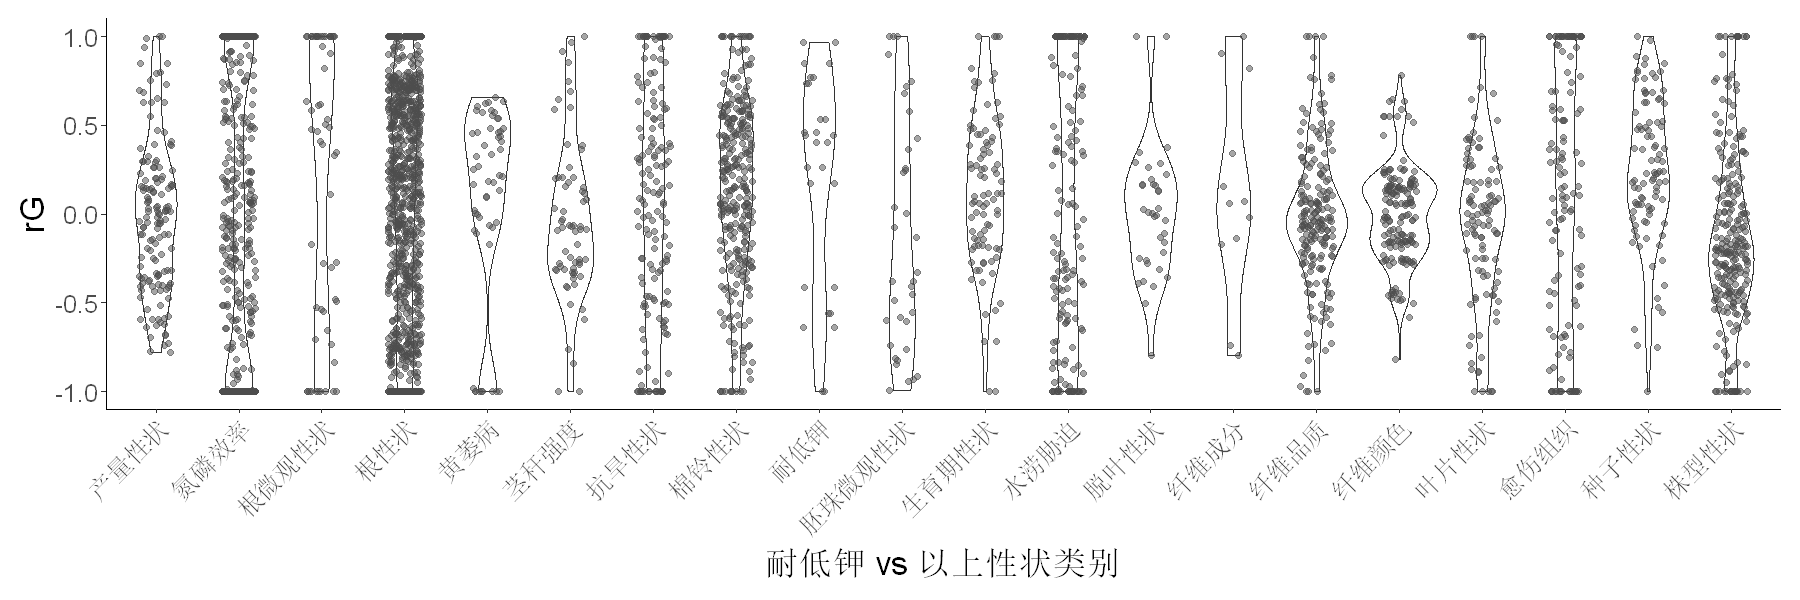

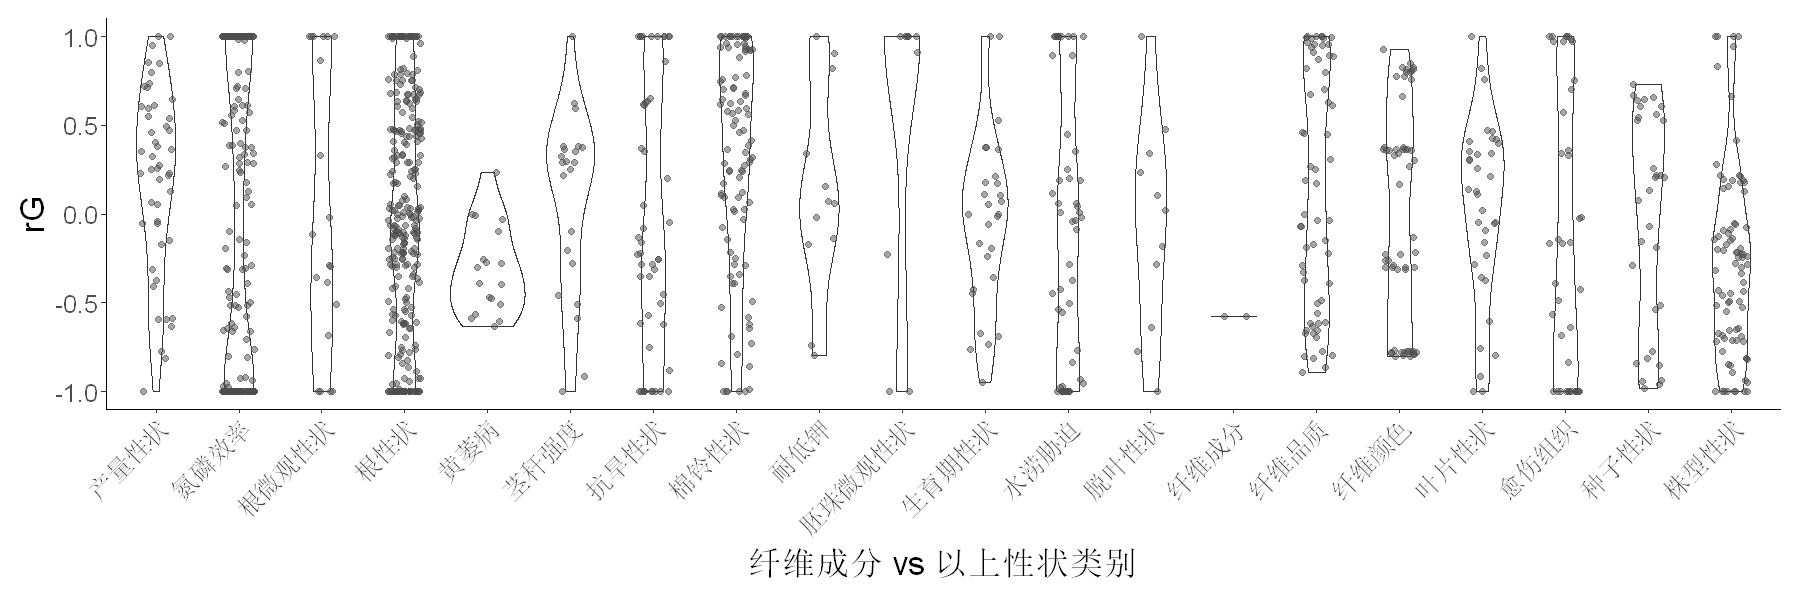

In [52]:
for (i in data$Trait_class_1 %>% unique){
    p <- plot_rG(data, i)
    print(p)
}

#### investigate the results which rG = +-1
- 如果 trait1 和 trait2 完全一致，没有结果.
- 当两个性状均值或SD差异很大时，确实很多情况为 +-1，但也有很多落于-1与1之间。
- 这说明scale两个性状再做genetic correlation可能不是必须的。

In [79]:
blup_values <- df_blup %>% .[3:ncol(.)]

In [91]:
mean_vec <- blup_values %>% colMeans(na.rm = T)

In [102]:
sd_vec <- c()
for (i in 1:ncol(blup_values))
{
  sd_vec = c(sd_vec,sd(blup_values[,i], na.rm =T))
}

In [115]:
tmp <- df_rg %>% 
    mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
    mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
    subset(Trait_idx_1 < Trait_idx_2) %>% 
    mutate(mean_1 = mean_vec[Trait_idx_1]) %>% 
    mutate(mean_2 = mean_vec[Trait_idx_2]) %>% 
    mutate(mean_diff = abs(mean_1 - mean_2)) %>%
    mutate(mean_diff2 = mean_1 - mean_2) %>% 
    mutate(sd_1 = sd_vec[Trait_idx_1]) %>% 
    mutate(sd_2 = sd_vec[Trait_idx_2]) %>% 
    mutate(sd_diff = sd_1 - sd_2)

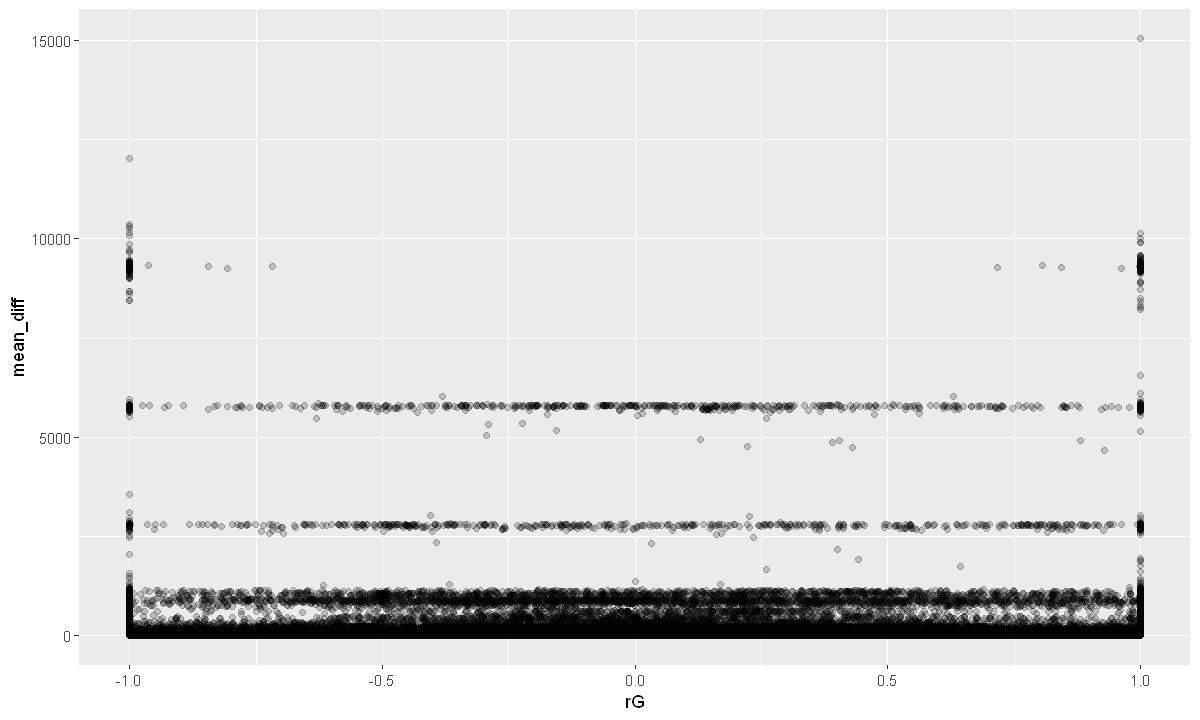

In [109]:
options(repr.plot.width = 10, repr.plot.height = 6)
tmp %>% ggplot(aes(rG, mean_diff)) +
    geom_point(alpha = 0.2)

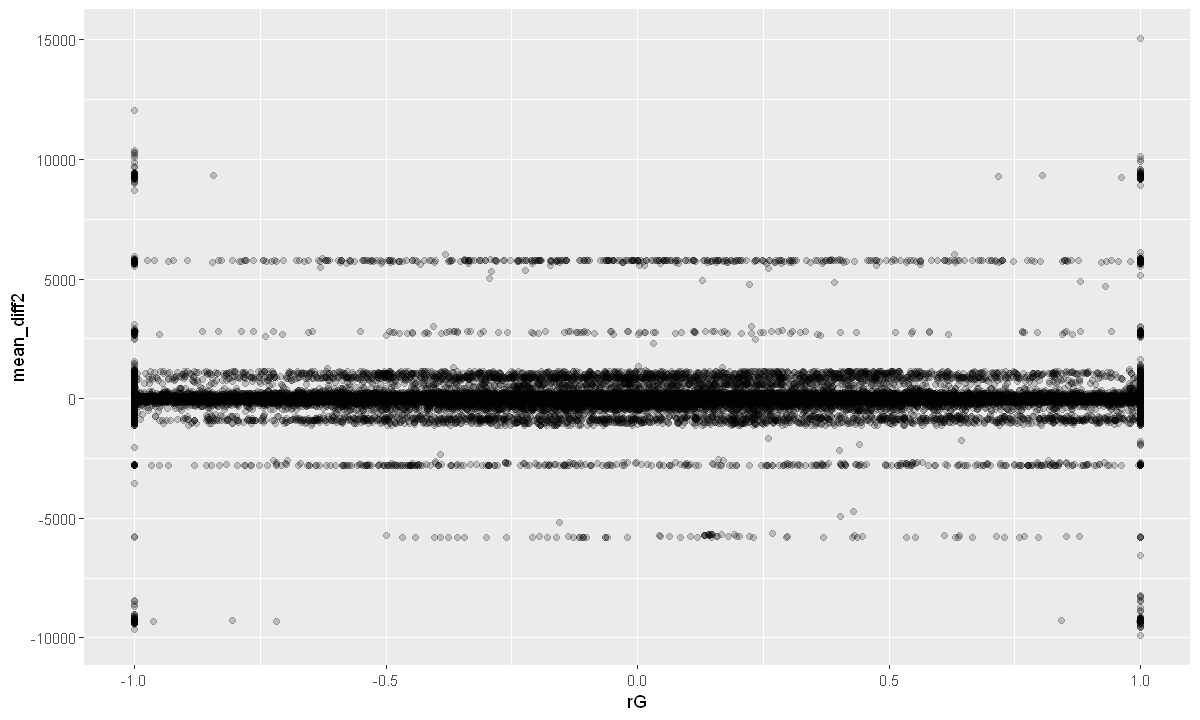

In [116]:
options(repr.plot.width = 10, repr.plot.height = 6)
tmp %>% ggplot(aes(rG, mean_diff2)) +
    geom_point(alpha = 0.2)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
tmp %>% ggplot(aes(rG, mean_diff)) +
    geom_point(alpha = 0.2)

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 103281 rows containing missing values (geom_point)."


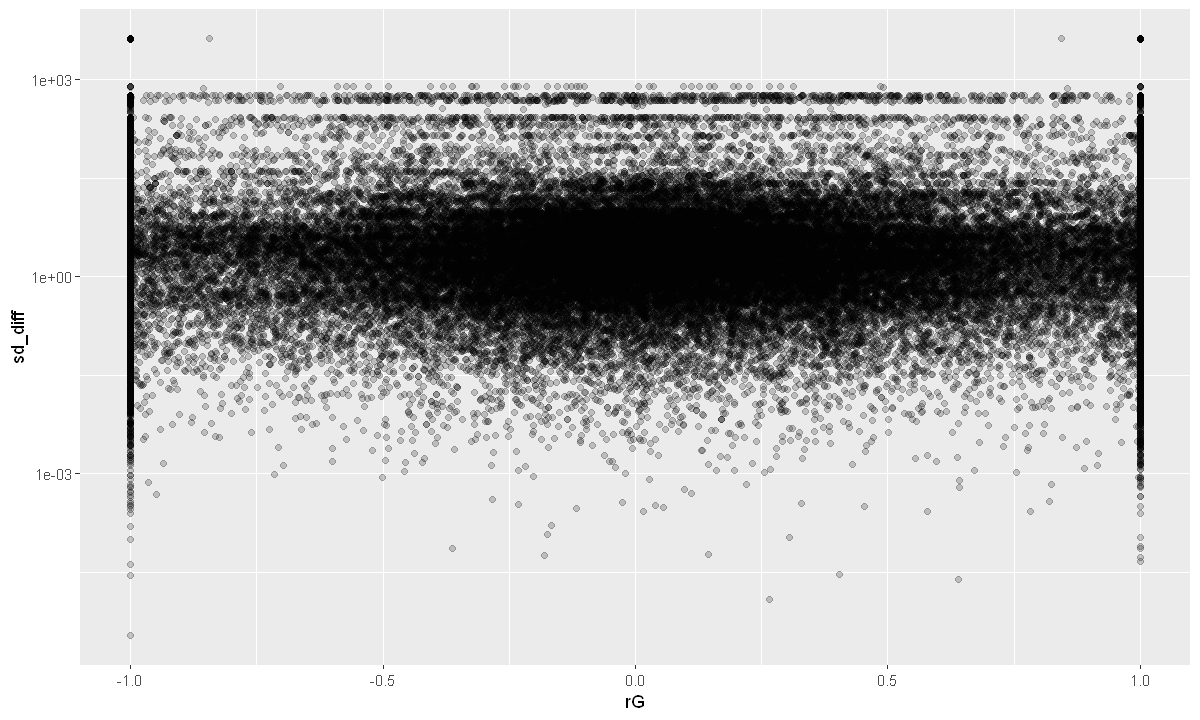

In [114]:
options(repr.plot.width = 10, repr.plot.height = 6)
tmp %>% ggplot(aes(rG, sd_diff)) +
    geom_point(alpha = 0.2) + 
    scale_y_log10()

In [84]:
blup_values[tmp$Trait_idx_1 %>% unique()] %>% colMeans(na.rm = T)

YT_DR         FBA_BLANK         FBL_BLANK           EFBA_CK 
     8.777171e-01      5.792350e+01      2.104012e+01      5.275655e+01 
  BON_blooming_DR            FBA_DR           FBA_DCK            FBA_CK 
     9.981796e-01      9.256423e-01      6.258637e+01      5.349165e+01 
          EFBA_DR            YT_DCK          FABR_DCK  BON_blooming_DCK 
     9.168491e-01      1.124958e+03      3.368582e-01      5.883157e+00 
       EFBL_BLANK          EFBL_DCK        EFBA_BLANK          EFBA_DCK 
     1.814881e+01      1.551567e+01      5.824405e+01      6.155576e+01 
           FBL_CK           EFBL_CK          FS_BLANK            FS_DCK 
     2.567725e+01      2.165222e+01      2.959332e+01      2.609237e+01 
            FU_CK            MIC_DR             FE_CK            FU_DCK 
     8.464875e+01      1.060118e+00      8.456205e+00      8.214188e+01 
            FU_DR           MIC_DCK             FL_CK          FL_BLANK 
     9.899040e-01      4.231867e+00      2.899097e+01      2.840713e+01 
           FL_DCK             FL_DR            FE_DCK          FU_BLANK 
     2.648020e+01      9.699566e-01      6.488249e+00      8.472945e+01 
            FS_CK          FE_BLANK         MIC_BLANK            MIC_CK 
     2.745844e+01      8.156675e+00      5.082304e+00      4.458297e+00 
       FFBL_BLANK        FFBA_BLANK         FBN_BLANK        NNFF_BLANK 
     2.299274e+01      5.775216e+01      9.967898e+00      5.190519e+00 
         FFBA_DCK           FFBL_DR            FBN_CK         LBN_BLANK 
     6.254221e+01      9.050082e-01      1.486893e+01      2.075375e+00 
          FFBH_CK           FBL_DCK            FBL_DR          FFBL_DCK 
     1.861070e+01      2.075777e+01      8.473470e-01      2.034663e+01 
       FFBH_BLANK           FFBH_DR           FFBA_DR           FFBA_CK 
     2.378420e+01      1.136550e+00      9.312966e-01      5.301169e+01 
          FFBL_CK          FFBH_DCK         PH2_BLANK          PW_BLANK 
     2.757584e+01      1.616101e+01      8.971446e+01      4.109027e+01 
        PH1_BLANK           SFBA_DR        FBN_FB_DCK        SFBA_BLANK 
     8.094546e+01      9.328933e-01      6.810626e+00      5.779485e+01 
       SFBL_BLANK          PH_BLANK           SFBA_CK          SFBA_DCK 
     2.188168e+01      7.690264e+01      5.460110e+01      6.366114e+01 
           PH_DCK           SFBL_CK          SFBL_DCK           SFBL_DR 
     7.316477e+01      2.759030e+01      2.641101e+01      8.686151e-01 
            PW_CK             PH_CK          NNFF_DCK           NNFF_CK 
     5.631332e+01      8.790785e+01      4.448143e+00      5.487467e+00 
           FFD_CK        SBOD_BLANK           SBOD_CK            BOP_CK 
     6.802094e+01      1.479697e+02      1.421175e+02      7.584424e-01 
        SFD_BLANK            SFD_CK            FT_DCK         FFD_BLANK 
     8.725871e+01      8.754122e+01      8.565508e+01      7.232218e+01 
            FT_DR            FDI_CK           FBOD_CK           BODI_CK 
     9.974154e-01      1.958667e+01      1.185104e+02      2.360705e+01 
         FD_BLANK       FFBH_BS_DCK         PH_FB_DCK        BODI_BLANK 
     7.686945e+01      8.561200e+00      3.551063e+01      1.892680e+01 
       FBOD_BLANK         FBN_FB_DR        FFBH_BS_DR           LPA_DCK 
     1.292066e+02      1.257933e+00      7.917529e-01      3.419297e+00 
        LPA_BLANK            LeA_CK            LPA_CK         DrW_BLANK 
     2.607958e+00      8.627031e+01      3.638864e+00      1.162924e+00 
        LeA_BLANK   FN_blooming_DCK            LeG_CK         LeN_BLANK 
     1.356496e+02      1.628748e+00      7.548185e+00      5.651462e+00 
           Frw_CK            DrW_CK           LeG_DCK        SPAD_BLANK 
     2.728551e+00      6.190992e-01      7.085864e+00      5.732731e+01 
        LeG_BLANK        FrW_Hyd12d         FrW_BLANK         LeC_BLANK 
     6.027768e+00      1.942279e+00      4.885444e+00      6.915081e+01 
          LeN_DCK           FrW_FEF    FN_blooming_DR         SPAD_SIN

In [85]:
blup_values[tmp$Trait_idx_2 %>% unique()] %>% colMeans(na.rm = T)

NUE_SIN2          NUE_SIP1         NUtE_SIN2         NUtE_SIP1 
    -7.859696e+01      1.193606e+02     -9.242468e+03      4.151693e+01 
            FT_DR      FBN_WL_BLANK         SPAD_SIN1          SPAD_TCK 
     9.974154e-01      1.360877e+01      9.210663e+01      9.127431e-01 
BL_TUWB_30d_BLANK        L10_Hyd12d           PA8_FTP            T6_FEF 
     1.732087e+00      2.890612e+01      1.296158e+00      3.144215e-01 
           T7_FTP         T9_Hyd12d            T9_FEF          Tips_FTP 
     1.178728e+00      1.849723e-01      8.514402e-02      1.788591e+01 
         Tips_FEF           V10_FEF         T4_Hyd12d          LR_Hyd8d 
     1.342612e+02      2.922211e+01      2.128723e+00      2.576335e+01 
           LR_FTP           PRL_FEF         PRL_BLANK          AnRA_FTP 
     1.183531e+01      1.489667e+01      7.706560e-01      1.909498e+01 
         AnRW_FTP       Fors_Hyd12d           L10_FTP        FBN_FB_DCK 
     6.077696e+00      4.435462e+02      5.008830e+00      6.810626e+00 
      FFBH_BS_DCK            FDI_CK         LeC_BLANK         SPAD_SIN2 
     8.561200e+00      1.958667e+01      6.915081e+01      7.893371e+00 
        SPAD_SIP2     BST_20d_BLANK    TLWB_30d_BLANK     SFW_30d_BLANK 
     1.262269e+00      2.971409e+00      3.001820e+01      8.857143e+00 
    CFW_30d_BLANK      FW_30d_BLANK    CFWR_30d_BLANK     SDW_30d_BLANK 
     1.103348e+01      1.989062e+01      5.530466e+01      1.489957e+00 
    CDW_30d_BLANK      DW_30d_BLANK    SDWR_30d_BLANK     SDF_30d_BLANK 
     2.966671e+00      4.456629e+00      3.405699e+01      1.688065e+01 
BL_TLWB_10d_BLANK             SL_CK          SL_BLANK          RDrW_FTP 
     1.416616e+00      9.639833e+00      9.124414e+00      9.467820e-02 
          Vol_FEF          FrWC_FEF          FrWP_FEF          MA_BLANK 
     5.190547e+01      9.254569e+00      9.849606e+00      3.168168e-01 
         EL_BLANK         GPC_BLANK  RootVolume_BLANK         Zyg_BLANK 
     7.557211e+02      1.230002e+00      1.281262e+01      1.018029e+03 
     HyCIR2_BLANK      HyCIR4_BLANK      CoCIR4_BLANK       HyMS2_BLANK 
     7.883551e-01      8.639817e-01      8.663708e-01      6.279112e-01 
      CoMS2_BLANK       ShMS2_BLANK        HyRN_BLANK        ShSN_BLANK 
     7.515144e-01      8.310183e-01      6.788512e-02      1.117493e+00 
       ShRN_BLANK             BSS_L             BSS_D         T5_Hyd12d 
     4.412533e-01      1.564184e+01      9.979397e+00      1.188112e+00 
        T6_Hyd12d         T7_Hyd12d         T8_Hyd12d            L8_FTP 
     6.574723e-01      3.647586e-01      2.637649e-01      1.716471e+00 
         PA10_FTP    TUWB_30d_BLANK    TMWB_30d_BLANK    TMWB_10d_BLANK 
     6.336199e+00      2.567301e+01      3.141736e+01      2.311189e+01 
   TLWB_10d_BLANK    TLWB_20d_BLANK       DDrW_Hyd12d           PRL_TCK 
     2.315365e+01      3.211960e+01      3.604083e+00      9.108724e-01 
      AnRH_Hyd12d       SL_AY_BLANK          GR_Hyd4d         LR_Hyd12d 
     6.338968e+00      8.872520e+00      9.210618e+01      3.409395e+01 
           LR_FEF          AnRA_FEF     AvgDiam_BLANK           L10_FEF 
     1.724869e+01      7.740063e+01      3.509417e+00      1.592366e+01 
        L3_Hyd12d         L5_Hyd12d            L5_FEF            SL_TCK 
     9.440809e+00      5.067605e+00      8.106683e+00      9.077286e-01 
            CSS_D             SDI_D            SFrW_U            SFrW_L 
     4.493410e+01      8.761754e+00      1.494592e+01      1.483691e+01 
           SFrW_D             LN_DR          LN.UF_DR       SILEN_BLANK 
     3.569936e+01      7.611507e-01      9.480843e-01      7.842246e-01 
     SIRDrW_BLANK          ADB_SIP1          UDB_SIN2          UDB_SIP2 
     9.145706e-01      4.525453e+01     -5.391588e+01     -6.317346e+00 
         TDB_SIN2          TDB_SIP2          TRL_SIN1          TRL_SIP1 
     3.967651e+01      4.874180e+01      1.262024e+02      1.002310e+02 
         RSA_SIN1          RSA_SIP1         RSA_BLANK          RVE_

Warning message:
"Removed 7 rows containing missing values (geom_point)."


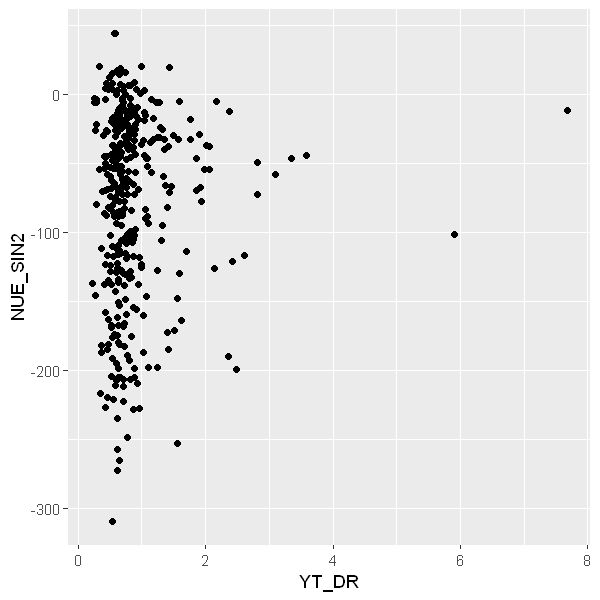

In [65]:
options(repr.plot.width = 5, repr.plot.height = 5)
df_blup[c(106+2, 626 + 2)] %>% ggplot(aes(YT_DR, NUE_SIN2)) + geom_point()

Warning message:
"Removed 3 rows containing missing values (geom_point)."


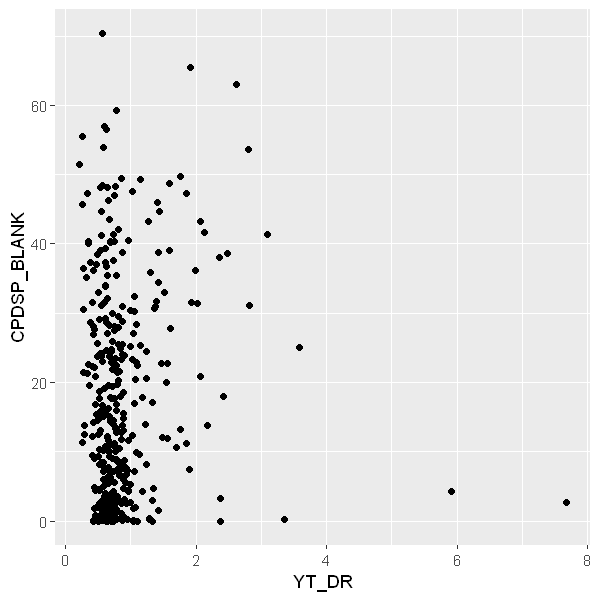

In [68]:
options(repr.plot.width = 5, repr.plot.height = 5)
df_blup[c(106+2, 633 + 2)] %>% ggplot(aes(YT_DR, CPDSP_BLANK)) + geom_point()

In [69]:
df_blup[c(106+2, 635 + 2)]

YT_DR     DW_BLANK 
1   0.8093449 0.5480000
2   1.3529995 0.5043333
3   0.9669369 0.5900000
4   1.1095391 0.5796667
5   0.7827747 0.4930000
6   0.9894443 0.5930000
7   0.7328223 0.6703333
8   0.9639650 0.5106667
9   0.5735788 0.4853333
10  0.7864751 0.6213333
11  0.5528007 0.5893333
12  0.7554493 0.4960000
13  0.5052885        NA
14  0.6129895 0.5836667
15  0.7577403 0.4583333
16  0.8086525 0.4510000
17  0.3593784 0.5203333
18  0.8742287 0.4693333
19  0.7399531 0.5533333
20  0.6082409 0.5030000
21  0.6176279 0.4036667
22  0.4135965 0.5126667
23  0.8991931 0.5416667
24  0.8848061 0.5293333
25  0.6764745 0.5806667
26  1.3267069 0.5430000
27  0.7079567 0.5483333
28  0.6255451 0.4650000
29  0.6203075 0.6373333
30  0.6610559 0.5266667
⋮   ⋮         ⋮        
354 0.8744305 0.5470000
355 1.0877532 0.5763333
356 1.2222259 0.4996667
357        NA 0.5553333
358        NA 0.4723333
359 2.1726620 0.5593333
360 1.5920221 0.5340000
361 1.2772982 0.5570000
362 1.9186790 0.5076667
363 1.4232829 0.5013333
364 2.4831801 0.5733333
365 1.3096673 0.5573333
366 1.6144680 0.5720000
367 2.1340637 0.5890000
368 2.4267749 0.5376667
369 1.5529441 0.5116667
370 1.2428168 0.5000000
371 1.7620528 0.5016667
372 1.7622735 0.5493333
373 1.4068447 0.5703333
374 1.5601760 0.5023333
375 1.8614694 0.4756667
376 1.3622464 0.4876667
377 1.8536585 0.5576667
378 2.8072504 0.5916667
379 2.6123899 0.5390000
380 1.4641358 0.4896667
381 2.0215116 0.5230000
382 1.9321287 0.5043333
383 1.9904457 0.5043333

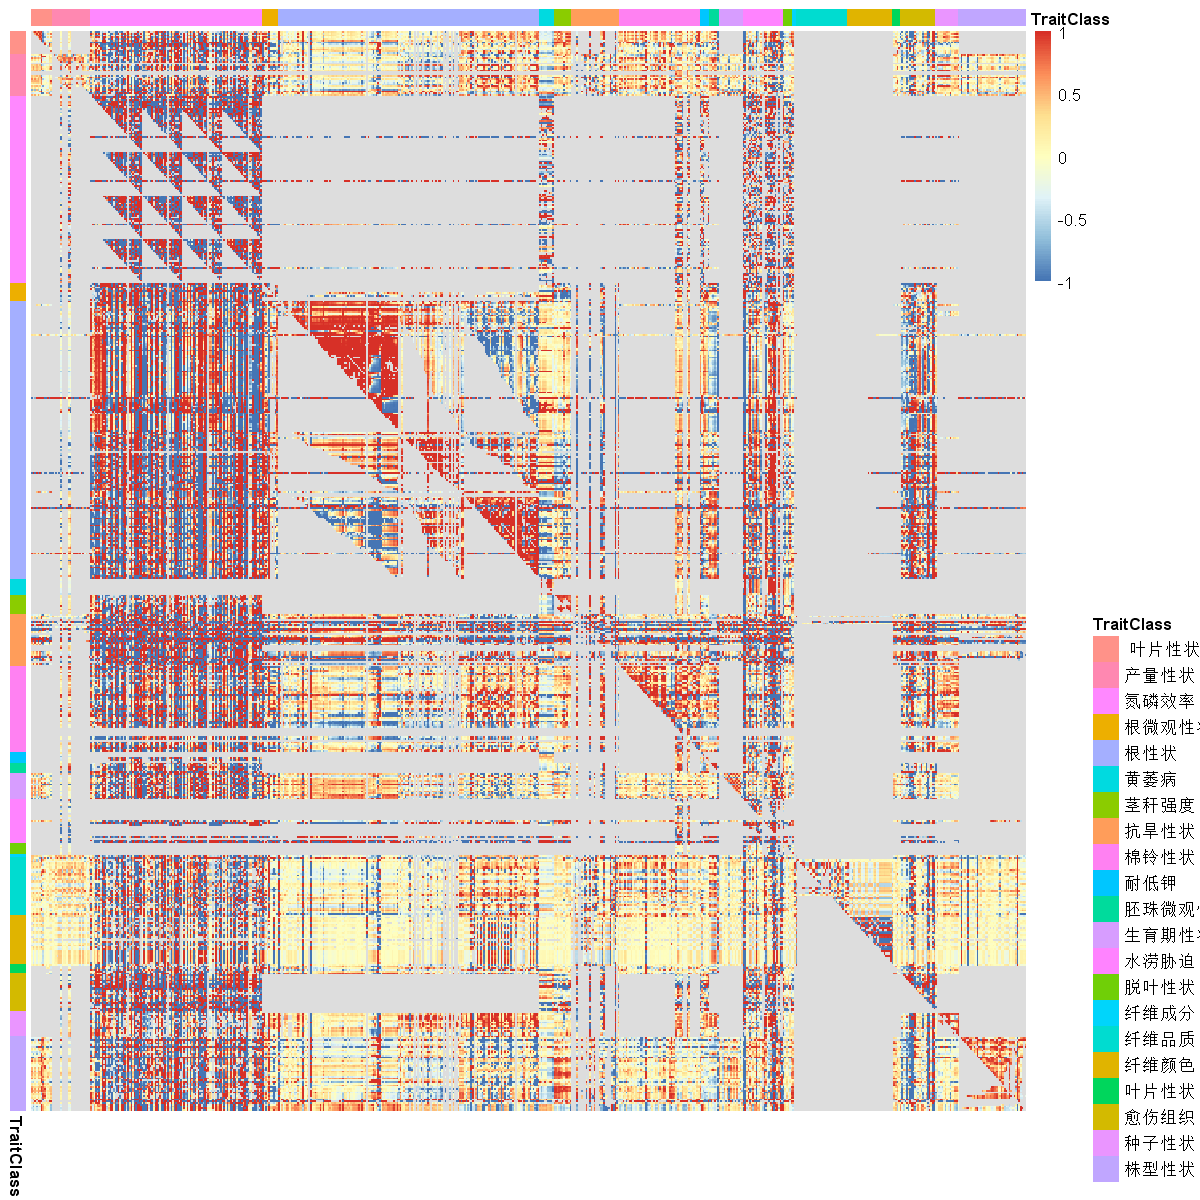

In [166]:
# generate heatmap input
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
subset(Trait_idx_1 < Trait_idx_2) %>% 
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 10, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rG_matrix, df_trait_class)

In [116]:
?pheatmap

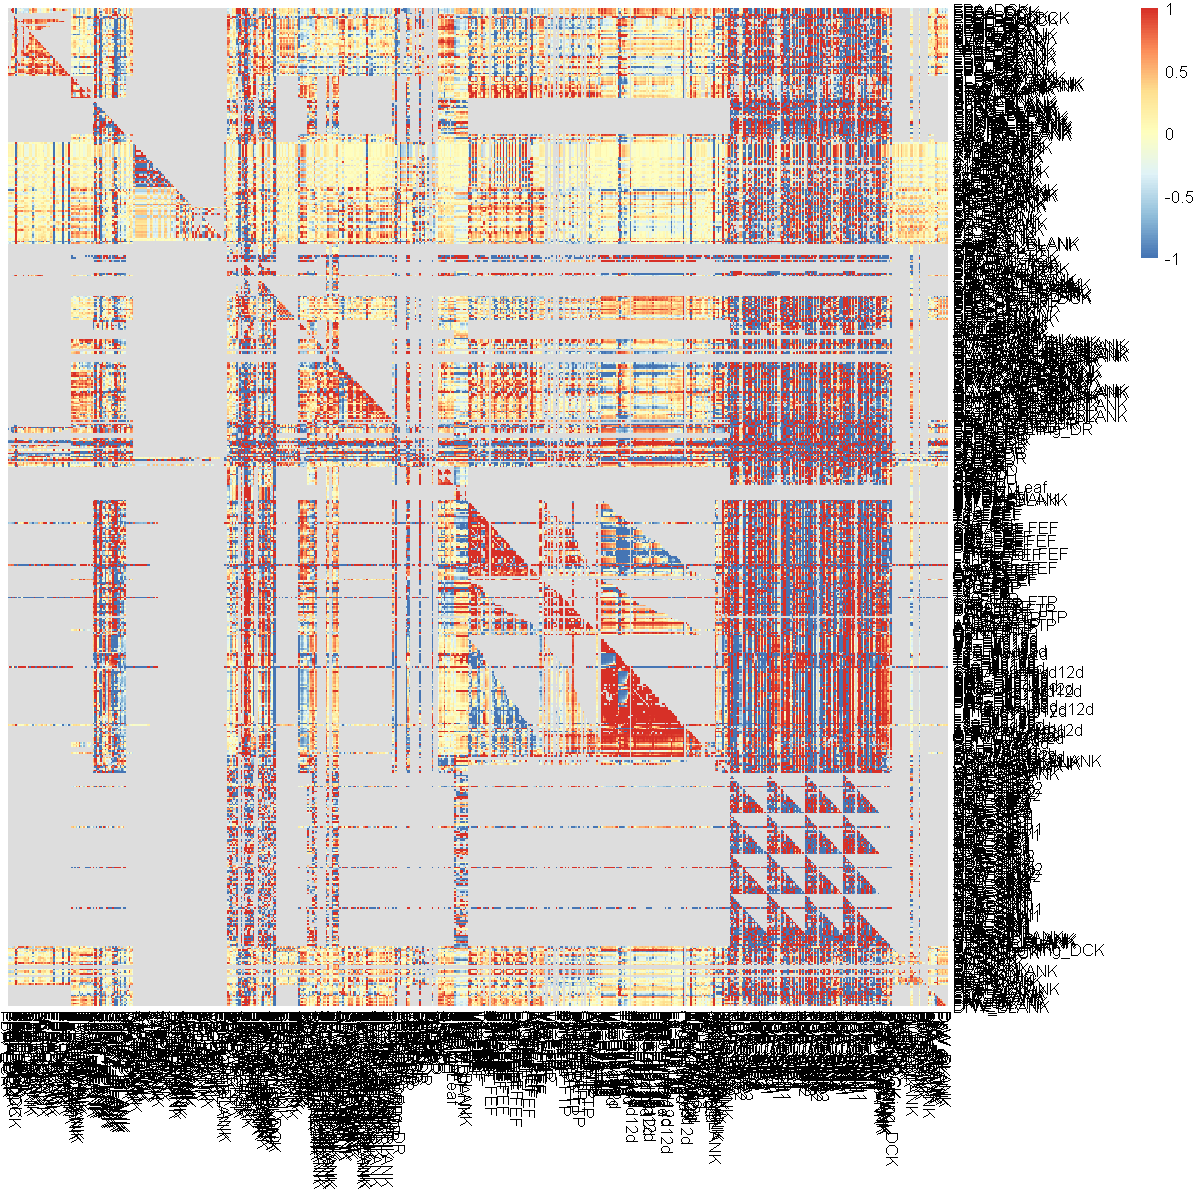

In [106]:
rG_matrix[rev(setdiff(trait_vec_ordered, setdiff(trait_vec_ordered, rownames(rG_matrix)))),
          rev(setdiff(trait_vec_ordered, setdiff(trait_vec_ordered, colnames(rG_matrix))))] %>% 
pheatmap(., 
#          scale = 'row',
         cluster_rows = FALSE,
         cluster_cols = FALSE)

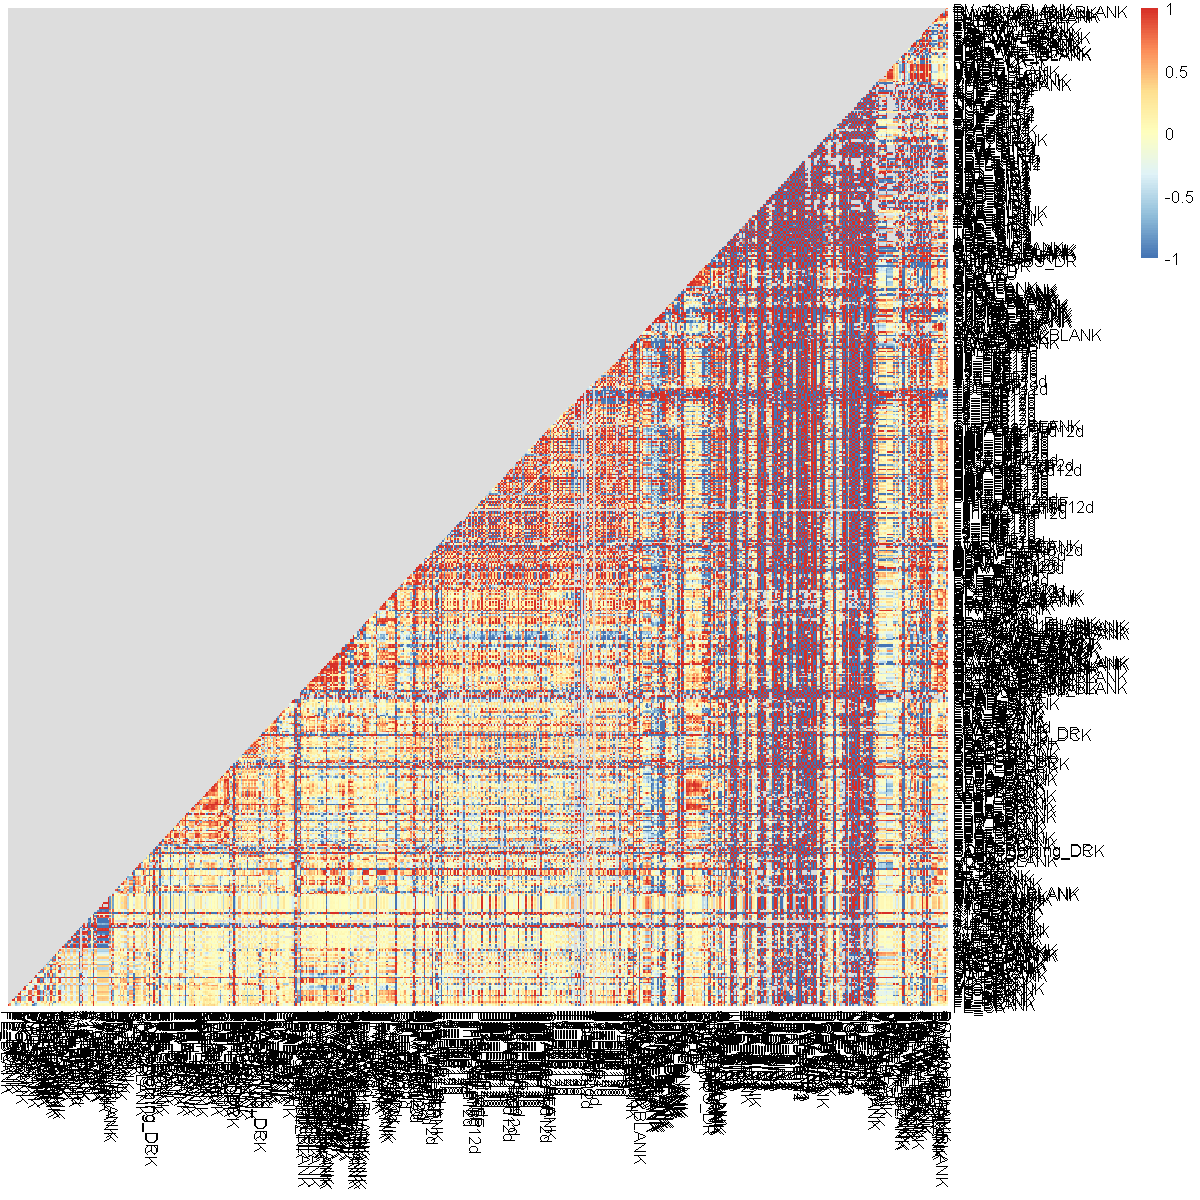

In [100]:
rG_matrix[rev(setdiff(triat_vec, setdiff(triat_vec, rownames(rG_matrix)))),
          setdiff(triat_vec, setdiff(triat_vec, colnames(rG_matrix)))] %>% 
pheatmap(., 
#          scale = 'row',
         cluster_rows = FALSE,
         cluster_cols = FALSE)

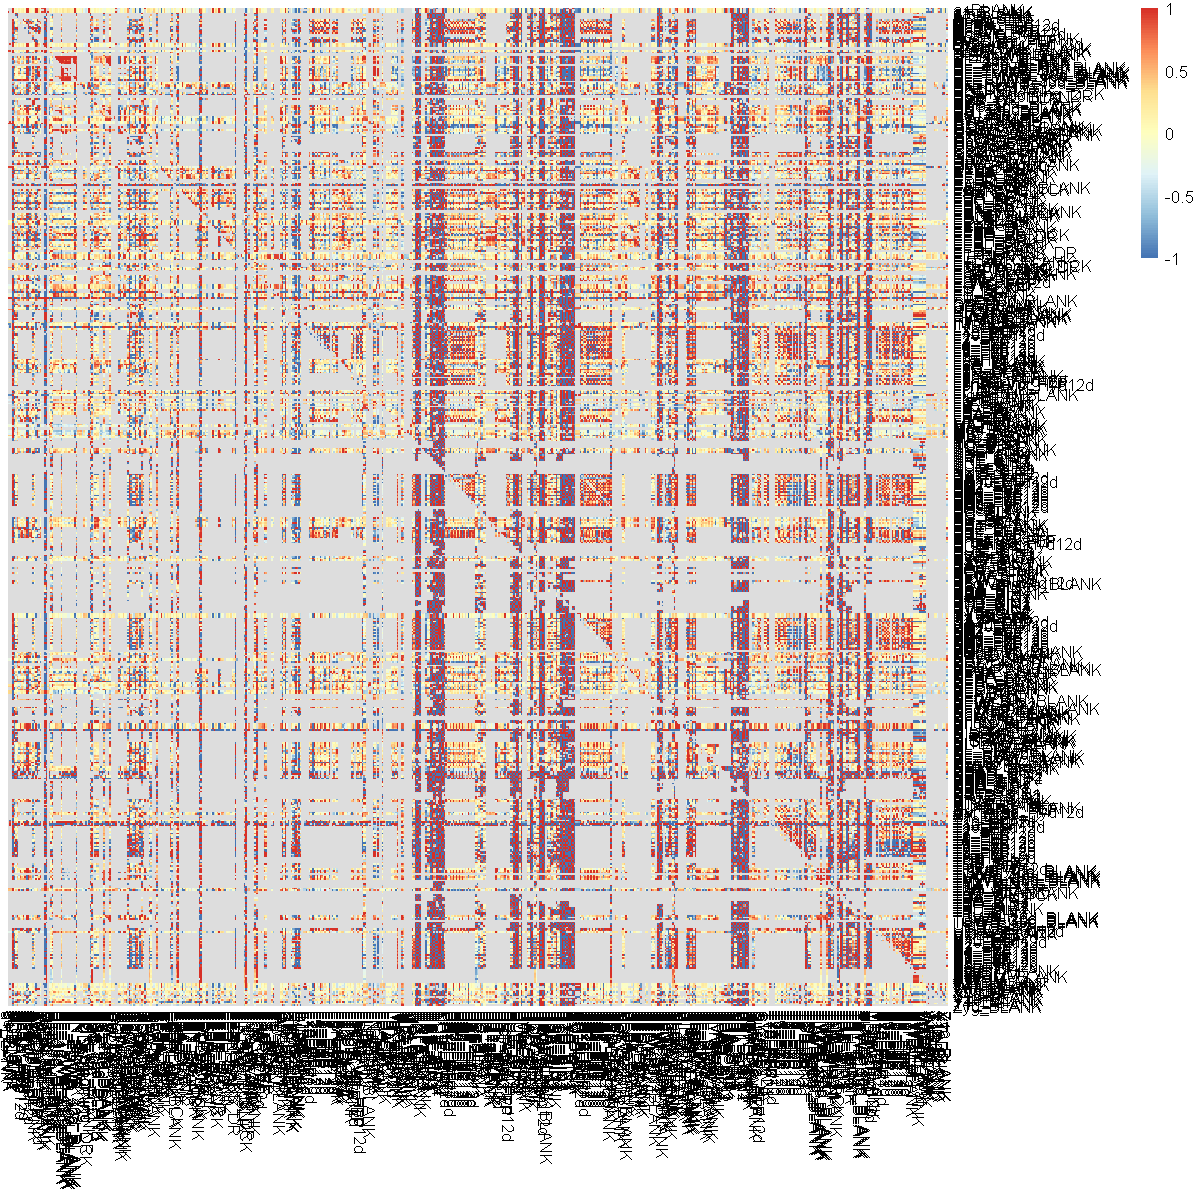

In [78]:



options(repr.plot.width = 10, repr.plot.height = 10)

dist_no_na <- function(mat) {
    edist <- dist(mat)
    edist[which(is.na(edist))] <- max(edist, na.rm=TRUE) * 1.1 
    return(edist)
    }

# pheatmap(as.matrix(rG_matrix))


pheatmap(rG_matrix, 
        cluster_rows = FALSE,
        cluster_cols = FALSE)



# pheatmap( as.matrix(rG_matrix), 
# #         scale = "row",
# #           cluster_rows = FALSE,
# #           cluster_cols = FALSE,
# # #           col = Colors,
# #            trace = "none", 
# #            xlab = "Comparison",
# #            scale = c("none"),
# #            na.color="gray",
# #            dendrogram = "row", 
# #            Colv = FALSE,
#            distfun=dist_no_na)

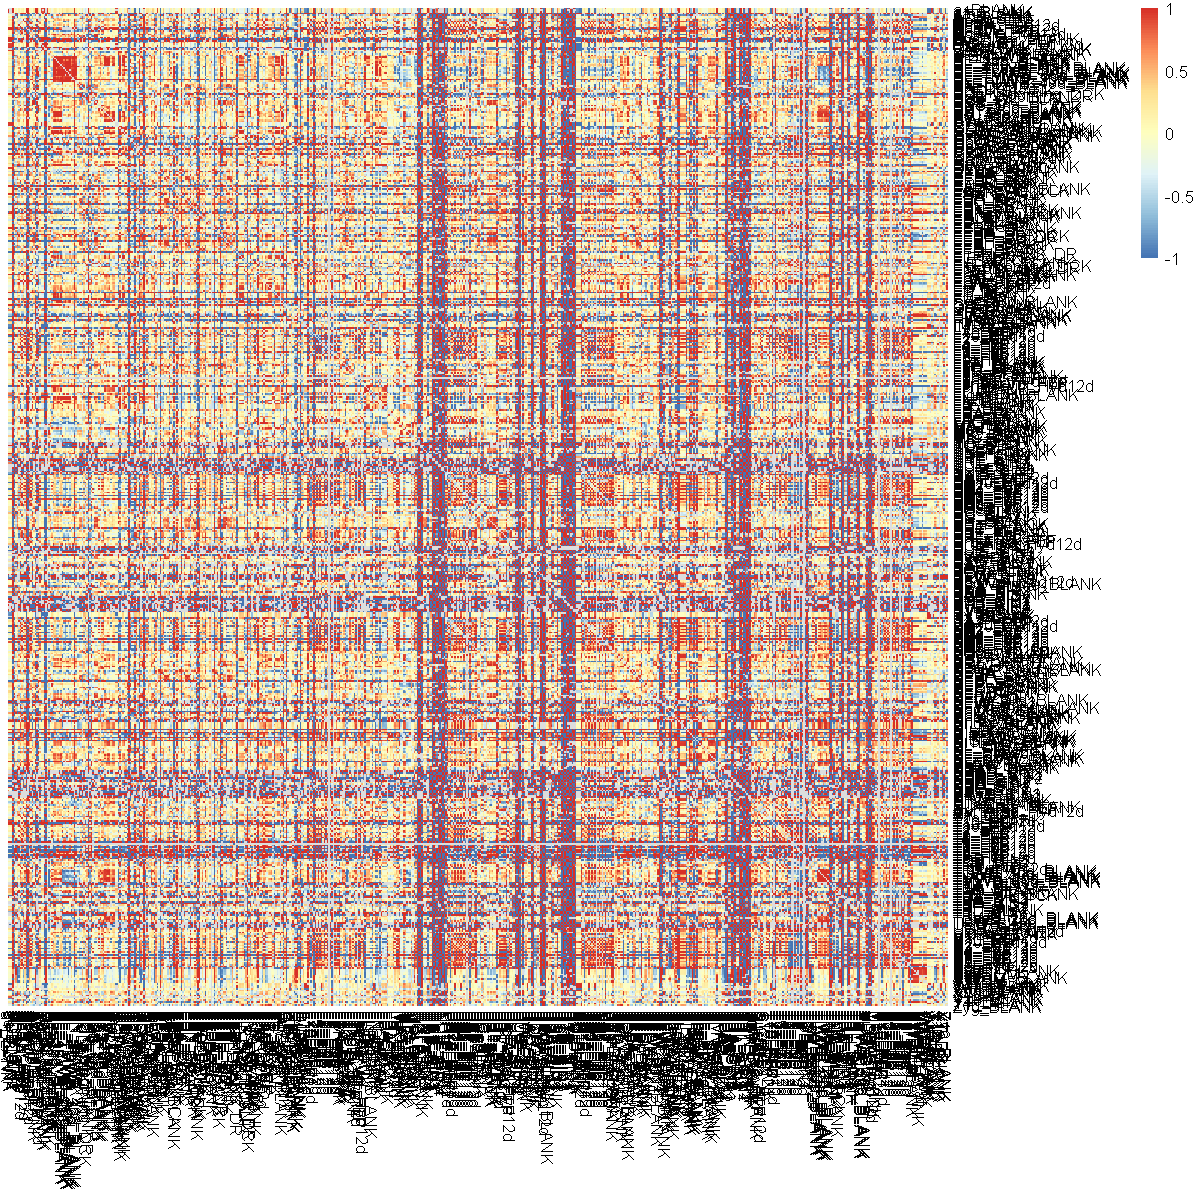

In [77]:
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
# subset(Trait_idx_1 < Trait_idx_2) %>% 
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


require(pheatmap)
options(repr.plot.width = 10, repr.plot.height = 10)

dist_no_na <- function(mat) {
    edist <- dist(mat)
    edist[which(is.na(edist))] <- max(edist, na.rm=TRUE) * 1.1 
    return(edist)
    }

# pheatmap(as.matrix(rG_matrix))


pheatmap(rG_matrix, 
        cluster_rows = FALSE,
        cluster_cols = FALSE)



# pheatmap( as.matrix(rG_matrix), 
# #         scale = "row",
# #           cluster_rows = FALSE,
# #           cluster_cols = FALSE,
# # #           col = Colors,
# #            trace = "none", 
# #            xlab = "Comparison",
# #            scale = c("none"),
# #            na.color="gray",
# #            dendrogram = "row", 
# #            Colv = FALSE,
#            distfun=dist_no_na)

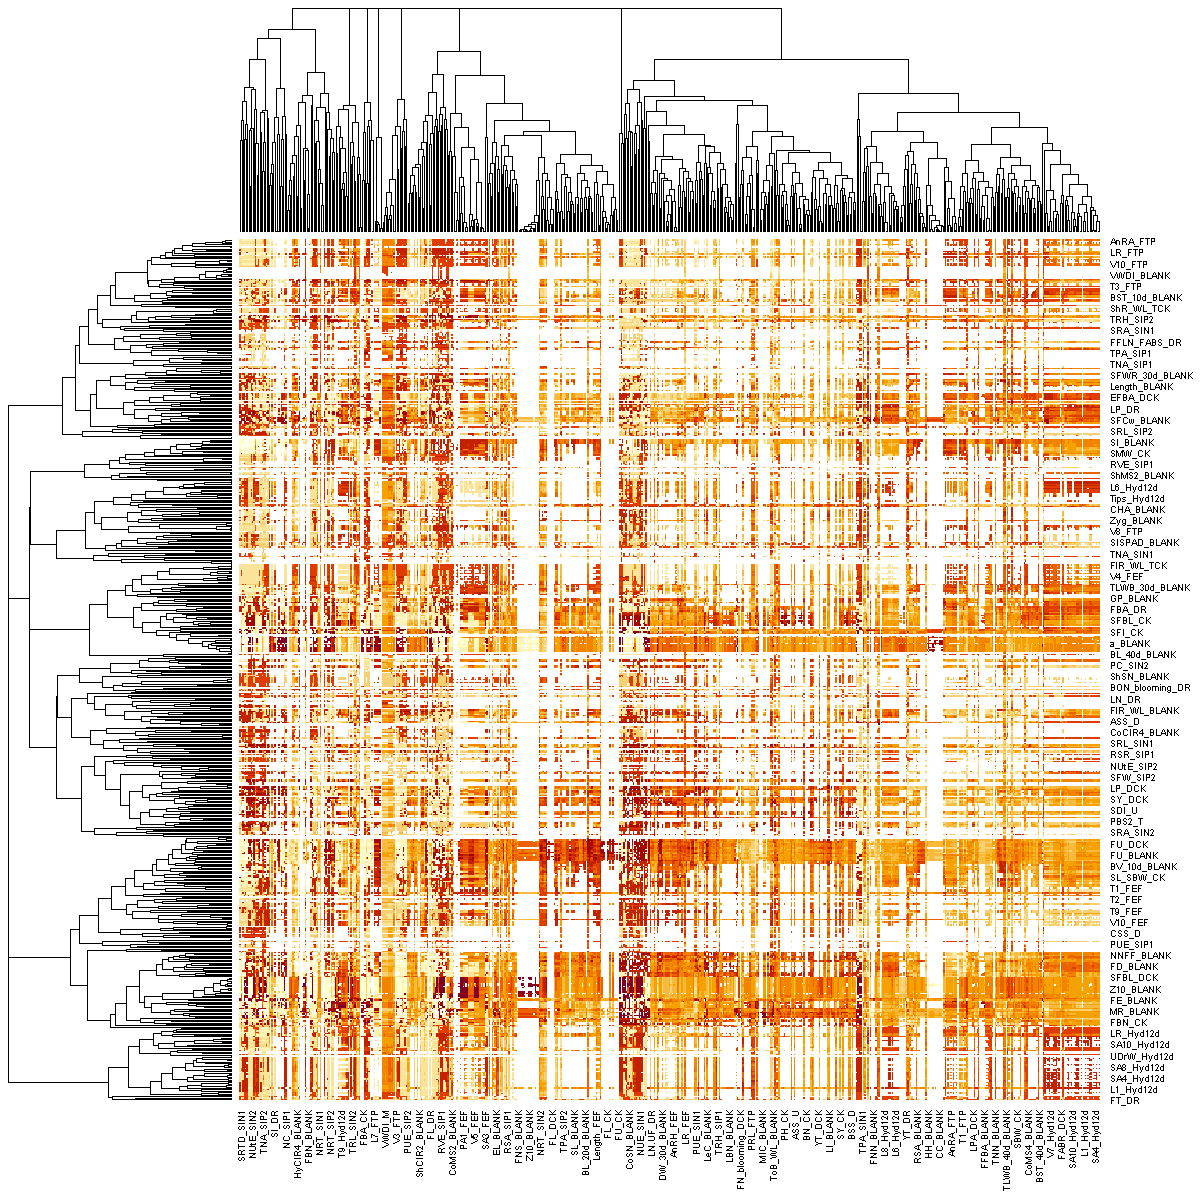

In [64]:
df_rg %>% 
mutate(Trait_idx_1 = as.integer(Trait_idx_1)) %>% 
mutate(Trait_idx_2 = as.integer(Trait_idx_2)) %>% 
mutate(Trait1 = triat_vec[Trait_idx_1]) %>% 
mutate(Trait2 = triat_vec[Trait_idx_2]) %>% 
subset(Trait_idx_1 < Trait_idx_2) %>% 
.[c('Trait1', 'Trait2', 'rG')] %>% 
spread(Trait2, rG) %>% 
column_to_rownames('Trait1') -> rG_matrix


require(pheatmap)
options(repr.plot.width = 10, repr.plot.height = 10)

dist_no_na <- function(mat) {
    edist <- dist(mat)
    edist[which(is.na(edist))] <- max(edist, na.rm=TRUE) * 1.1 
    return(edist)
    }

heatmap( as.matrix(rG_matrix), 
        scale = "row",
#           col = Colors,
#            trace = "none", 
#            xlab = "Comparison",
#            scale = c("none"),
#            na.color="gray",
#            dendrogram = "row", 
#            Colv = FALSE,
           distfun=dist_no_na)



### Test code

#### Function to generate BLUP and heridity

In [12]:
generate_blup_heridity <- function(df_raw, pheno_sum, trait, treatment){
    tmp <- pheno_sum %>% subset(Trait == trait & Treatment == treatment) %>% subset(Replicate2 != 'AV')
    tmp2 <- df_raw[c('ID', tmp$性状)] %>% 
        gather(性状, value, 2:ncol(.)) %>% 
        merge(tmp, '性状') %>% 
        .[c('Trait', 'Treatment', 'Location', 'Year', 'Replicate2', '性状', 'ID', 'value' )] %>% 
        mutate(ID = as.factor(ID)) %>% 
        mutate(Trait = as.factor(Trait)) %>% 
        mutate(Location = as.factor(Location)) %>% 
        mutate(Year = as.factor(Year)) %>% 
        mutate(Treatment = as.factor(Treatment)) %>% 
        mutate(Replicate2 = as.factor(Replicate2))
    
    # fit model
    mod1 = lmer(value ~ (1|ID) + (1|Location/Replicate2) + (1|Year), data = tmp2)

    # generate BLUP
    random <- ranef(mod1)
    fixed <- fixef(mod1)
    BLUP <- fixed[1] + random$ID
    colnames(BLUP)[1] = paste0(trait, '_', treatment)
    
    # generate heredity
    var_vec <- VarCorr(mod1) %>% as.data.frame() %>% .$vcov
    vG = var_vec[1]
    vRL = var_vec[2]
    vL = var_vec[3]
    vY = var_vec[4]
    Y_num = tmp$Year %>% unique %>% length
    L_num = tmp$Location %>% unique %>% length
    RL_num = Y_num * L_num
    heredity = vG / (vG + vRL/RL_num + vL/L_num + vY/Y_num)
    
    return(list(BLUP, heredity))
#     return(tmp)
}

In [13]:
generate_blup_heridity(df_raw, pheno_sum, "FL", "CK")

[[1]]
        FL_CK
K001 31.63621
K002 29.23859
K003 28.76737
K004 28.18233
K005 31.25141
K006 33.17957
K007 29.64492
K008 33.16170
K009 31.01721
K010 27.58507
K011 29.76061
K012 30.43594
K013 29.05048
K014 30.99934
K015 30.92691
K016 31.07646
K017 31.04354
K018 29.96001
K019 30.37292
K020 30.08416
K021 29.77001
K022 30.59865
K023 27.31419
K024 29.48126
K025 27.11197
K026 27.46186
K027 26.91727
K028 27.91897
K029 30.80652
K030 29.74650
K031 28.99593
K032 28.38832
K033 28.63193
K034 26.92668
K035 28.95642
K036 29.36181
K037 32.13742
K038 32.65380
K039 29.97788
K040 30.21490
K041 30.67954
K042 28.93291
K043 31.03132
K044 29.04860
K045 31.59660
K046 27.89922
K047 30.42371
K048 28.39208
K049 32.50142
K050 29.63457
K051 28.27169
K052 29.67596
K053 26.07922
K054 29.33171
K055 29.19062
K056 29.24518
K057 29.60635
K058 26.90034
K059 29.00251
K060 28.80499
K061 29.58378
K062 26.03408
K063 22.32730
K064 30.14060
K065 28.85202
K066 27.34241
K067 29.23295
K068 28.85672
K069 30.40960
K070 28.25758
K071 29.48878
K072 29.23295
K073 31.63798
K074 29.65150
K075 29.52170
K076 28.41183
K077 31.51571
K078 28.43911
K079 28.24347
K080 28.14941
K081 28.62252
K082 26.95489
K083 28.71281
K084 28.50777
K085 27.57379
K086 28.32624
K087 29.90075
K088 26.50248
K089 28.31119
K090 28.98182
K091 28.76549
K092 28.46545
K093 29.08622
K094 31.06800
K095 29.28656
K096 28.60277
K097 28.63287
K098 28.68084
K099 28.14659
K100 29.29691
K101 28.27921
K102 28.78054
K103 28.85390
K104 30.53187
K105 26.90128
K106 29.34394
K107 28.57925
K108 27.60765
K109 28.38173
K110 26.91257
K111 28.15600
K112 30.64474
K113 28.39020
K114 29.47938
K115 29.69195
K116 29.44364
K117 28.75232
K118 28.86331
K119 25.47726
K120 31.28245
K121 29.66279
K122 28.19550
K123 27.49572
K124 27.92462
K125 28.66202
K126 30.61370
K127 29.71828
K128 30.32965
K129 29.65150
K130 28.89246
K131 29.74149
K132 25.99927
K133 29.50685
K134 29.82080
K135 23.63563
K136 27.72334
K137 29.57626
K138 28.79558
K139 28.28109
K140 29.78694
K141 28.72786
K142 27.43929
K143 27.01979
K144 28.10110
K145 27.23236
K146 30.09545
K147 28.33565
K148 29.57720
K149 29.70323
K150 28.36763
K151 29.34488
K152 27.45339
K153 28.22654
K154 28.27263
K155 30.07100
K156 27.44211
K157 29.60447
K158 28.65920
K159 28.16540
K160 28.50401
K161 29.52735
K162 26.22971
K163 31.00404
K164 29.20003
K165 28.36951
K166 29.29785
K167 29.17746
K168 28.60935
K169 29.35240
K170 28.38079
K171 29.40978
K172 29.57249
K173 29.08246
K174 29.30067
K175 29.26305
K176 30.27698
K177 32.34717
K178 31.48655
K179 29.17746
K180 27.40919
K181 31.12443
K182 28.59901
K183 28.67801
K184 29.28938
K185 29.07493
K186 29.37497
K187 29.81328
K188 28.26416
K189 29.55556
K190 29.04107
K191 26.93890
K192 30.21584
K193 30.04936
K194 28.36574
K195 27.91521
K196 29.75600
K197 28.96301
K198 29.54428
K199 28.30179
K200 26.05477
K201 30.53187
K202 28.52846
K203 29.82080
K204 28.78336
K205 28.15788
K206 29.34017
K207 29.80858
K208 27.97823
K209 26.92197
K210 29.27057
K211 28.84449
K212 27.61047
K213 28.83415
K214 29.16429
K215 32.27193
K216 29.05800
K217 31.62764
K218 30.74444
K219 29.73521
K220 28.18422
K221 25.10573
K222 27.33206
K223 28.35822
K224 29.35522
K225 28.96395
K226 26.52881
K227 31.08399
K228 28.44381
K229 29.89793
K230 29.74744
K231 29.90357
K232 31.51383
K233 29.19533
K234 29.24235
K235 28.84826
K236 28.32718
K237 28.06758
K238 28.26887
K239 29.49443
K240 29.96941
K241 28.75138
K242 26.59089
K243 27.12796
K244 26.07828
K245 29.88947
K246 30.34752
K247 28.78148
K248 29.55744
K249 30.35317
K250 30.27886
K251 28.13154
K252 29.19909
K253 28.81628
K254 29.97412
K255 29.93649
K256 29.12384
K257 28.83885
K258 29.72110
K259 27.76190
K260 27.48255
K261 28.66861
K262 30.72563
K263 30.58172
K264 25.43305
K265 30.38138
K266 29.36275
K267 29.03261
K268 29.16805
K269 28.36386
K270 29.19156
K271 28.34223
K272 27.43270
K273 30.07005
K274 32.35470
K275 29.49819
K276 30.28733
K277 26.09051
K278 28.73633
K279 29.50948
K280 30.88365
K281 26.59842
K282 29.37215
K283 29.46057
K284 28.29991
K285

In [138]:
generate_blup_heridity_debug <- function(df_raw, pheno_sum, trait, treatment){
    tmp <- pheno_sum %>% subset(Trait == trait & Treatment == treatment) %>% subset(Replicate2 != 'AV')
    tmp2 <- df_raw[c('ID', tmp$性状)] 
    
#         gather(性状, value, 2:ncol(.)) %>% 
#         merge(tmp, '性状') %>% 
#         .[c('Trait', 'Treatment', 'Location', 'Year', 'Replicate2', '性状', 'ID', 'value' )] %>% 
#         mutate(ID = as.factor(ID)) %>% 
#         mutate(Trait = as.factor(Trait)) %>% 
#         mutate(Location = as.factor(Location)) %>% 
#         mutate(Year = as.factor(Year)) %>% 
#         mutate(Treatment = as.factor(Treatment)) %>% 
#         mutate(Replicate2 = as.factor(Replicate2))
    
#     # fit model
#     mod1 = lmer(value ~ (1|ID) + (1|Location/Replicate2) + (1|Year), data = tmp2)

#     # generate BLUP
#     random <- ranef(mod1)
#     fixed <- fixef(mod1)
#     BLUP <- fixed[1] + random$ID
#     colnames(BLUP)[1] = paste0(trait, '_', treatment)
    
#     # generate heredity
#     var_vec <- VarCorr(mod1) %>% as.data.frame() %>% .$vcov
#     vG = var_vec[1]
#     vRL = var_vec[2]
#     vL = var_vec[3]
#     vY = var_vec[4]
#     Y_num = tmp$Year %>% unique %>% length
#     L_num = tmp$Location %>% unique %>% length
#     RL_num = Y_num * L_num
#     heredity = vG / (vG + vRL/RL_num + vL/L_num + vY/Y_num)
    
#     return(list(BLUP, heredity))
    return(list(tmp,tmp2))
}
generate_blup_heridity_debug(df_raw, pheno_sum, "FE", "BLANK")


[[1]]
     X1        性状           注释 性状分类1 Trait Location Year Treatment
1564  7 FE_AY_18_R1 断裂伸长率%_R1  纤维品质    FE       AY   18     BLANK
1565  8 FE_AY_18_R2 断裂伸长率%_R2  纤维品质    FE       AY   18     BLANK
     Replicate Additional_info Replicate2
1564        R1            <NA>         R1
1565        R2            <NA>         R2

[[2]]
      ID FE_AY_18_R1 FE_AY_18_R2
1   K001         7.2         8.0
2   K002         8.8         8.9
3   K003         8.5         9.6
4   K004         7.7         8.6
5   K005         6.9         6.9
6   K006         7.3         6.5
7   K007         7.4         7.0
8   K008         6.4         6.5
9   K009         8.4         8.0
10  K010         8.5         8.0
11  K011         6.6         7.3
12  K012         7.1         7.3
13  K013         7.8         6.9
14  K014         6.8         6.3
15  K015         6.4         6.6
16  K016         6.7         6.9
17  K017         7.2         7.7
18  K018         6.3         6.7
19  K019         8.3         8.4
20  K020         6.6         6.4
21  K021         7.3         7.7
22  K022         7.8         8.7
23  K023         6.7         6.8
24  K024         6.3         6.8
25  K025         8.1         7.9
26  K026         7.5         7.9
27  K027         7.7         7.0
28  K028         9.3         8.6
29  K029         8.4         7.2
30  K030         6.6         6.6
31  K031         8.7         8.6
32  K032         7.2         6.6
33  K033         7.9         7.2
34  K034         8.4         8.5
35  K035         6.3         5.9
36  K036         8.2         7.4
37  K037         8.4         7.5
38  K038         7.8         8.5
39  K039         6.8         7.2
40  K040         8.4         9.8
41  K041         7.2         8.3
42  K042         7.0         7.2
43  K043         8.1         9.0
44  K044         7.4         7.6
45  K045         7.6         8.3
46  K046         6.6         6.4
47  K047         7.3         6.6
48  K048         7.6         7.9
49  K049         6.9         6.7
50  K050         8.0         8.4
51  K051         6.4         6.3
52  K052         7.5         7.2
53  K053         8.4         8.2
54  K054         8.7         8.3
55  K055         7.5         8.8
56  K056         6.6         7.0
57  K057         7.1         7.6
58  K058         8.6         9.8
59  K059         8.8         7.5
60  K060         9.5        10.7
61  K061         9.9         8.5
62  K062         7.2         8.0
63  K063         9.6        10.5
64  K064         7.8         8.2
65  K065         7.7         8.6
66  K066         9.1         8.9
67  K067         8.9        10.0
68  K068        10.1        10.3
69  K069        11.3        12.2
70  K070        10.9        10.4
71  K071         8.5         8.7
72  K072         7.3         7.7
73  K073         7.8         8.7
74  K074        10.0        11.3
75  K075        10.9         9.7
76  K076         7.7         8.1
77  K077         8.5         9.2
78  K078         7.9         7.7
79  K079         7.7         9.0
80  K080         9.2        10.9
81  K081         7.3         7.9
82  K082         9.0         8.5
83  K083         9.6        10.8
84  K084        11.0        10.5
85  K085         9.4         9.9
86  K086         7.9         7.9
87  K087         7.6         7.6
88  K088         8.4         9.8
89  K089         8.6         9.2
90  K090         7.4         7.8
91  K091         7.8         7.6
92  K092         7.6         8.0
93  K093         8.9         9.2
94  K094         8.6         8.5
95  K095        10.0        10.3
96  K096        12.6        10.9
97  K097         8.2         8.0
98  K098         8.6         8.2
99  K099         6.4         6.2
100 K100         9.2         8.1
101 K101         7.3         8.0
102 K102         8.2         8.1
103 K103         9.8         8.6
104 K104        10.2         9.1
105 K105         8.5         8.0
106 K106         8.0         7.5
107 K107         9.7         8.3
108 K108         8.3         7.6
109 K109        10.1        10.1
110 K110         8.3         8.6